<a href="https://colab.research.google.com/github/addicted-ai/telecom-churn-prediction/blob/main/Telecom_Churn_Prediction_Pycaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

## Understanding the business objective and the data

The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Understanding customer behaviour during churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are **three phases** of customer lifecycle :

1. The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

2. The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. The ‘churn’ phase: In this phase, the customer is said to have churned. You **define churn based on this phase**. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from imblearn.metrics import sensitivity_specificity_support

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

# Set rows and columns to max
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Understanding

In [2]:
!wget https://raw.githubusercontent.com/addicted-ai/telecom-churn-prediction/main/telecom_churn_data.zip
!unzip -o telecom_churn_data.zip

--2022-05-22 13:35:36--  https://raw.githubusercontent.com/addicted-ai/telecom-churn-prediction/main/telecom_churn_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24340570 (23M) [application/zip]
Saving to: ‘telecom_churn_data.zip’

telecom_churn_data. 100%[===================>]  23.21M  --.-KB/s    in 0.1s    

2022-05-22 13:35:37 (168 MB/s) - ‘telecom_churn_data.zip’ saved [24340570/24340570]

Archive:  telecom_churn_data.zip
  inflating: telecom_churn_data.csv  


In [3]:
df = pd.read_csv("telecom_churn_data.csv", low_memory=False)
df.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

In [4]:
df.shape

(99999, 226)

In [5]:
df.describe()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98981.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358    278.536648    279.154731    261.645069   
std               0.0    328.439770    338.156291    344.474791    341.998630   
min               0.0  -2258.709000  -2014.045000   -945.808000  -1899.505000   
25%               0.0     93.411500     86.980500     84.126000     62.685000   
50%               0.0    197.704000    191.640000    192.080000    176.849000   
75%               0.0    371.060000    365.344500    369.370500    353.466500   
max               0.0  27731.088000  35145.834000  33543.624000  38805.617000   

        onnet_mou_6   onnet_mou_7   onnet_mou_8   onnet_mou_9  offnet_mou_6  \
count  96062.000000  96140.000000  94621.000000  92254.000000  96062.000000   
mean     132.395875    133.670805    133.018098    130.302327    197.935577   
std      297.207406    308.794148    308.951589    308.477668    316.851613   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        7.380000      6.660000      6.460000      5.330000     34.730000   
50%       34.310000     32.330000     32.360000     29.840000     96.310000   
75%      118.740000    115.595000    115.860000    112.130000    231.860000   
max     7376.710000   8157.780000  10752.560000  10427.460000   8362.360000   

       offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  \
count  96140.000000  94621.000000  92254.000000   96062.000000   96140.000000   
mean     197.045133    196.574803    190.337222       9.950013       7.149898   
std      325.862803    327.170662    319.396092      72.825411      73.447948   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%       32.190000     31.630000     27.130000       0.000000       0.000000   
50%       91.735000     92.140000     87.290000       0.000000       0.000000   
75%      226.815000    228.260000    220.505000       0.000000       0.000000   
max     9667.130000  14007.340000  10310.760000   13724.380000   15371.040000   

       roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  \
count   94621.000000   92254.000000   96062.000000   96140.000000   
mean        7.292981       6.343841      13.911337       9.818732   
std        68.402466      57.137537      71.443196      58.455762   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max     13095.360000    8464.030000    3775.110000    2812.040000   

       roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   94621.000000   92254.000000      96062.000000      96140.000000   
mean        9.971890       8.555519         47.100763         46.473010   
std        64.713221      58.438186        150.856393        155.318705   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.630000   
50%         0.000000       0.000000         11.910000         11.610000   
75%         0.000000       0.000000         40.960000         39.910000   
max      

In [6]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

## Data Cleaning

**Tag churners and remove attributes of the churn phase**

Tagging churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes we need to use to tag churners are:

- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9

In [7]:
# Tagging Churn=1 else 0

def churn(row):
    if row['total_ic_mou_9']==0 and row['total_og_mou_9']==0 and row['vol_2g_mb_9']==0 and row['vol_3g_mb_9']==0:
        return 1
    else:
        return 0
    
df['churn'] = df.apply(churn, axis=1)

In [8]:
# Dropping columns of 4th month i.e. Sep

col_to_drop = [col for col in df.columns if col.find("_9")!=-1 or col.find("sep_")!=-1]
print('There are ', len(col_to_drop), 'columns related to 4th month.')
df.drop(col_to_drop, axis=1, inplace=True)
print('No of columns after dropping 4th month data is ', len(df.columns))

There are  55 columns related to 4th month.
No of columns after dropping 4th month data is  172


**Filter high-value customers**

We need to predict churn only for the high-value customers. We define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [9]:
# Columns containig reacharge

col_reach = [col for col in df.columns if col.find("_rech_")!=-1 and col.find("date_")==-1]
df[col_reach].head()

total_rech_num_6  total_rech_num_7  total_rech_num_8  total_rech_amt_6  \
0                 4                 3                 2               362   
1                 4                 9                11                74   
2                 5                 4                 2               168   
3                10                11                18               230   
4                 5                 6                 3               196   

   total_rech_amt_7  total_rech_amt_8  max_rech_amt_6  max_rech_amt_7  \
0               252               252             252             252   
1               384               283              44             154   
2               315               116              86             200   
3               310               601              60              50   
4               350               287              56             110   

   max_rech_amt_8  total_rech_data_6  total_rech_data_7  total_rech_data_8  \
0             252                1.0                1.0                1.0   
1              65                NaN                1.0                2.0   
2              86                NaN                NaN                NaN   
3              50                NaN                NaN                NaN   
4             110                1.0                NaN                NaN   

   max_rech_data_6  max_rech_data_7  max_rech_data_8  count_rech_2g_6  \
0            252.0            252.0            252.0              0.0   
1              NaN            154.0             25.0              NaN   
2              NaN              NaN              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4             56.0              NaN              NaN              1.0   

   count_rech_2g_7  count_rech_2g_8  count_rech_3g_6  count_rech_3g_7  \
0              0.0              0.0              1.0              1.0   
1              1.0              2.0              NaN              0.0   
2              NaN              NaN              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              NaN              0.0              NaN   

   count_rech_3g_8  av_rech_amt_data_6  av_rech_amt_data_7  av_rech_amt_data_8  
0              1.0               252.0               252.0               252.0  
1              0.0                 NaN               154.0                50.0  
2              NaN                 NaN                 NaN                 NaN  
3              NaN                 NaN                 NaN                 NaN  
4              NaN                56.0                 NaN                 NaN

Above data have some missinge value. These values are missing as user have not done any recharge so we will be filling those as 0.

In [10]:
# Imputing missinge vlaues of above data as 0
df[col_reach] = df[col_reach].fillna(0)

Deriving two new features to find high value customers
- `total_rech_amt_data` - Total amount for internet recharge 
- `total_rech_amt_data_num` - Total amount for internet plus talktime recharge 

In [11]:
# Deriving new features

df['total_rech_amt_data_6'] = df['total_rech_data_6']*df['av_rech_amt_data_6']
df['total_rech_amt_data_7'] = df['total_rech_data_7']*df['av_rech_amt_data_7']
df['total_rech_amt_data_8'] = df['total_rech_data_8']*df['av_rech_amt_data_8']

df['total_rech_amt_data_num_6'] = df['total_rech_amt_6']+df['total_rech_amt_data_6']
df['total_rech_amt_data_num_7'] = df['total_rech_amt_7']+df['total_rech_amt_data_7']
df['total_rech_amt_data_num_8'] = df['total_rech_amt_8']+df['total_rech_amt_data_8']

In [12]:
# Filtering high value customer

avg_reach_amnt_data_num_6_7 = (df['total_rech_amt_data_num_6'] + df['total_rech_amt_data_num_7'])/2
threshold = (avg_reach_amnt_data_num_6_7).quantile(0.7)
df = df[avg_reach_amnt_data_num_6_7>=threshold]

print('The 70th Quantile Threshold for Evaluating High Value Customers using Recharge Amount is',threshold)

The 70th Quantile Threshold for Evaluating High Value Customers using Recharge Amount is 478.0


### Data Header Masking 

- We Rename some Columns to Make it similar to used format:
      Jun : 6 
      Jul : 7
      Aug : 8

In [13]:
df.rename({'jun_vbc_3g': 'vbc_3g_6',
           'jul_vbc_3g': 'vbc_3g_7',
           'aug_vbc_3g':'vbc_3g_8'}, axis='columns',inplace=True)

## EDA

### Missing Value

In [14]:
# Function to check and create dataframe for missing value

def check_miss(df):
    '''
    This function will check number and % of missing value in each column 
    if it is more than 0 then it will return a dataframe

    Keyword arguments:
    df: Pandas DataFrame
    '''

    #Column which have missing value
    miss_col = [col for col in df.columns if df[col].isnull().sum()>0]

    #DataFrame that contains no. and % of missing value
    miss_df = pd.DataFrame([df[miss_col].isnull().sum(),df[miss_col].isnull().sum()/len(df)*100],
                          index=['Missing Value','Missing Value %'])
    
    return miss_df

In [15]:
# Checking missing value

miss_df = check_miss(df)
miss_df

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
Missing Value        224.000000      224.000000      224.000000   
Missing Value %        0.746642        0.746642        0.746642   

                 last_date_of_month_7  last_date_of_month_8  onnet_mou_6  \
Missing Value               27.000000            165.000000   545.000000   
Missing Value %              0.089997              0.549982     1.816606   

                 onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
Missing Value      537.00000  1174.000000    545.000000     537.00000   
Missing Value %      1.78994     3.913203      1.816606       1.78994   

                 offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
Missing Value     1174.000000     545.000000      537.00000    1174.000000   
Missing Value %      3.913203       1.816606        1.78994       3.913203   

                 roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
Missing Value       545.000000      537.00000    1174.000000   
Missing Value %       1.816606        1.78994       3.913203   

                 loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
Missing Value          545.000000         537.00000       1174.000000   
Missing Value %          1.816606           1.78994          3.913203   

                 loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
Missing Value          545.000000         537.00000       1174.000000   
Missing Value %          1.816606           1.78994          3.913203   

                 loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
Missing Value          545.000000         537.00000       1174.000000   
Missing Value %          1.816606           1.78994          3.913203   

                 loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
Missing Value          545.000000         537.00000       1174.000000   
Missing Value %          1.816606           1.78994          3.913203   

                 loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
Missing Value      545.000000     537.00000   1174.000000        545.000000   
Missing Value %      1.816606       1.78994      3.913203          1.816606   

                 std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  \
Missing Value           537.00000       1174.000000        545.000000   
Missing Value %           1.78994          3.913203          1.816606   

                 std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
Missing Value           537.00000       1174.000000        545.000000   
Missing Value %           1.78994          3.913203          1.816606   

                 std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_t2c_mou_6  \
Missing Value           537.00000       1174.000000        545.000000   
Missing Value %           1.78994          3.913203          1.816606   

                 std_og_t2c_mou_7  std_og_t2c_mou_8  std_og_mou_6  \
Missing Value           537.00000       1174.000000    545.000000   
Missing Value %           1.78994          3.913203      1.816606   

                 std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  \
Missing Value       537.00000   1174.000000    545.000000     537.00000   
Missing Value %       1.78994      3.913203      1.816606       1.78994   

                 isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  \
Missing Value     1174.000000    545.000000     537.00000   1174.000000   
Missing Value %      3.913203      1.816606       1.78994      3.913203   

                 og_others_6  og_others_7  og_others_8  loc_ic_t2t_mou_6  \
Missing Value     545.000000    537.00000  1174.000000        545.000000   
Missing Value %     1.816606      1.78994     3.913203          1.816606   

                 loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  \
Missing Value           537.00000       1174.000000        545.000000   
Missing Value %           1.78994          3.913203          1.816606   

                 loc_ic_t2m_mou_7  loc_ic_t2m_mou_8

- `date_of_last_rech_data_6, date_of_last_rech_data_7, date_of_last_rech_data_8, arpu_3g_6, arpu_3g_7, arpu_3g_8, arpu_2g_6, arpu_2g_7, arpu_2g_8, night_pck_user_6, night_pck_user_7, night_pck_user_8, fb_user_6, fb_user_7, fb_user_8` have missing value above 40%

In [16]:
# Function to split data into categorical and numerical

def column_split(df, thresold=10):
    cat_col = []
    num_col = []
    for col in df:
        if df[col].dtype=="O":
            cat_col.append(col)
        elif len(df[col].unique())<thresold:
            cat_col.append(col)
        else:
            num_col.append(col)
    return cat_col, num_col     

In [17]:
# Splitting columns into categorical and numerical, also separating date columns from cat_col

cat_col, num_col = column_split(df)
num_col.remove("mobile_number")
cat_col.remove("churn")

date_col = list(filter(lambda x: x.find('date')!=-1, cat_col))
cat_col = list(filter(lambda x: x.find('date')==-1, cat_col))

### Target

In [18]:
# Percentage of target column

df["churn"].value_counts(normalize=True)

0    0.918636
1    0.081364
Name: churn, dtype: float64

- Data is highly imbalnace

### Initial Visualization for better Data Understanding

#### Categorical Columns:

In [19]:
# Function to plot percentage of categorical values of each columns

def cat_plot(df,col):
    plt.figure(figsize=(15,4))
    sns.set_style("whitegrid")

    plt.subplot(1,2,1)
    x = df[df["churn"]==0][col].value_counts(normalize=True).index
    y = df[df["churn"]==0][col].value_counts(normalize=True).values
    sns.barplot(x,y)
    plt.title(f"Percentage of {col} - non churn")
    plt.xticks(rotation=90)

    plt.subplot(1,2,2)
    x = df[df["churn"]==1][col].value_counts(normalize=True).index
    y = df[df["churn"]==1][col].value_counts(normalize=True).values
    sns.barplot(x,y)
    plt.title(f"Percentage of {col} - churn")
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()

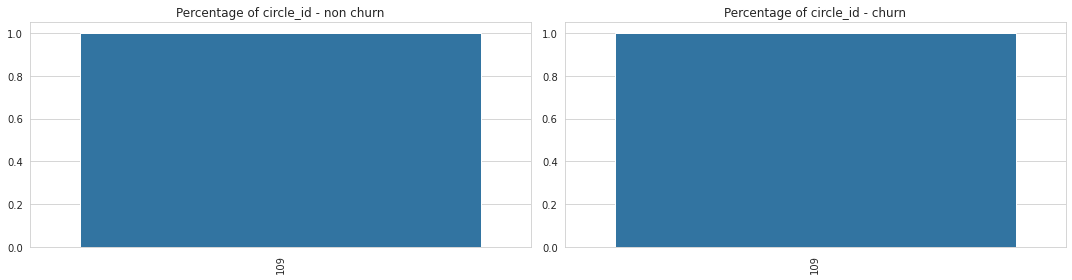

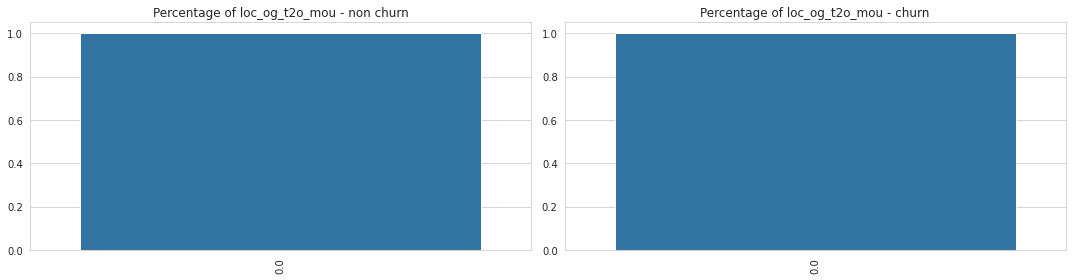

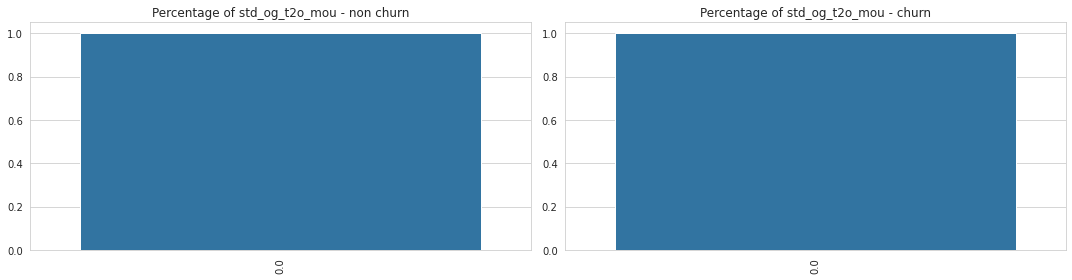

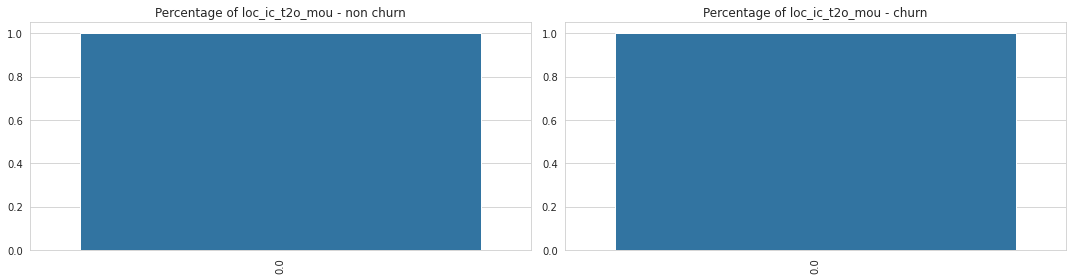

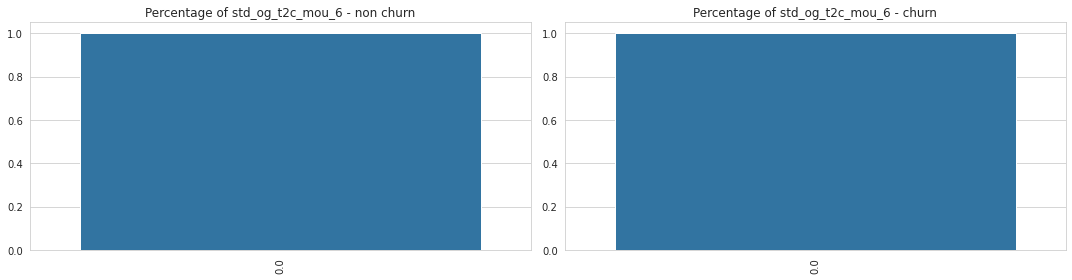

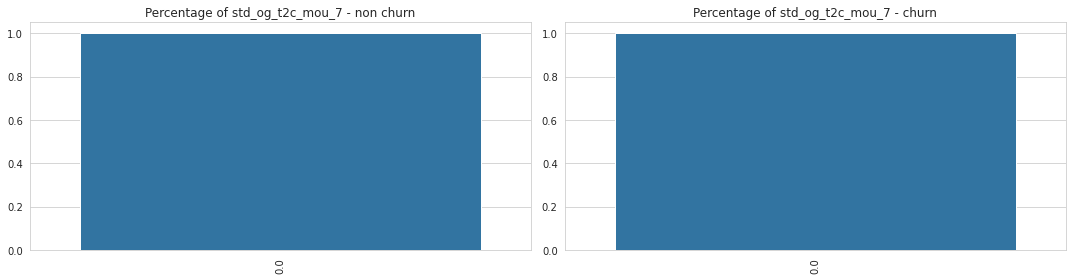

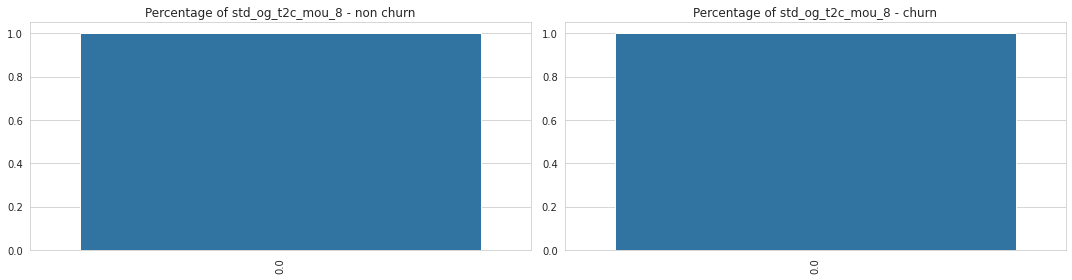

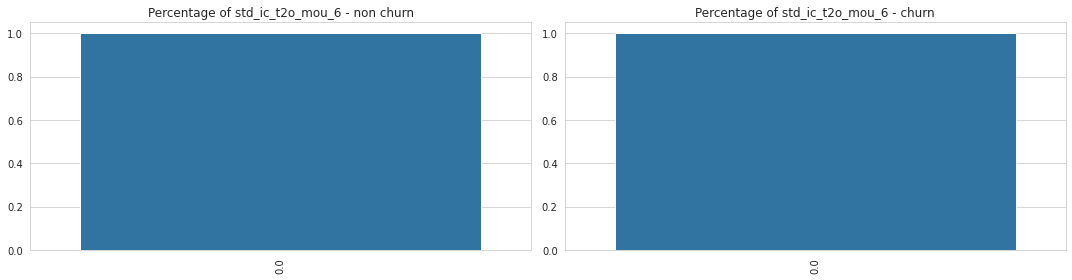

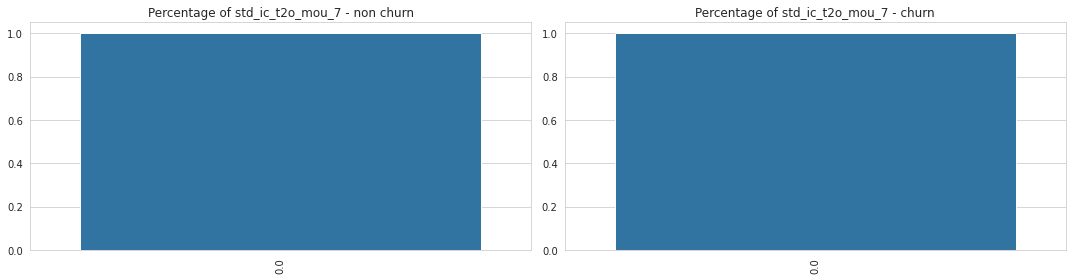

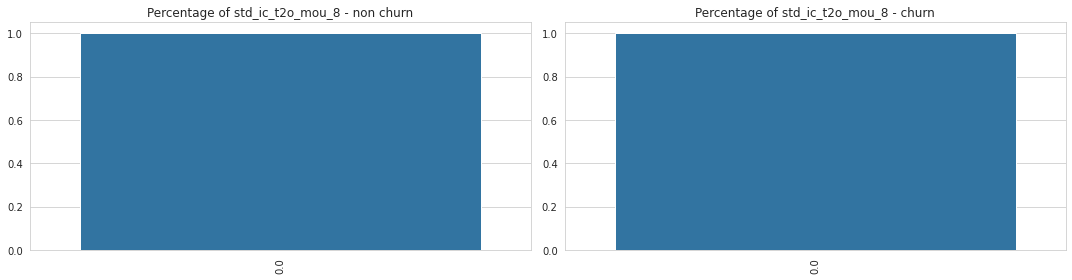

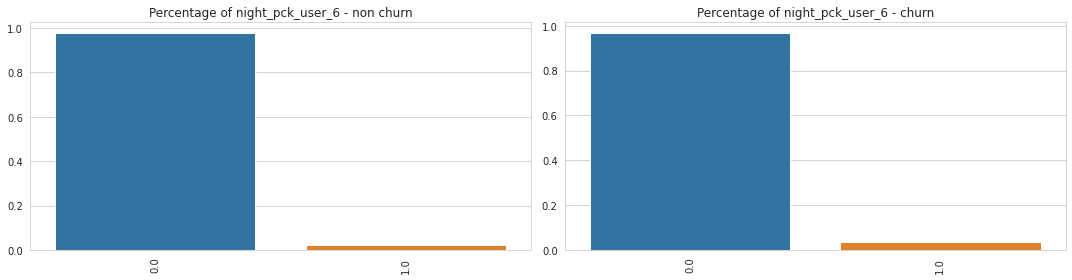

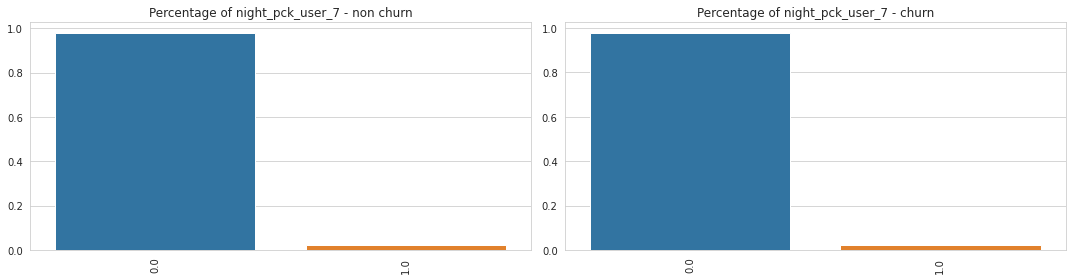

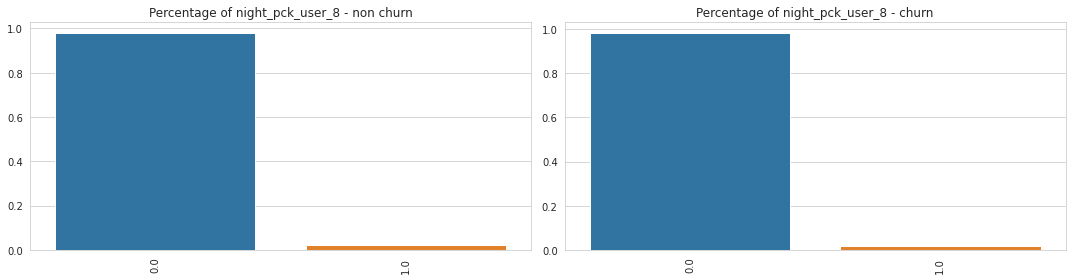

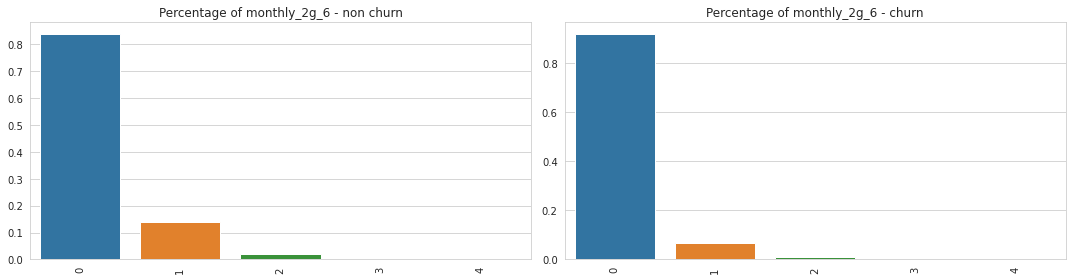

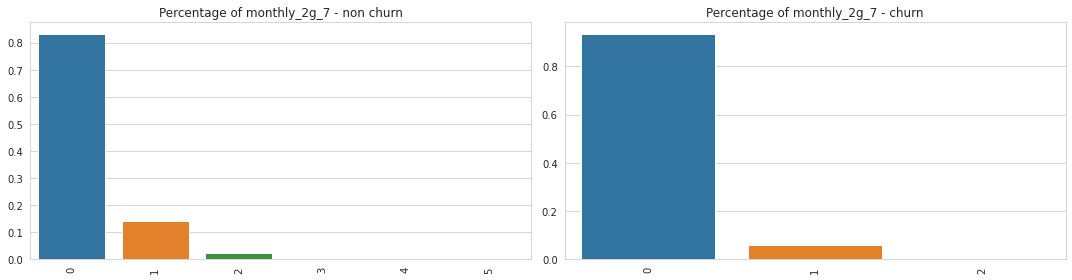

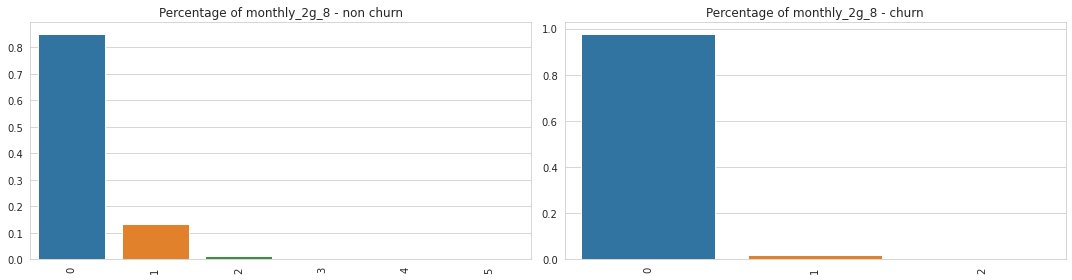

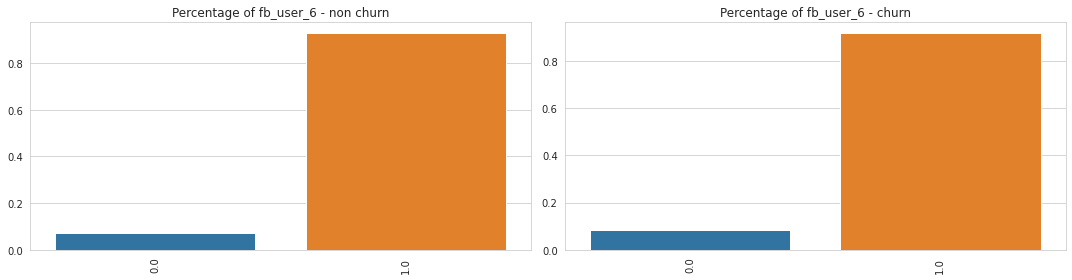

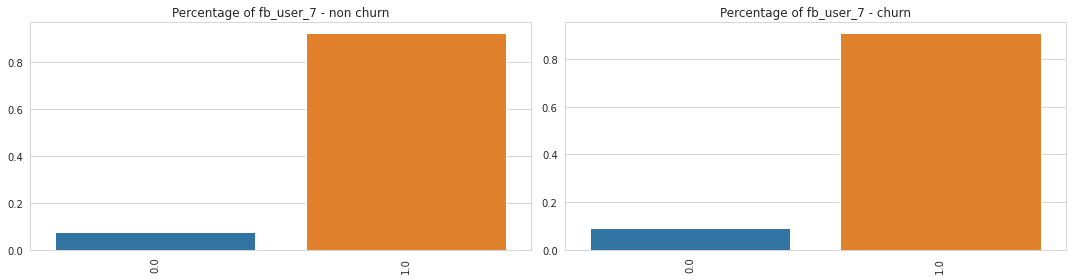

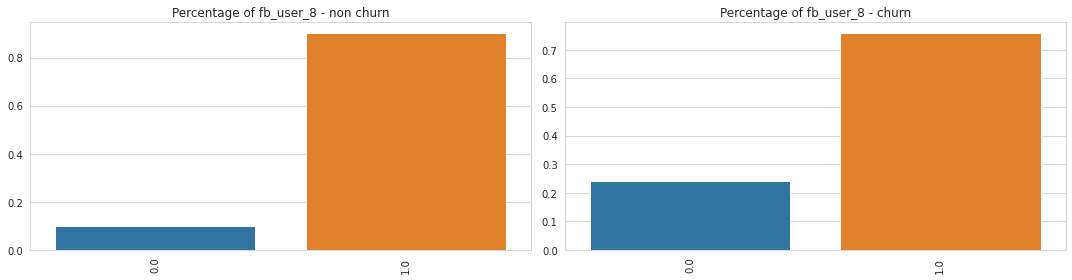

In [20]:
# Ploting percentage of categorical values for each columns

for col in cat_col:
    cat_plot(df,col)

In [21]:
# Dropping column with same values

col_to_drop = ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6',
               'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

num_col = list(filter(lambda x: x not in col_to_drop, num_col))
cat_col = list(filter(lambda x: x not in col_to_drop, cat_col))

df.drop(col_to_drop, axis=1, inplace=True)

#### Date Columns

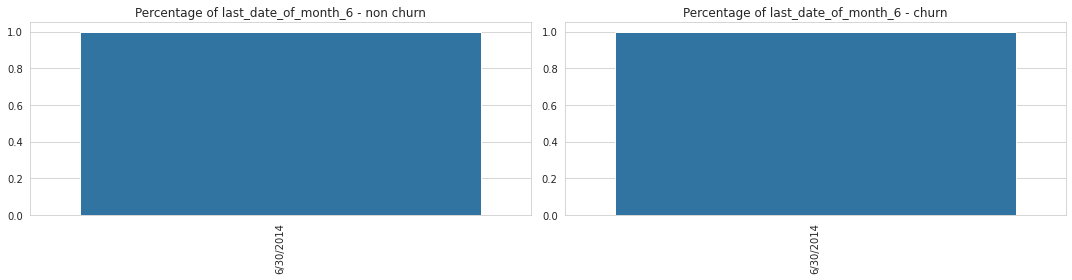

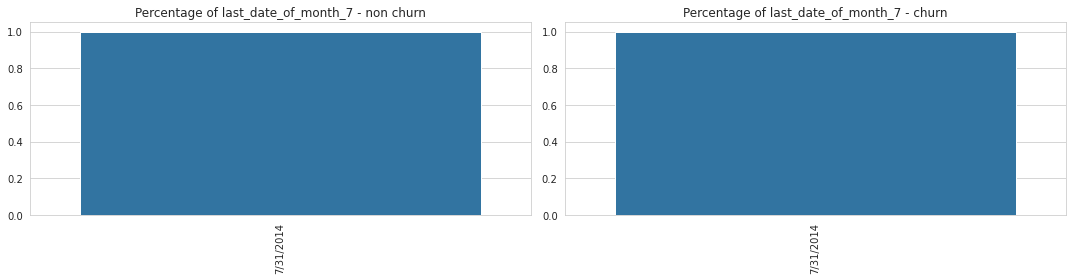

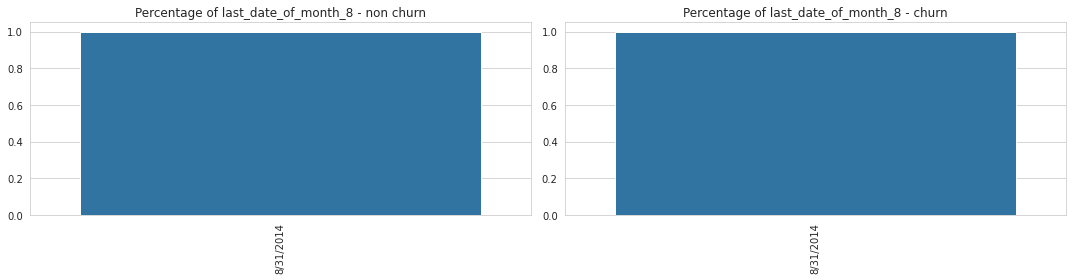

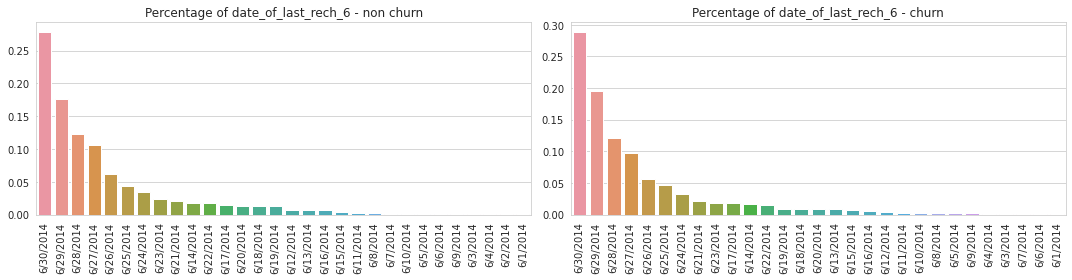

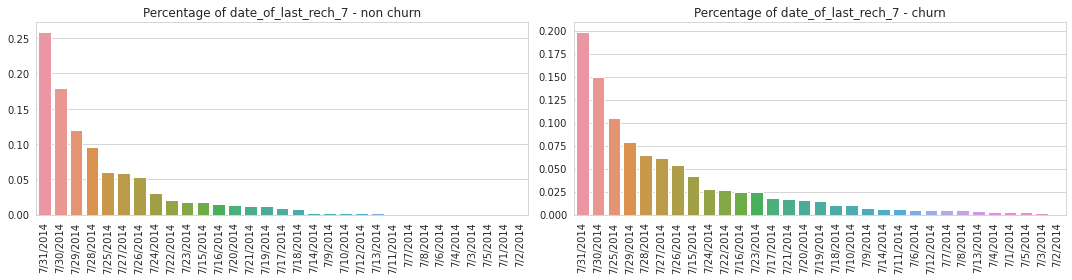

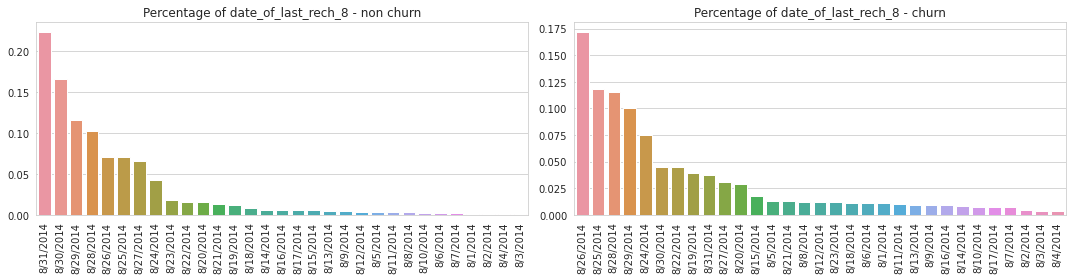

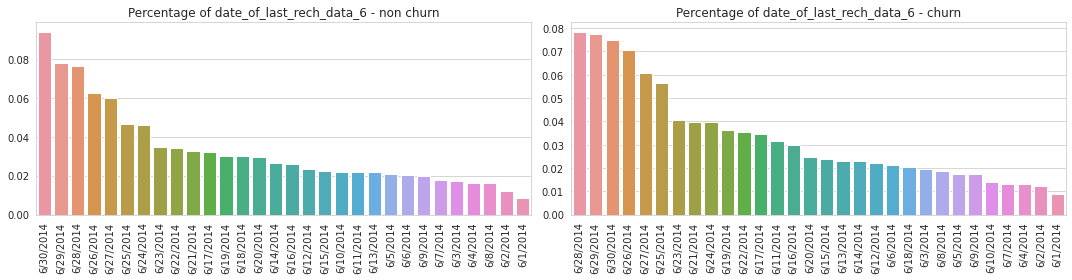

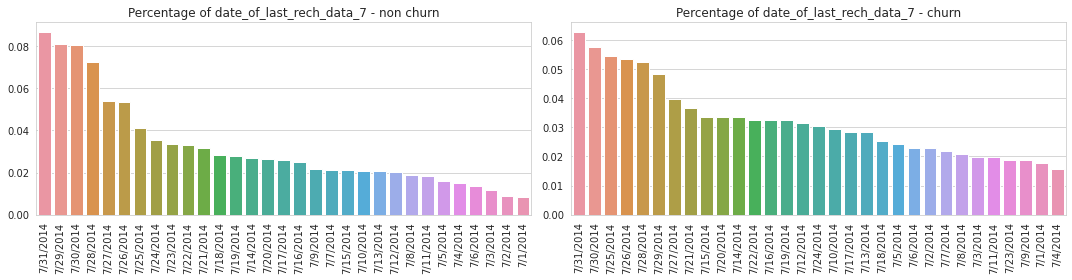

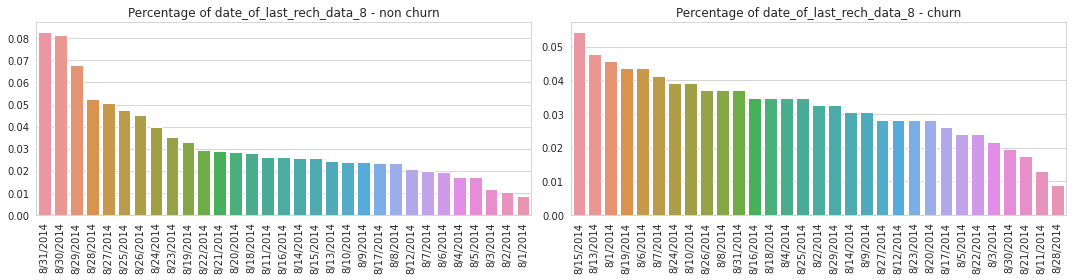

In [22]:
for col in date_col:
    cat_plot(df,col)

- We can see that `last_date_of_month` columns got only single value. We can drop them.
- We also see similar distribution pattern for other date columns for both churn & non-churn customers. Since we are there isn't much information in date column for our problem, we have decided to drop date columns in final model building.

#### Numerical Columns

In [23]:
# Function to plot distribution of numerical columns

def num_plot(df,col):
    plt.figure(figsize=(15,4))
    sns.set_style("whitegrid")

    sns.distplot(df[df["churn"]==0][col], label="non churn")
    sns.distplot(df[df["churn"]==1][col], label="churn")
    plt.title(f"Distribution of {col}")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

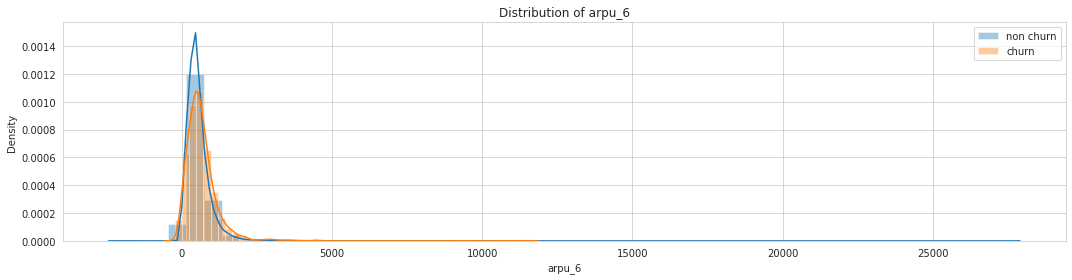

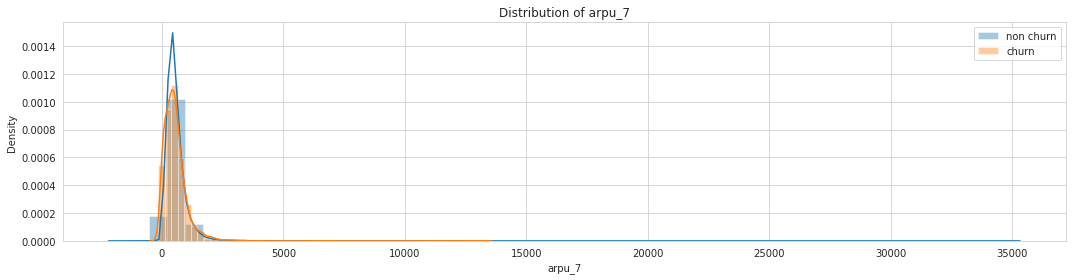

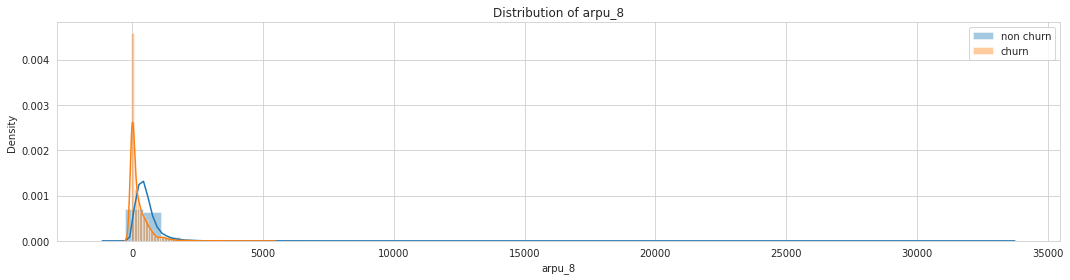

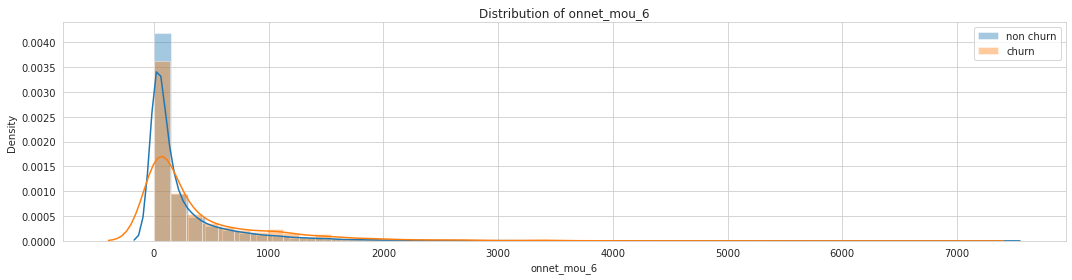

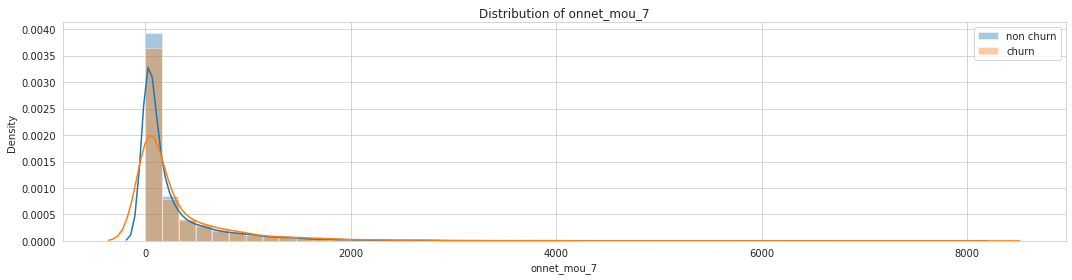

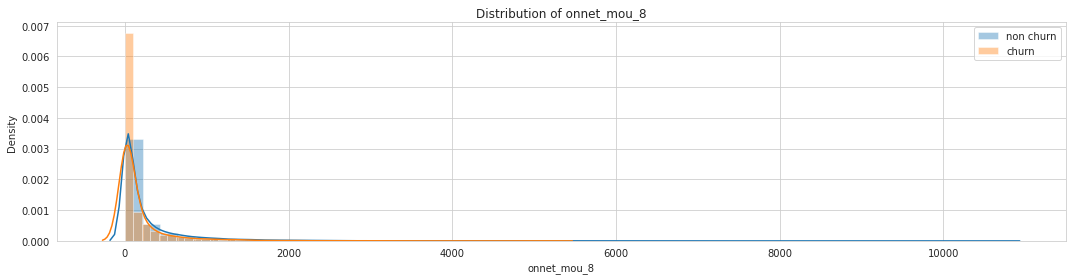

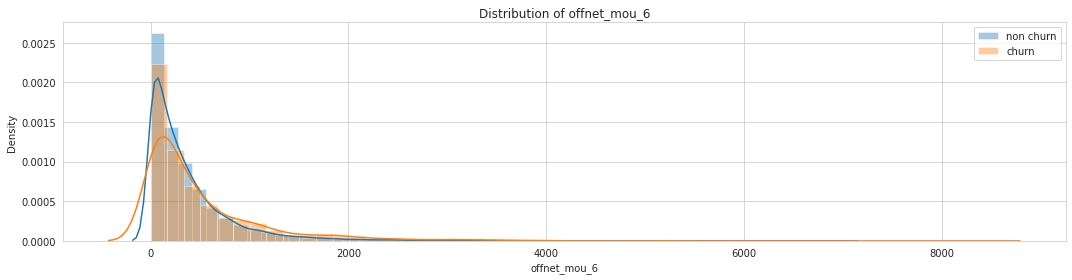

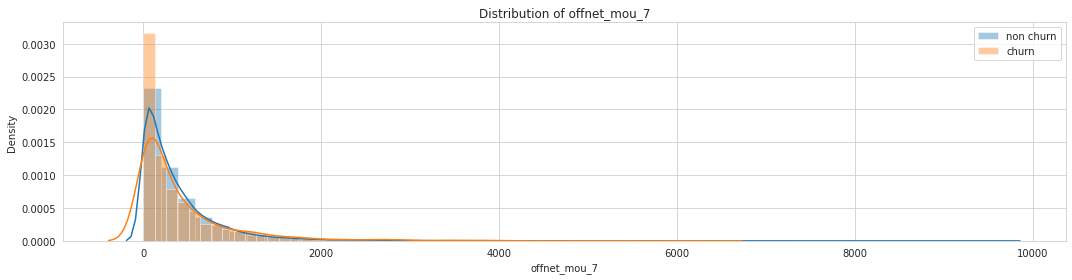

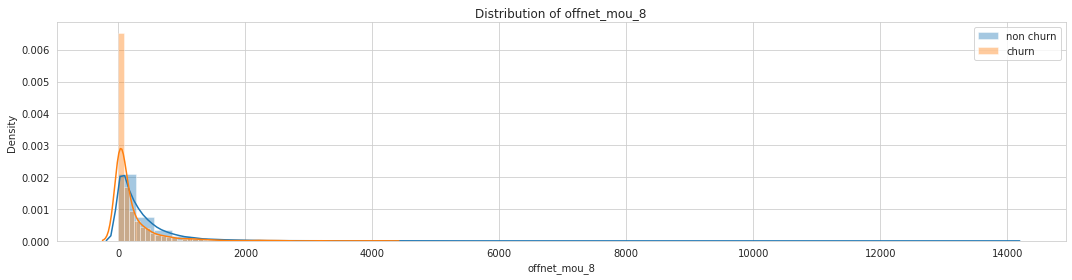

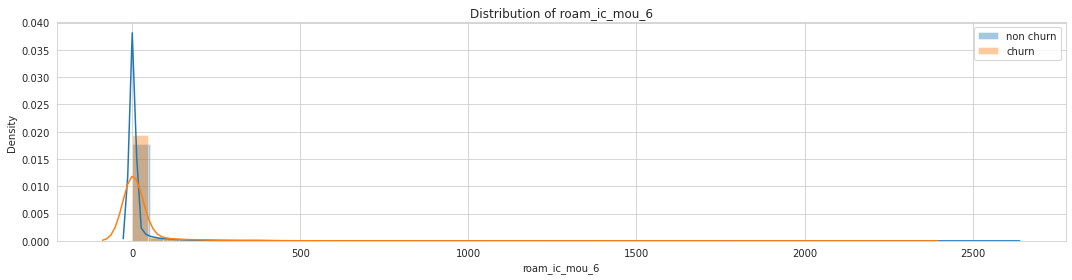

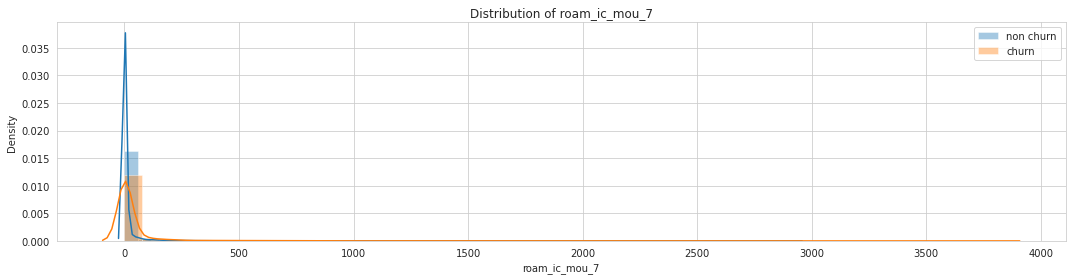

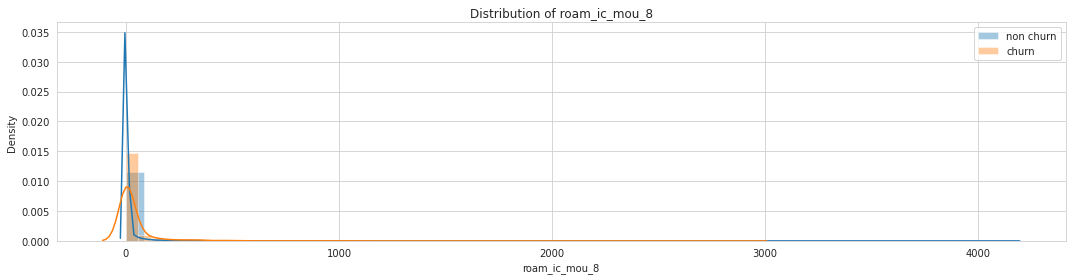

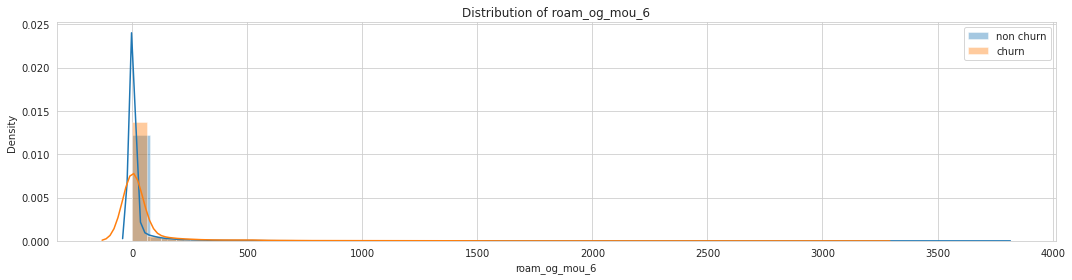

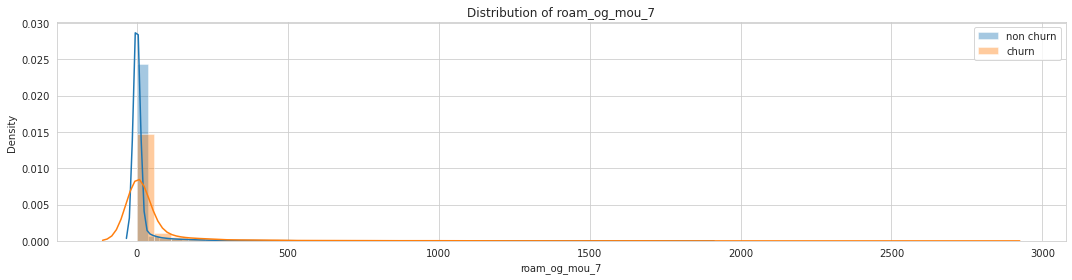

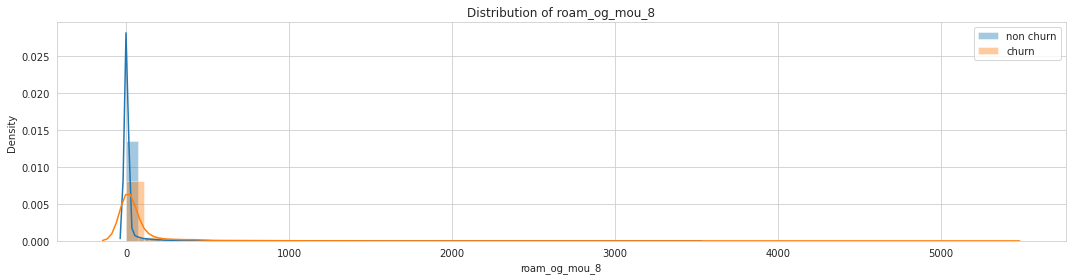

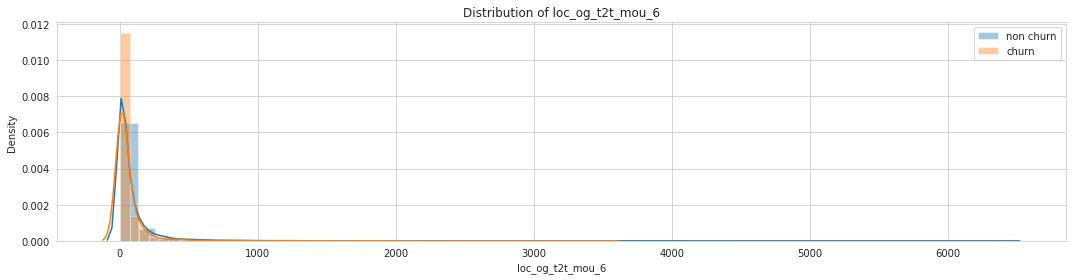

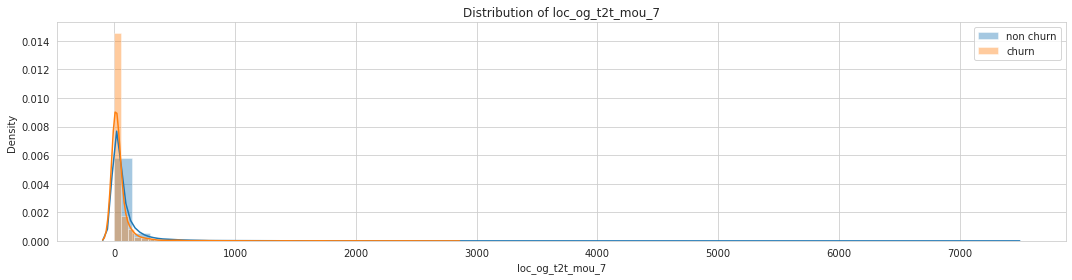

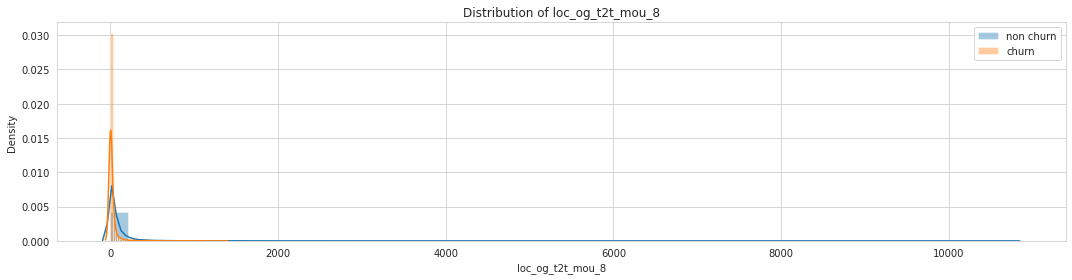

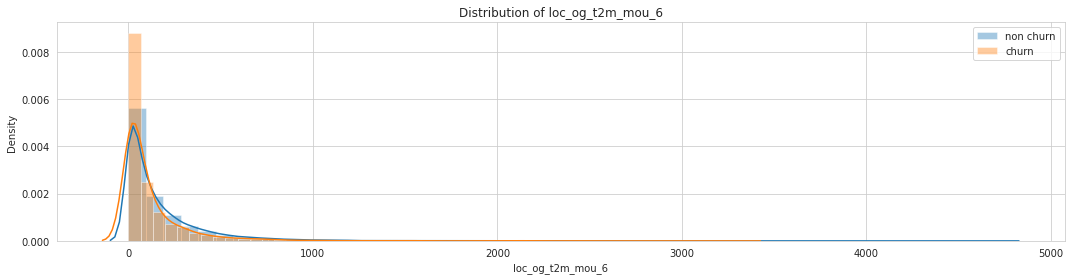

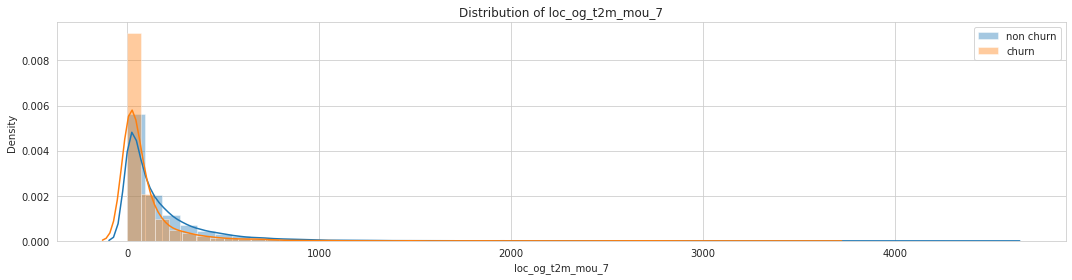

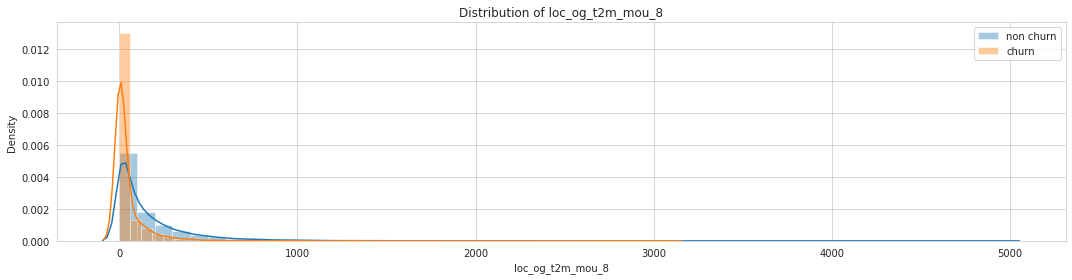

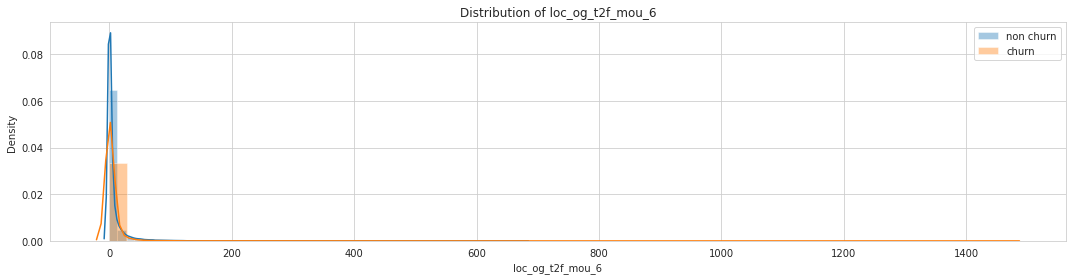

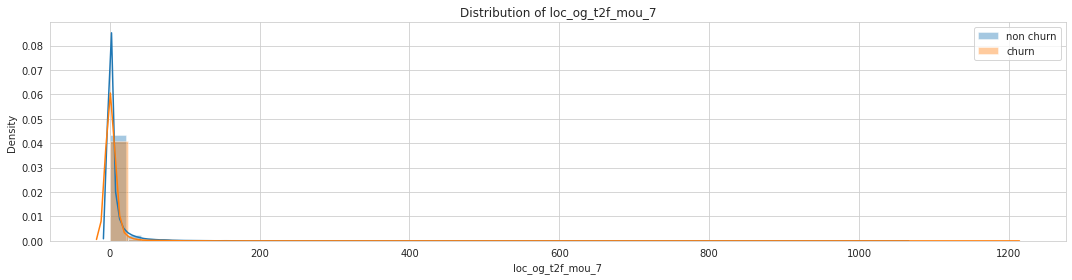

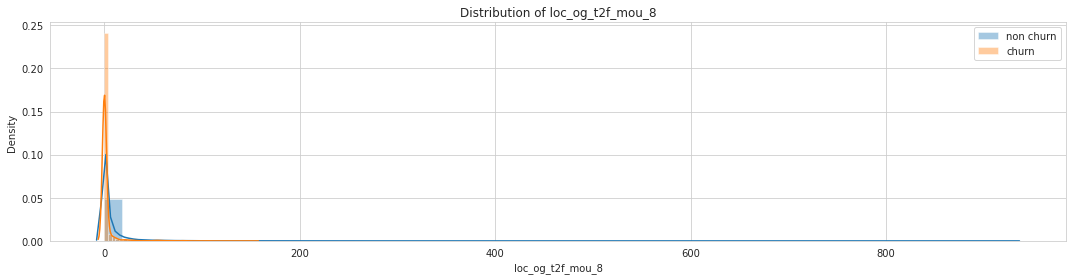

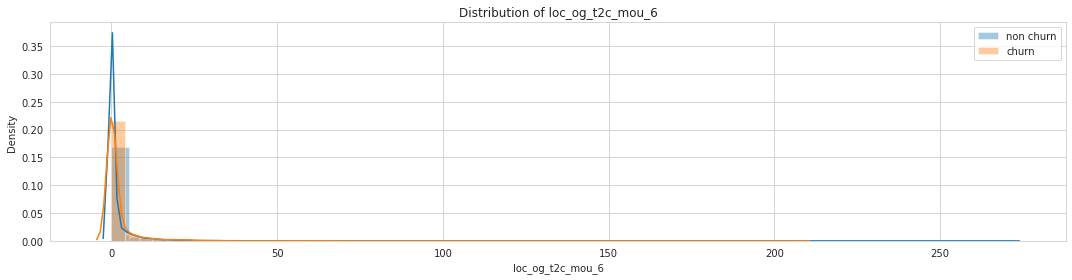

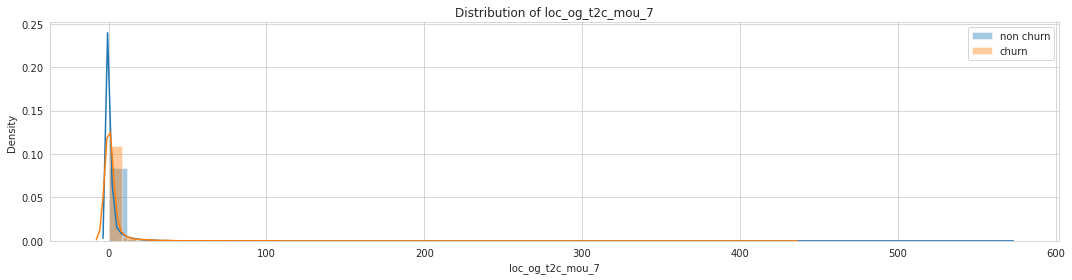

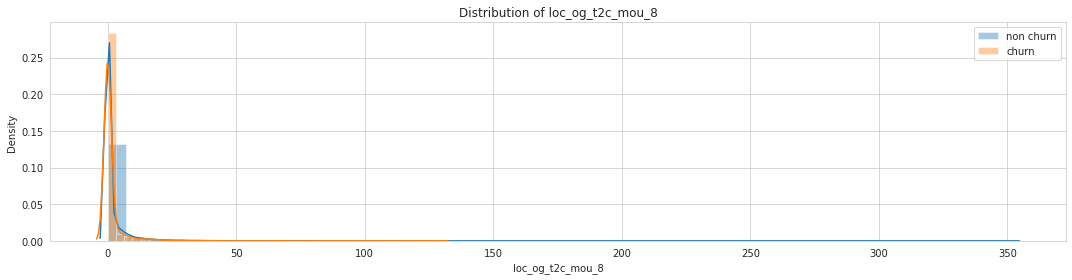

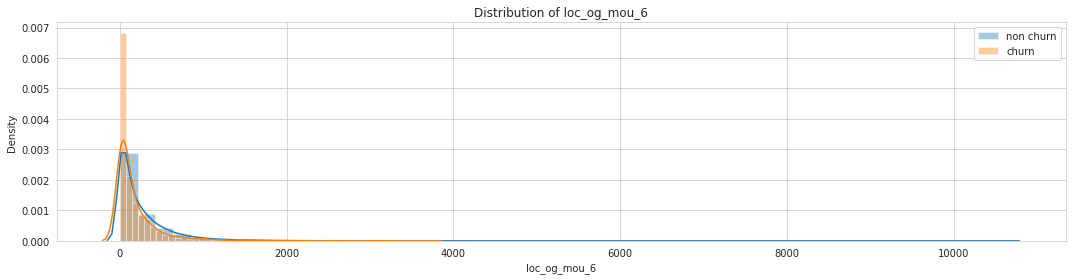

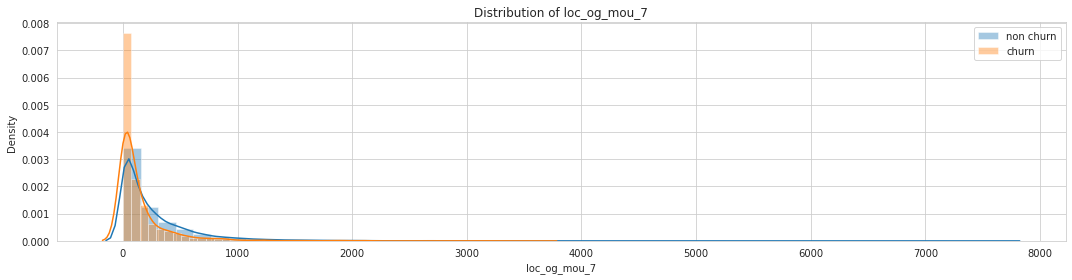

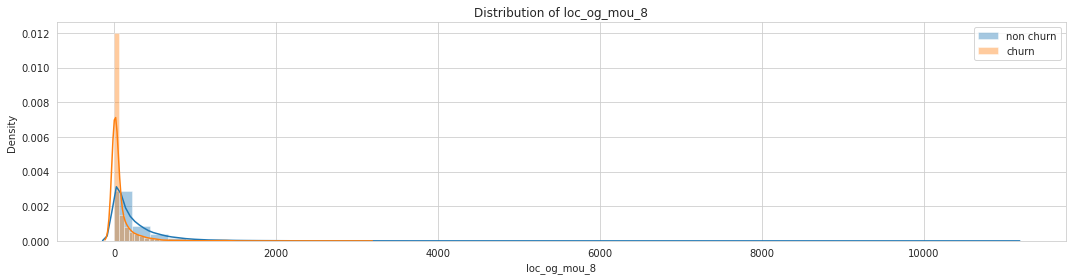

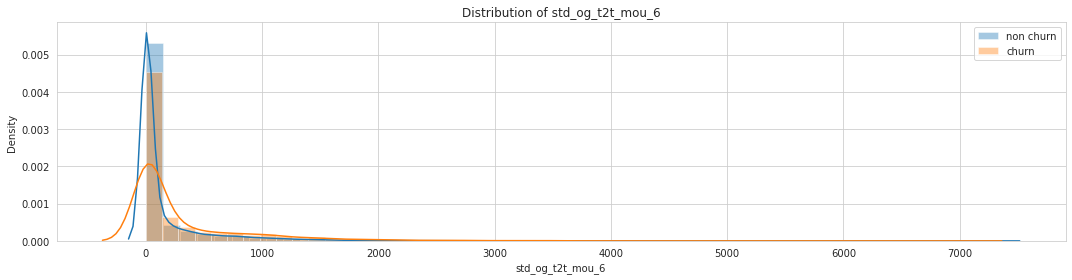

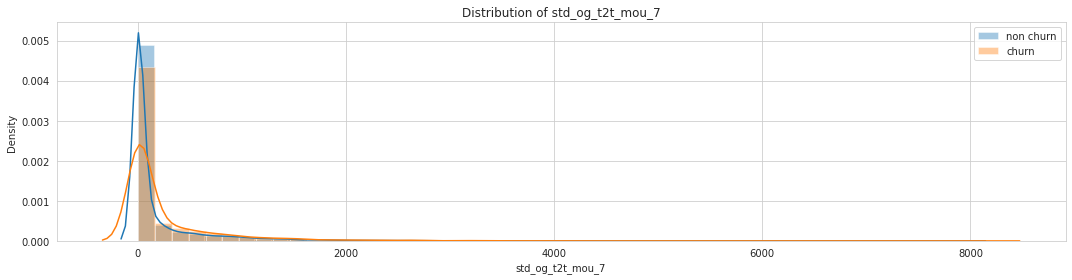

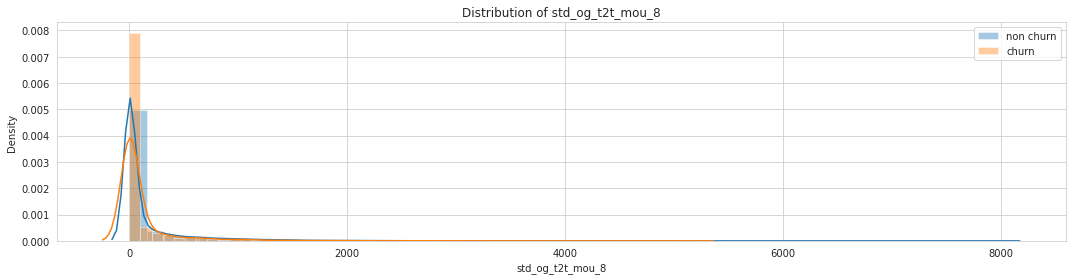

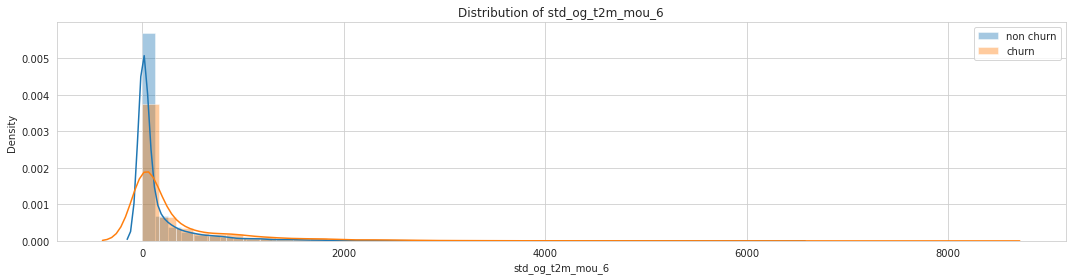

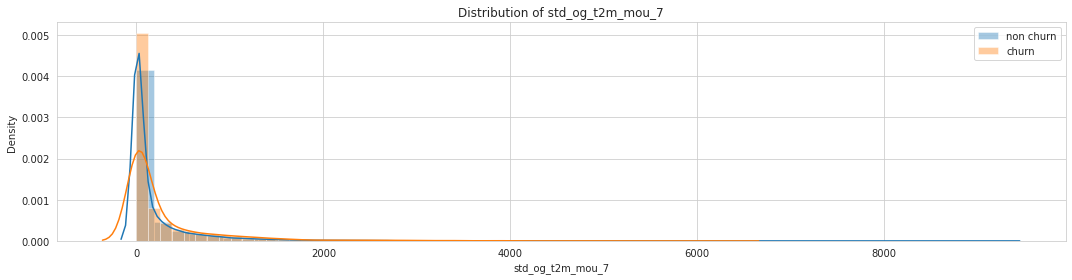

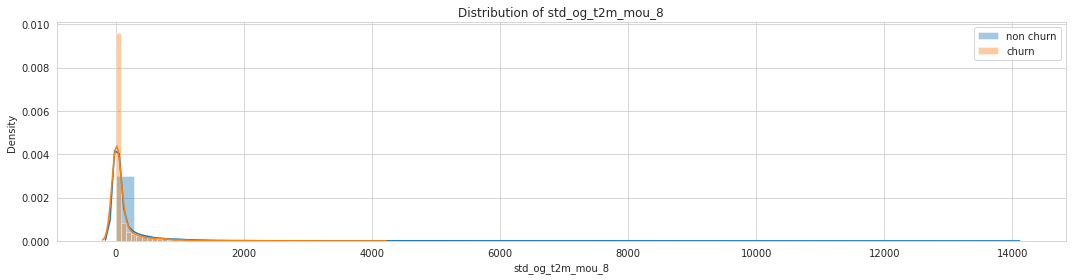

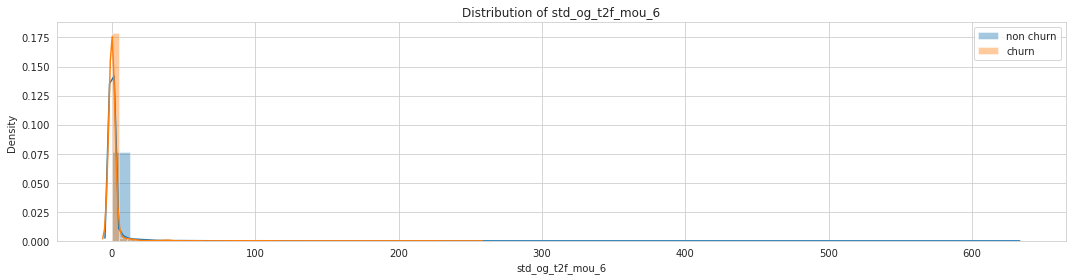

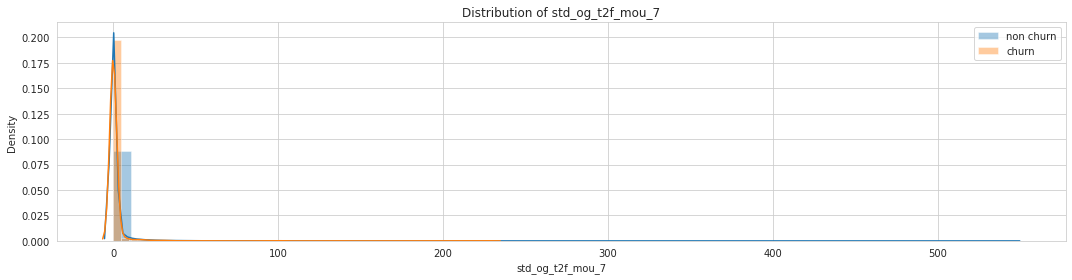

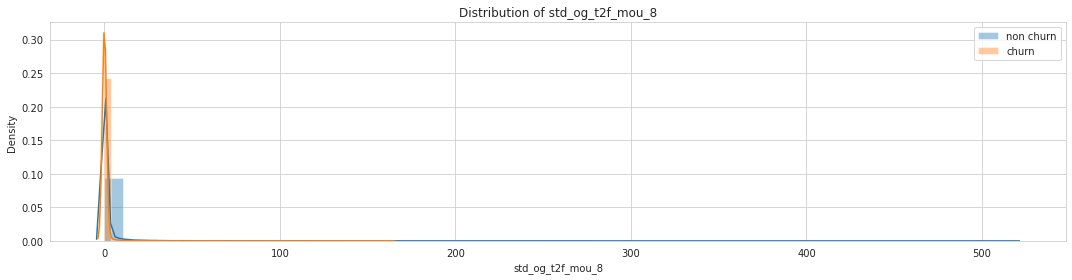

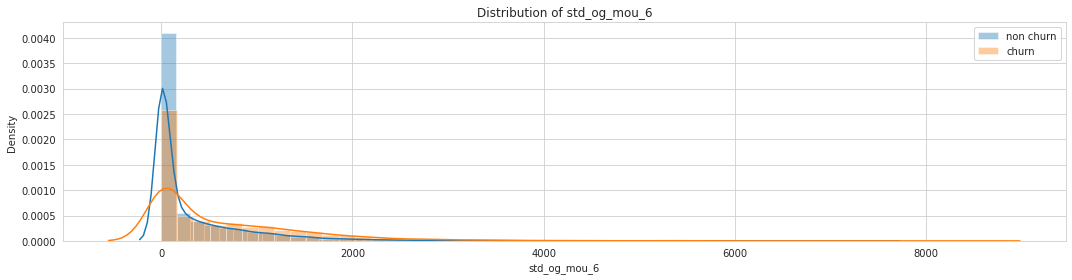

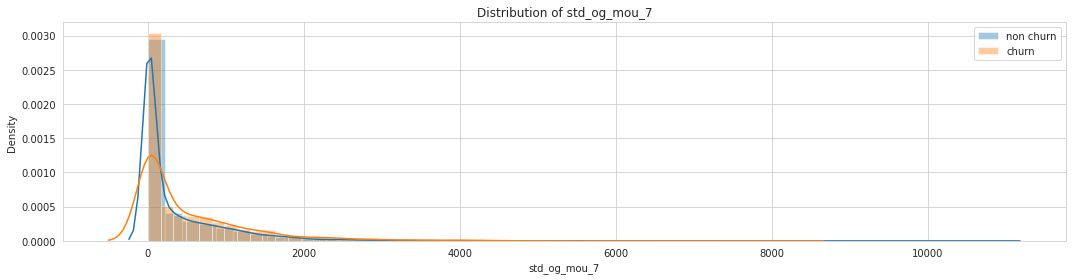

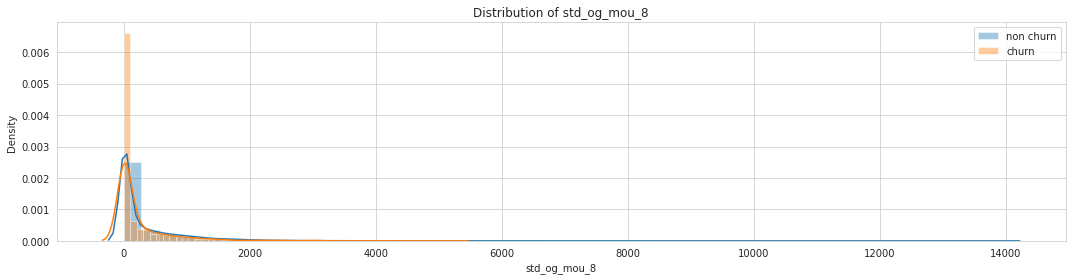

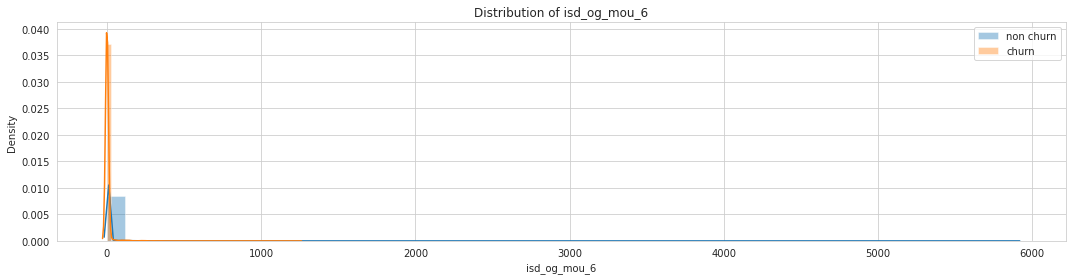

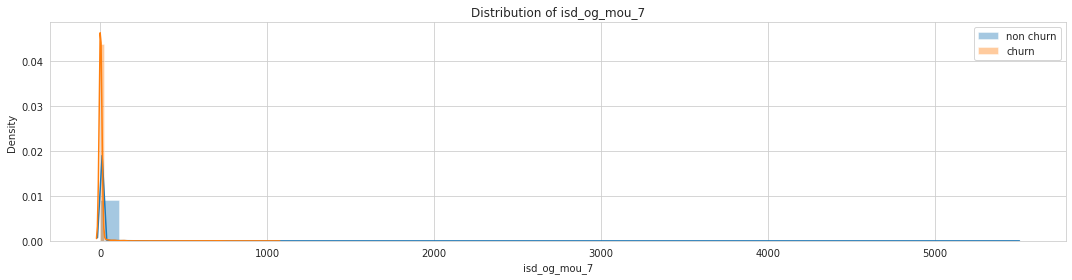

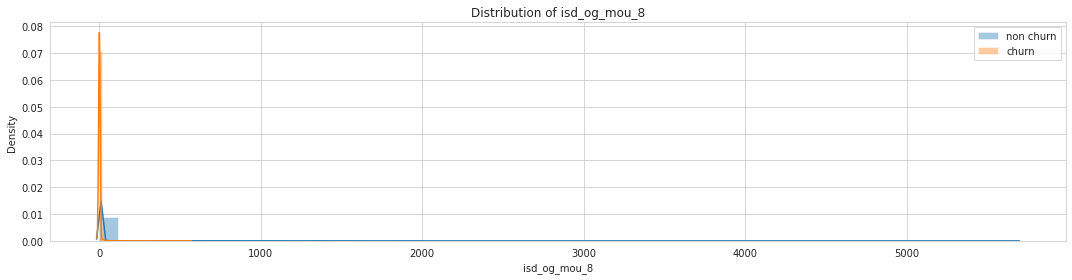

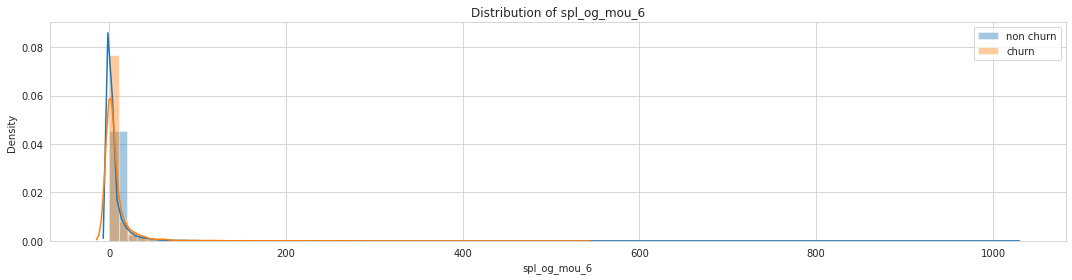

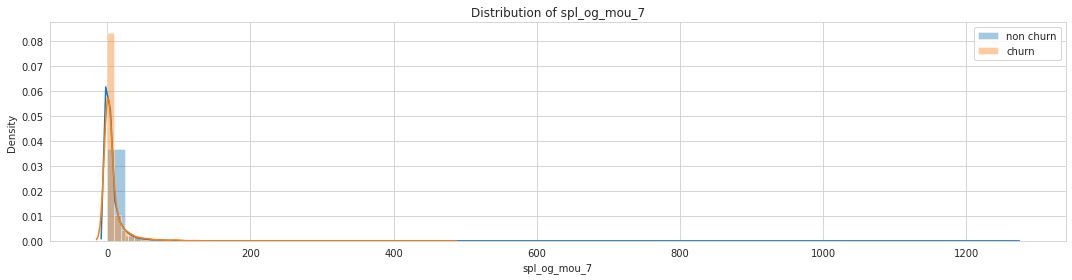

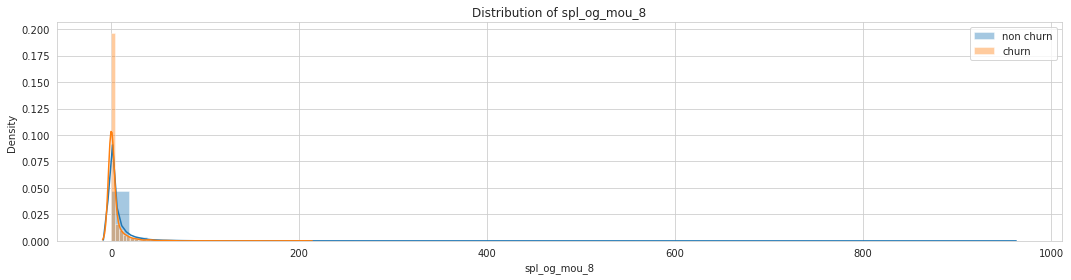

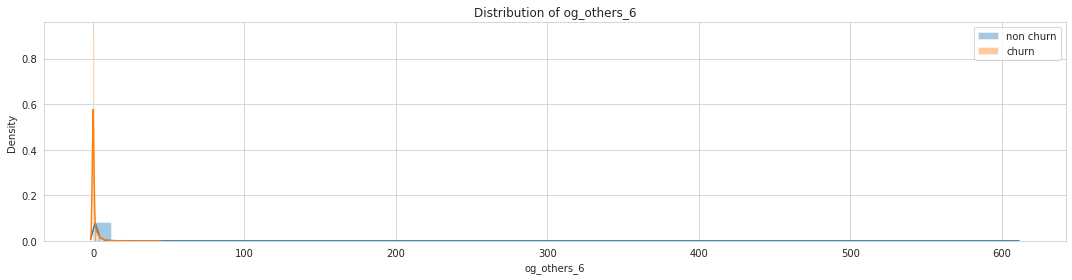

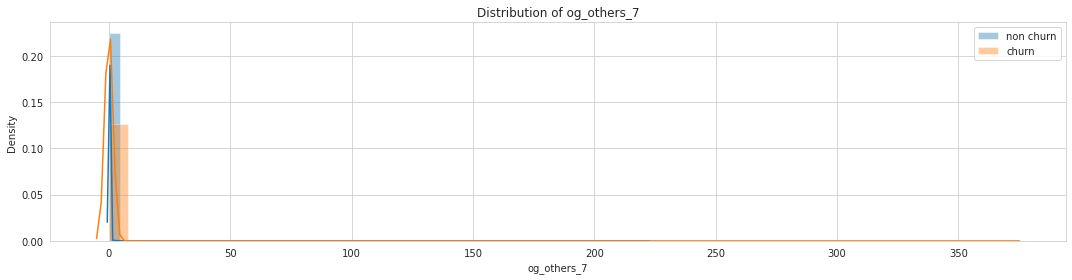

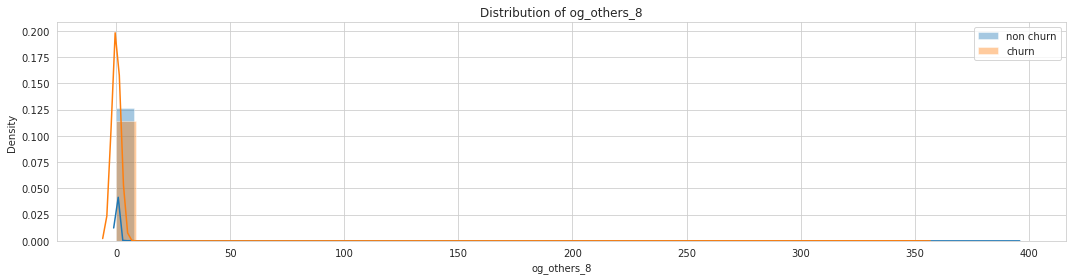

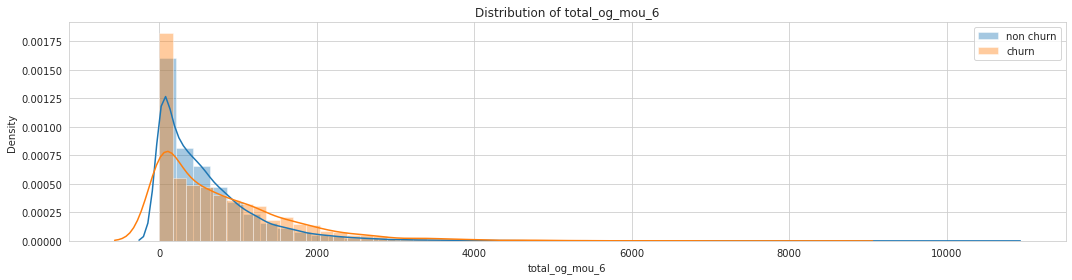

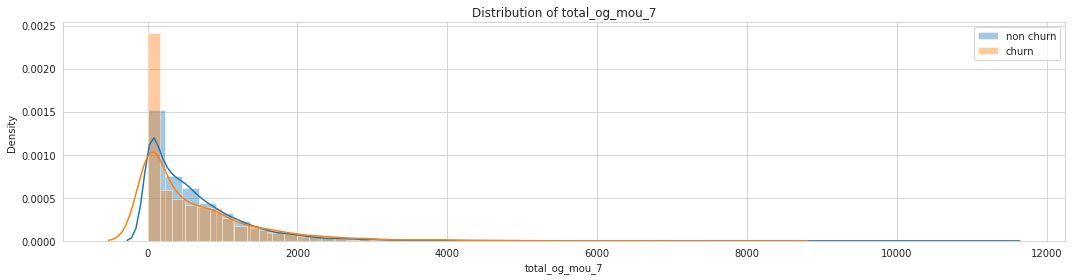

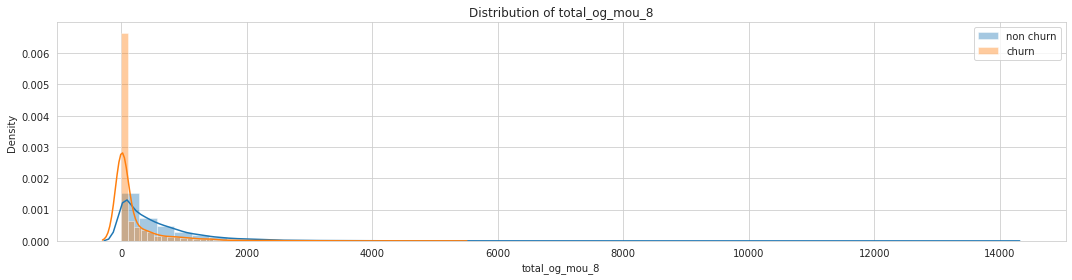

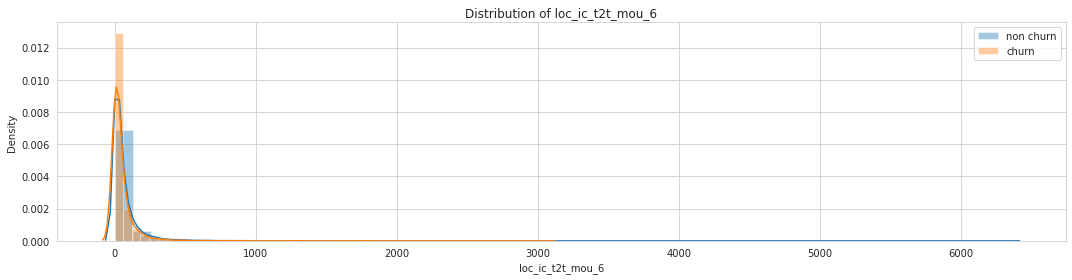

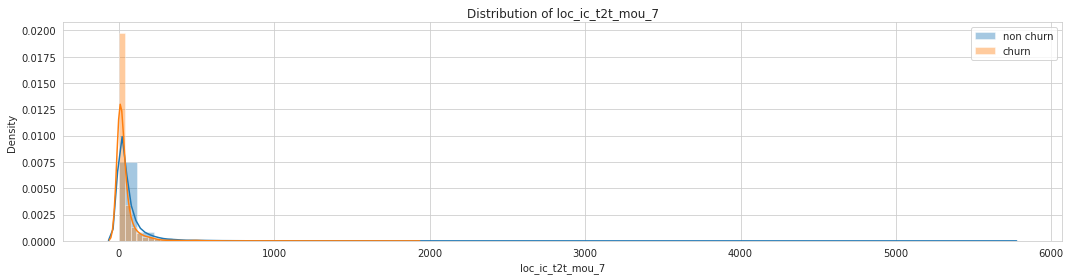

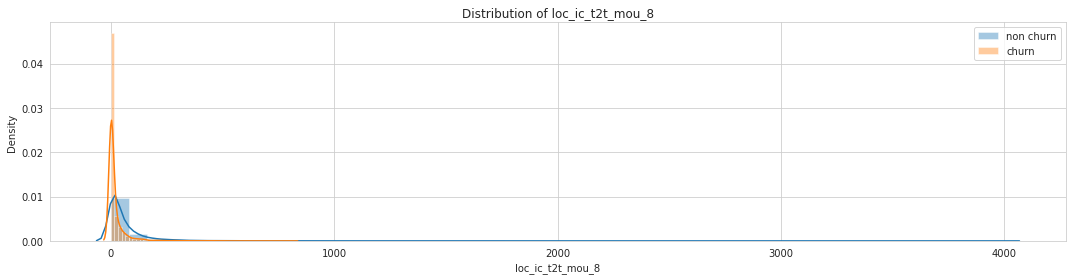

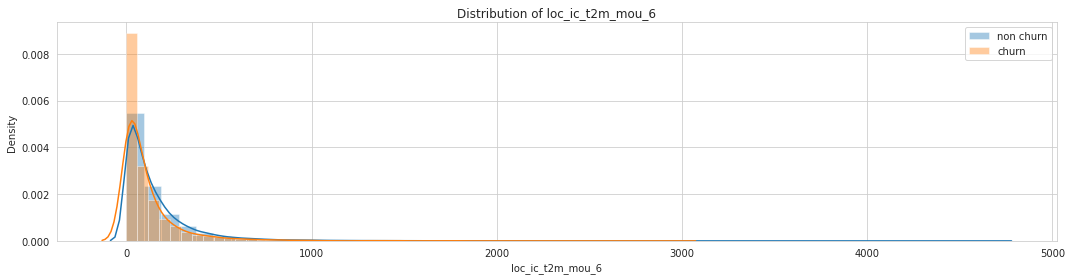

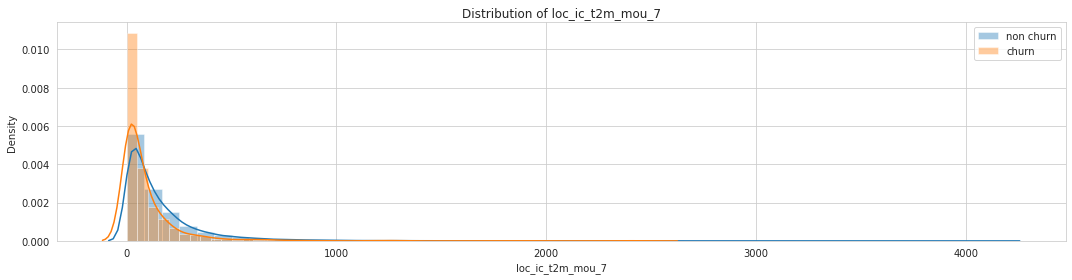

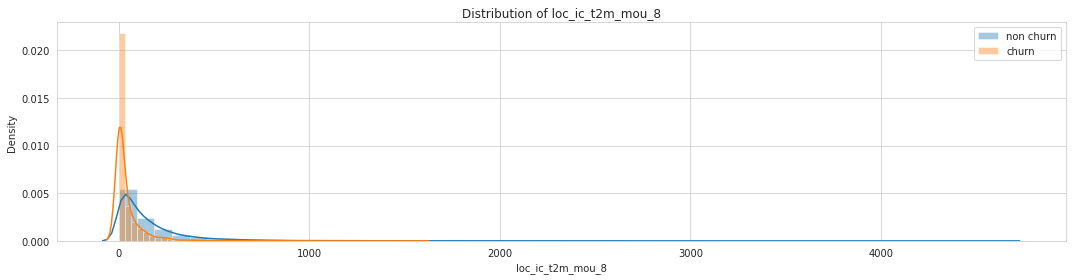

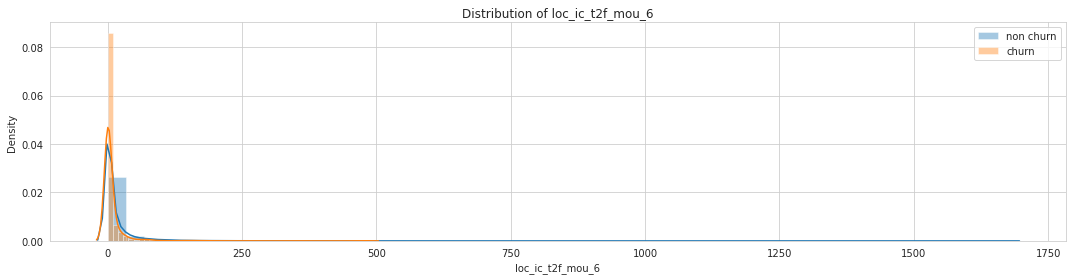

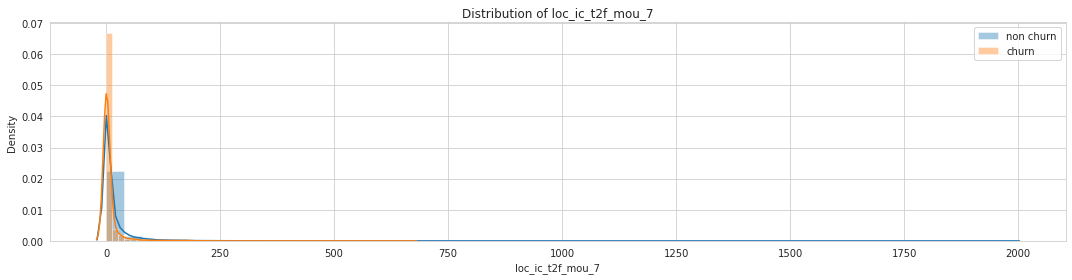

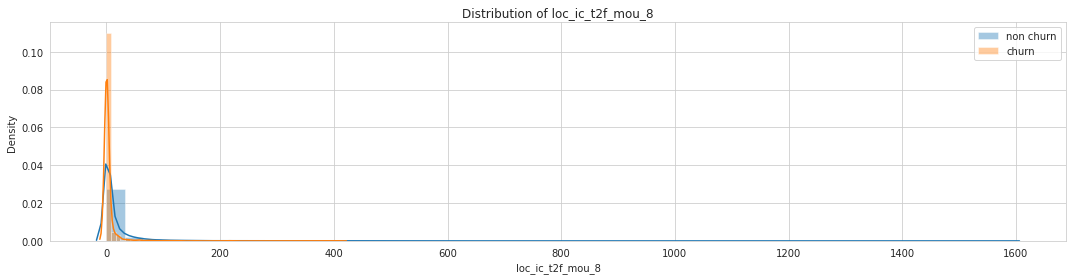

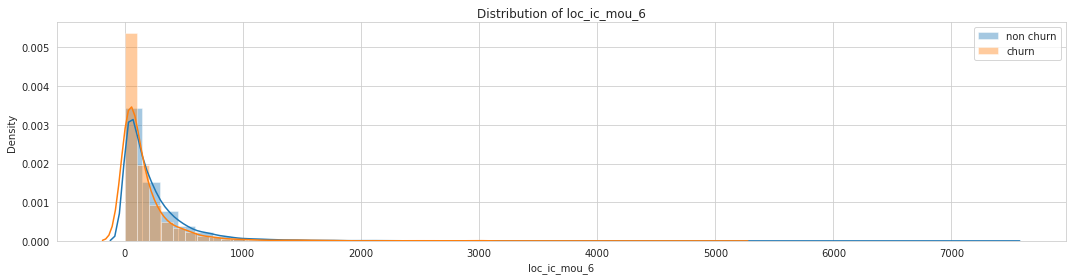

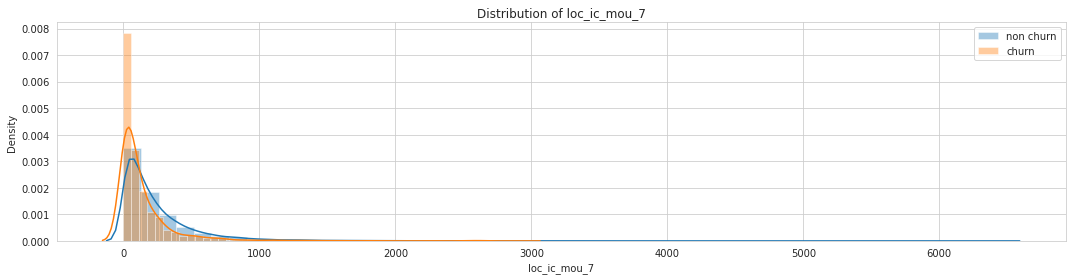

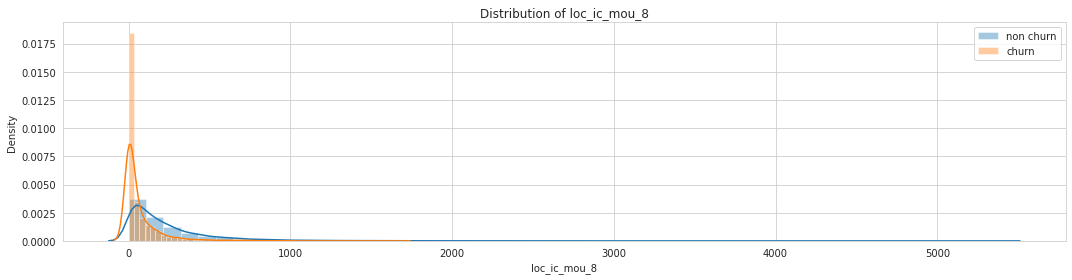

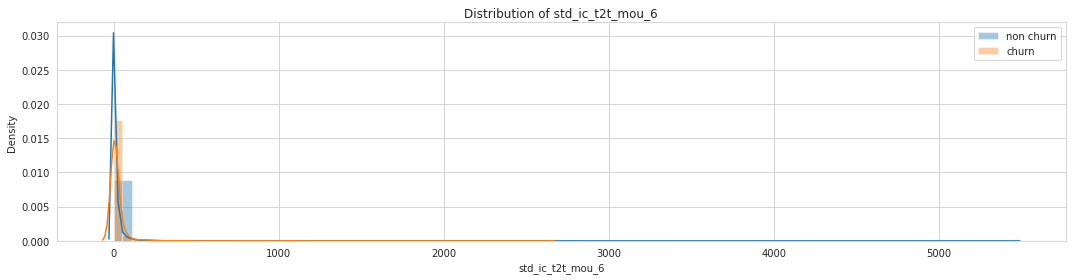

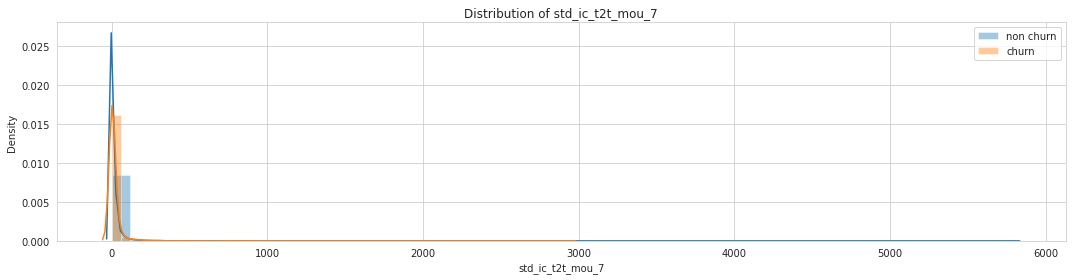

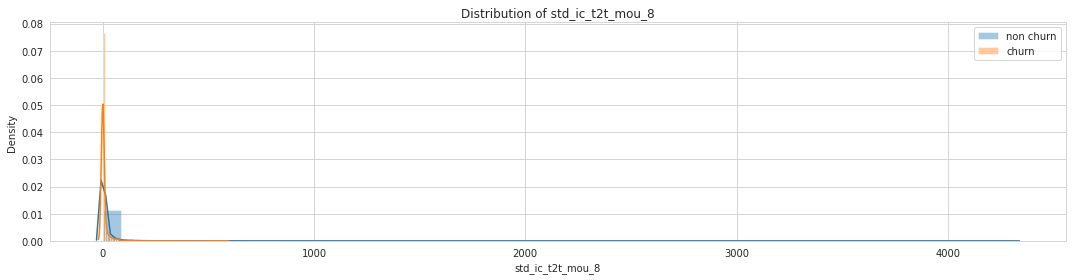

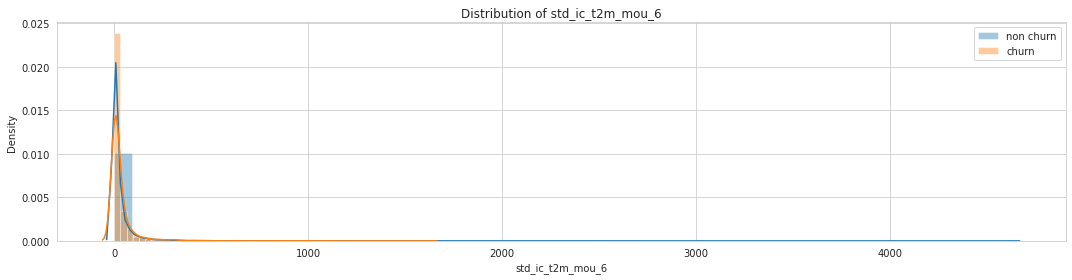

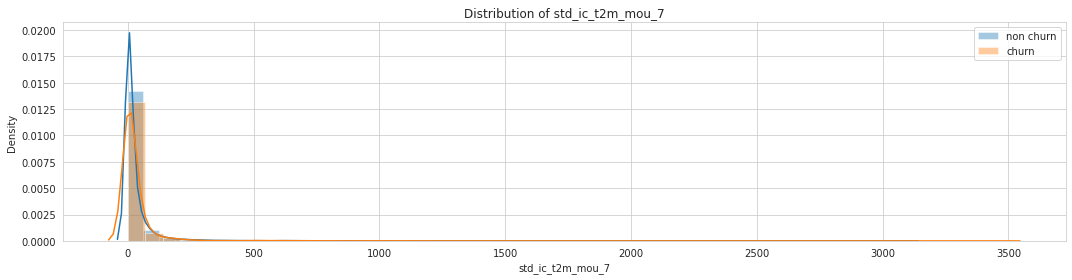

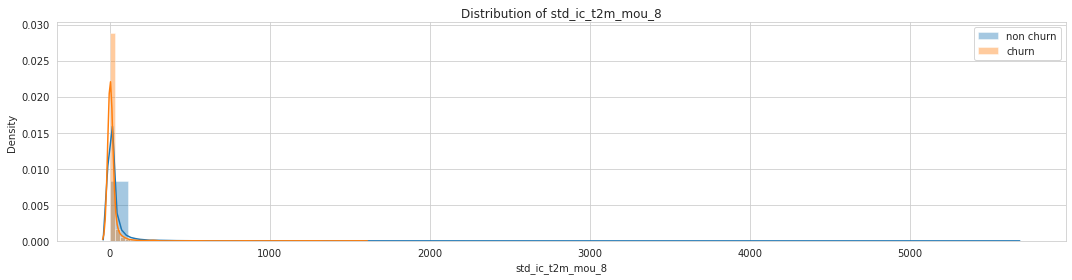

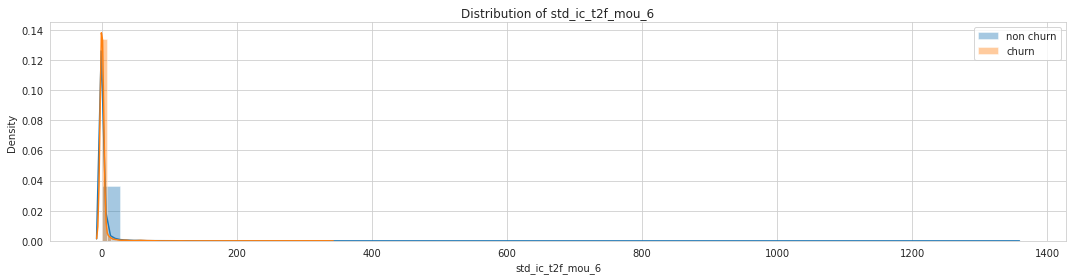

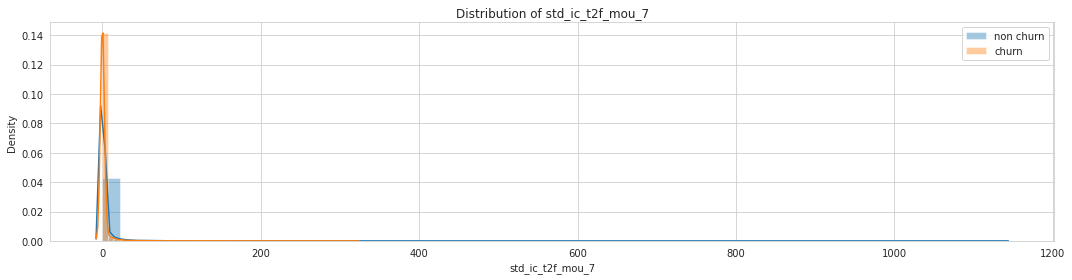

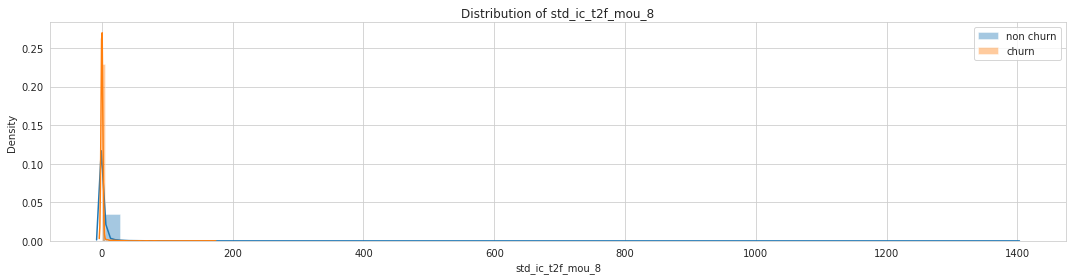

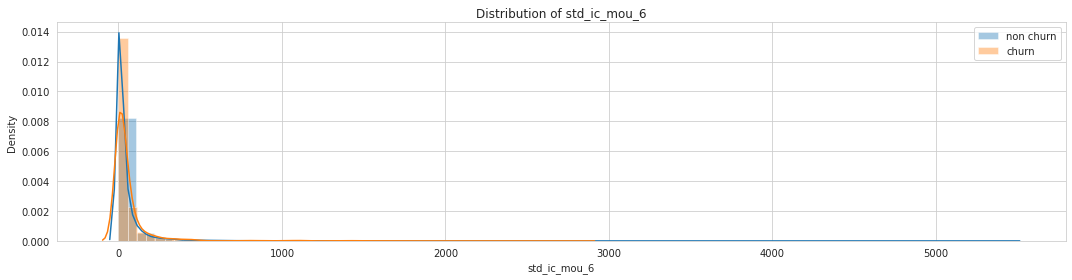

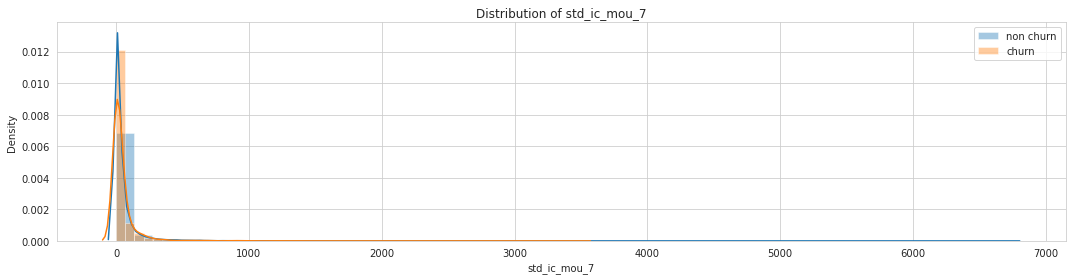

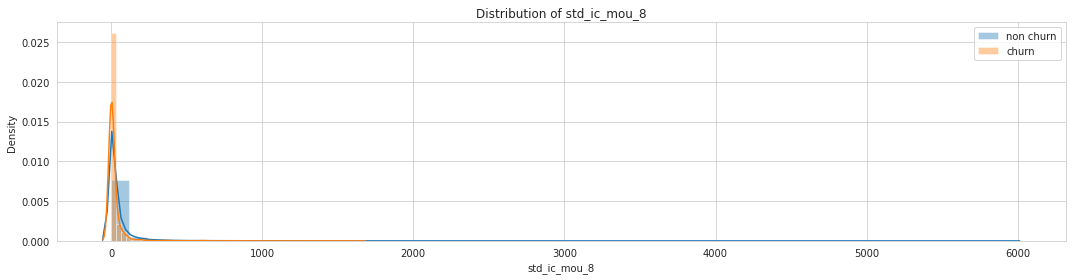

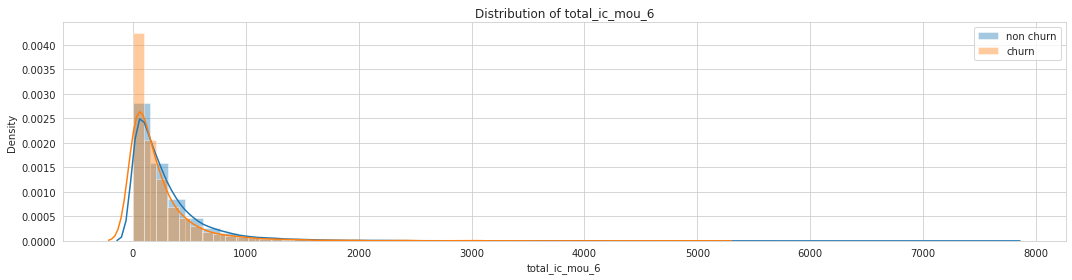

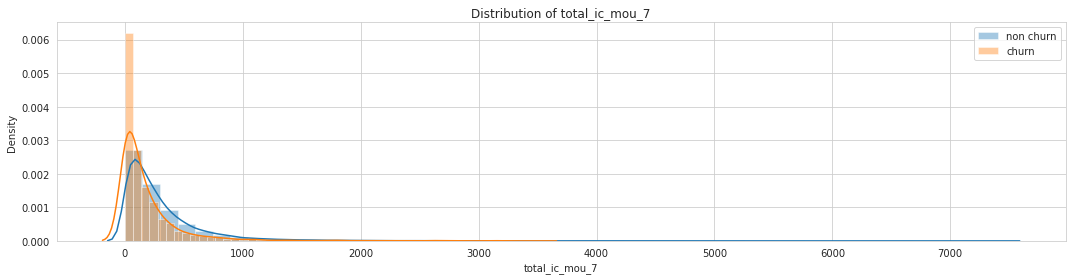

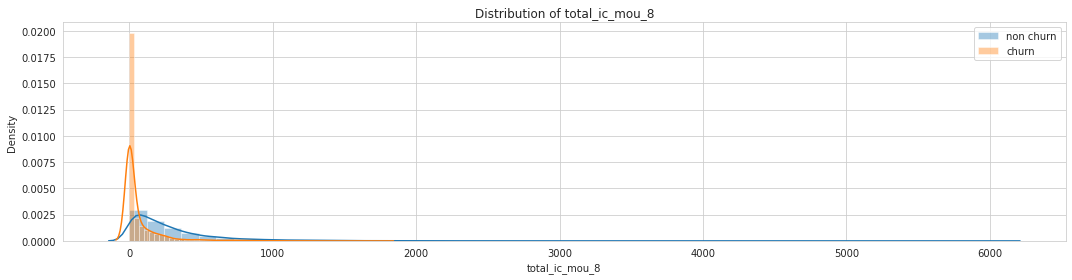

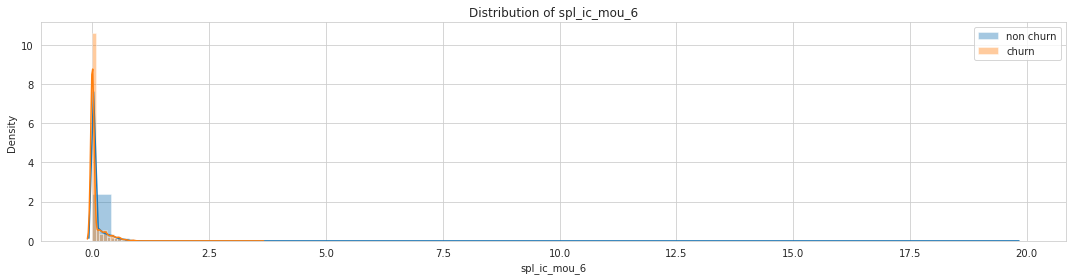

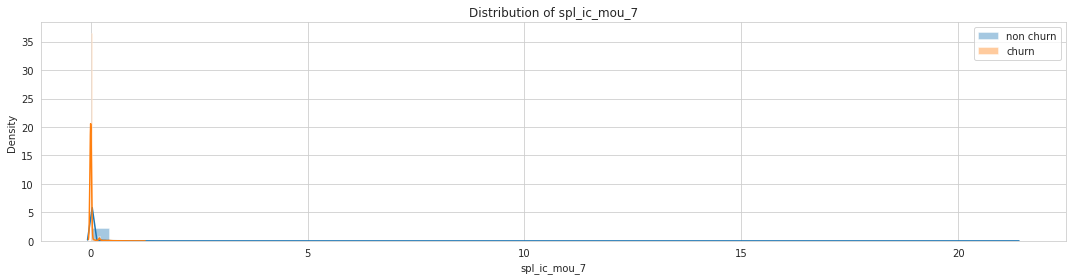

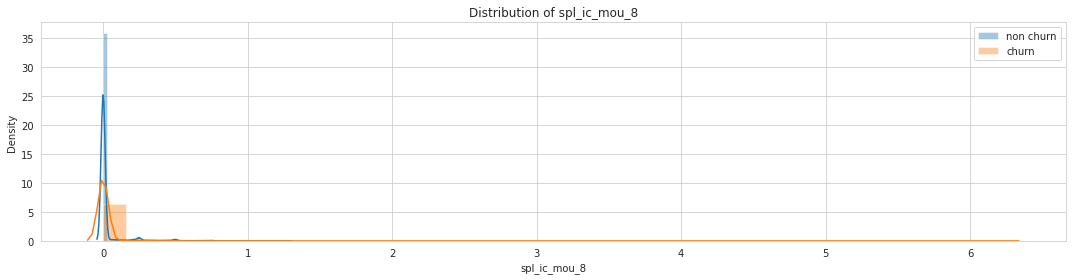

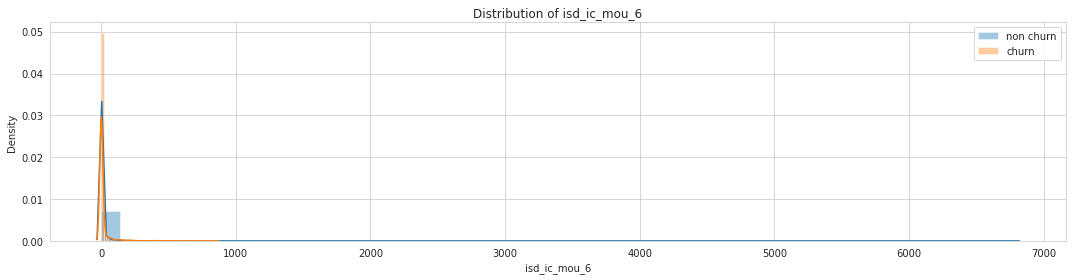

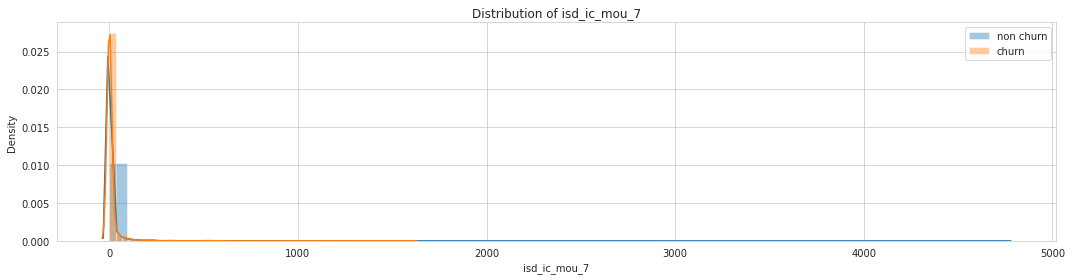

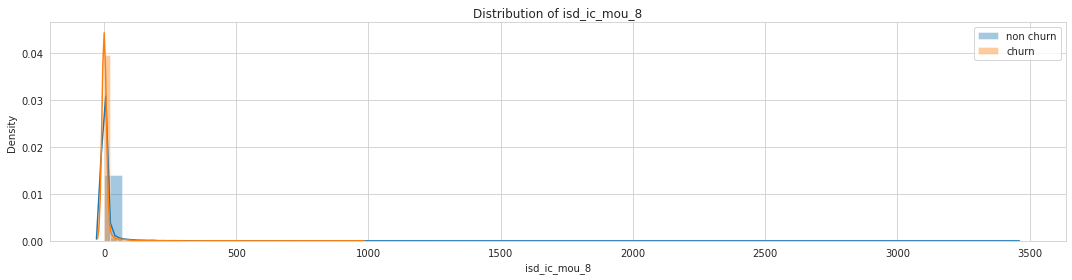

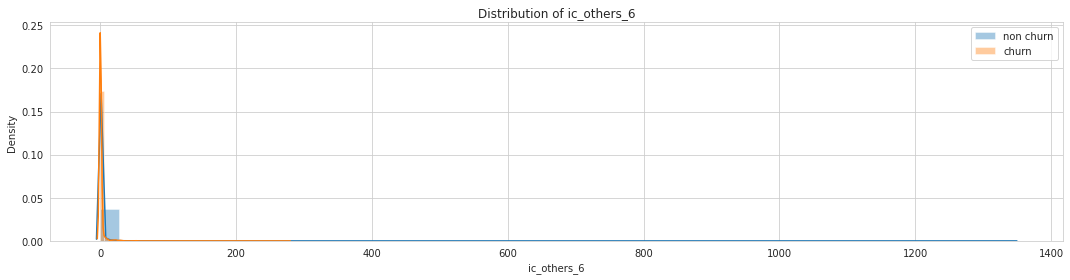

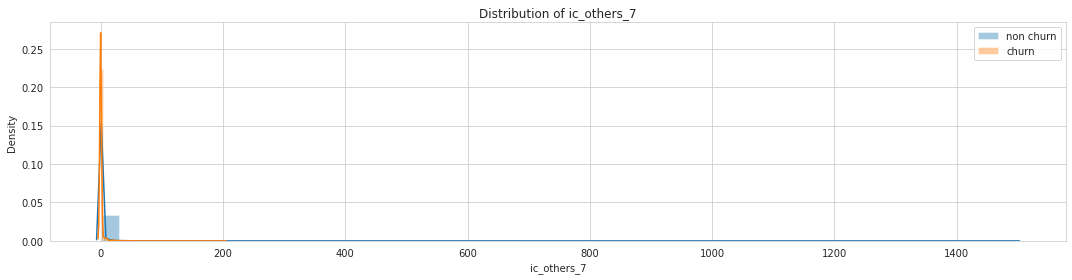

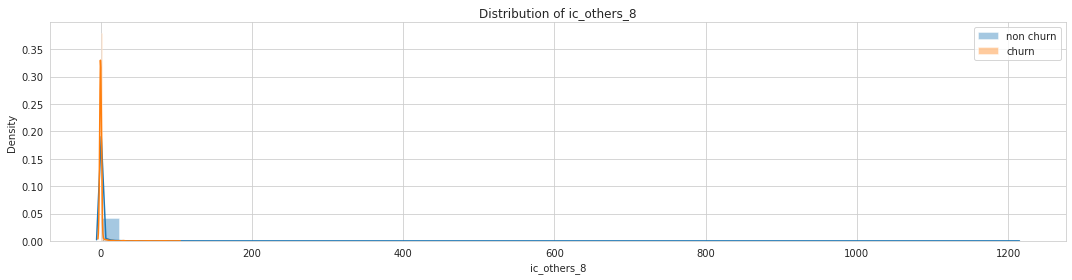

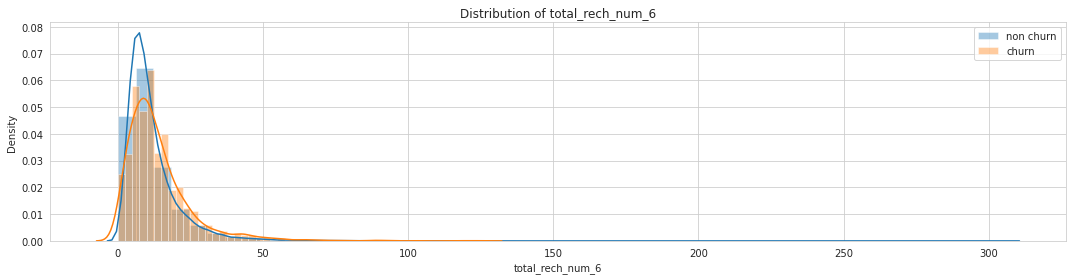

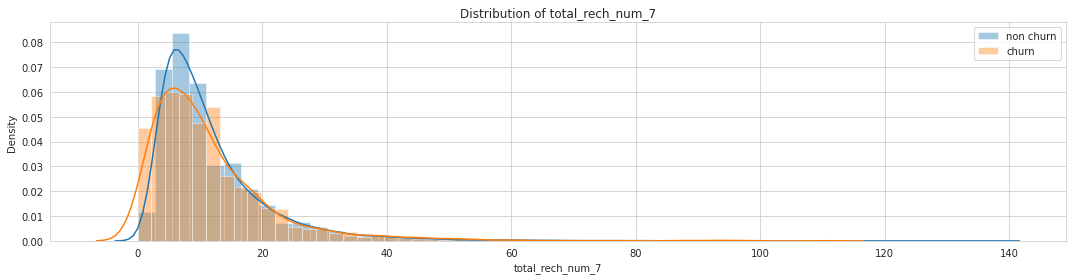

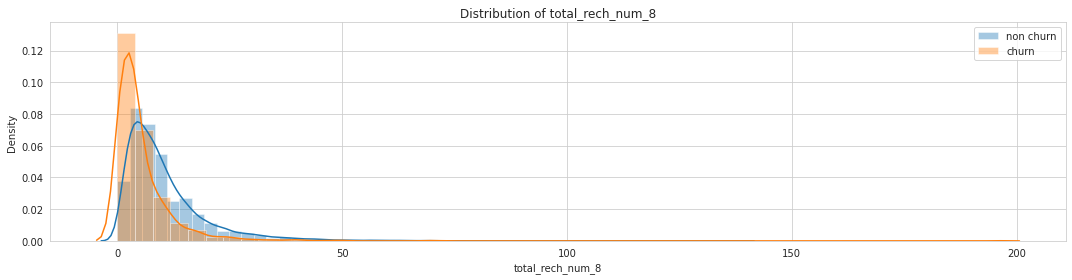

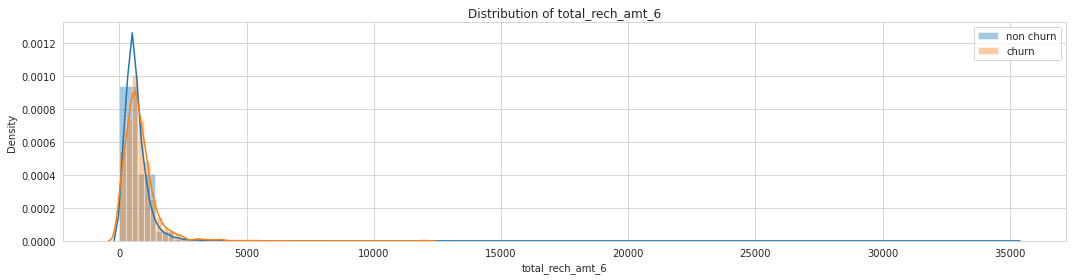

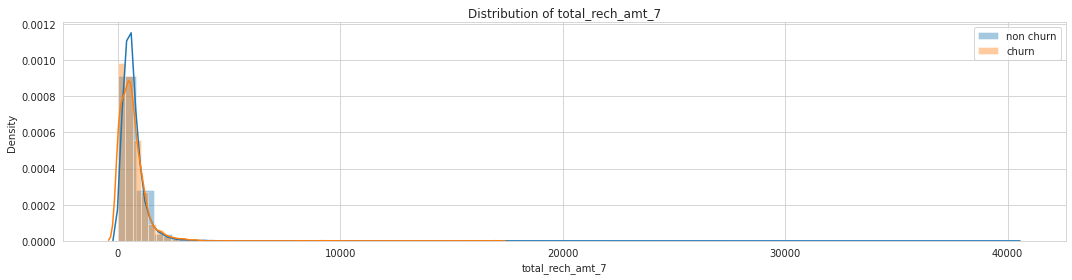

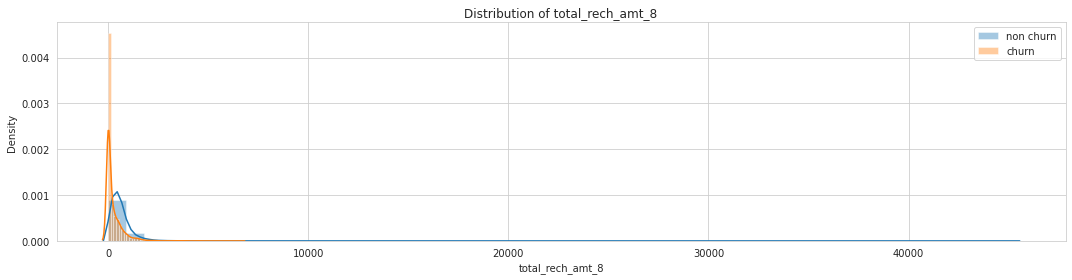

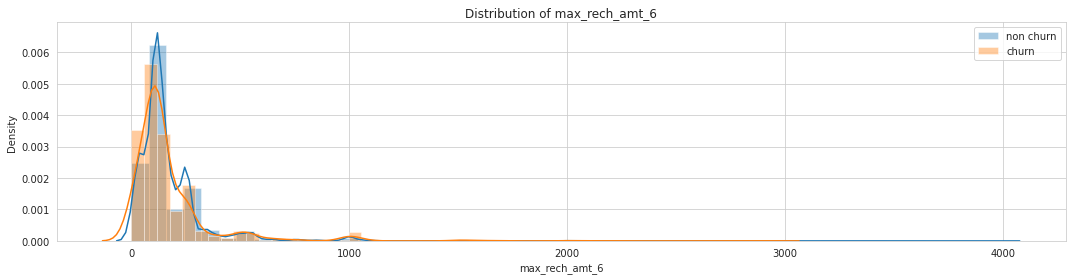

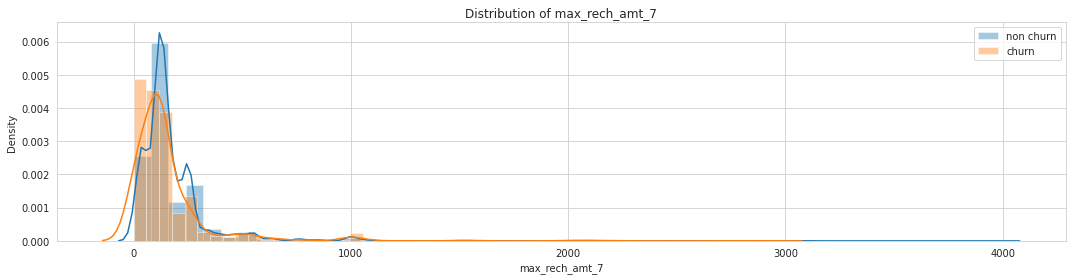

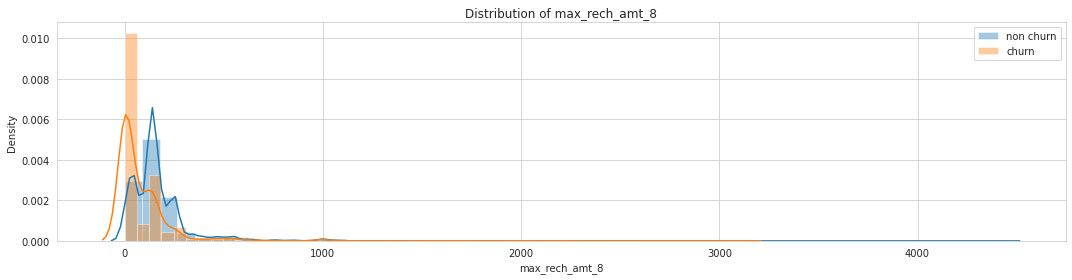

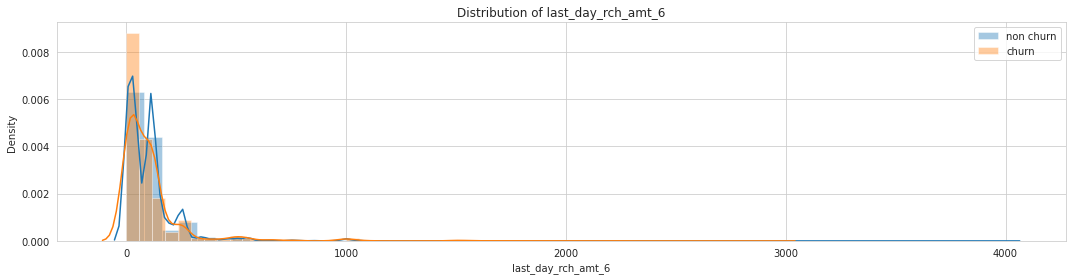

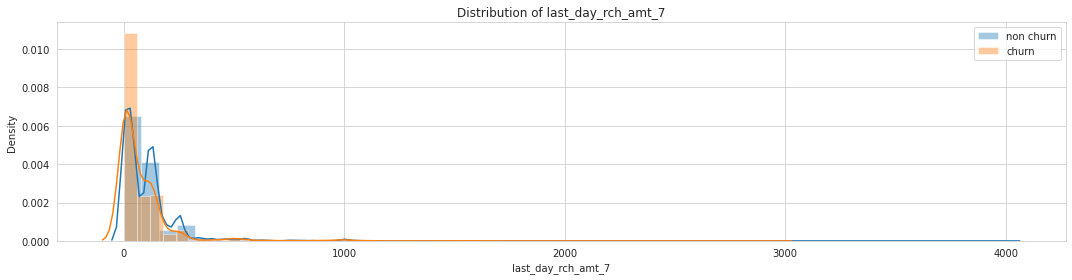

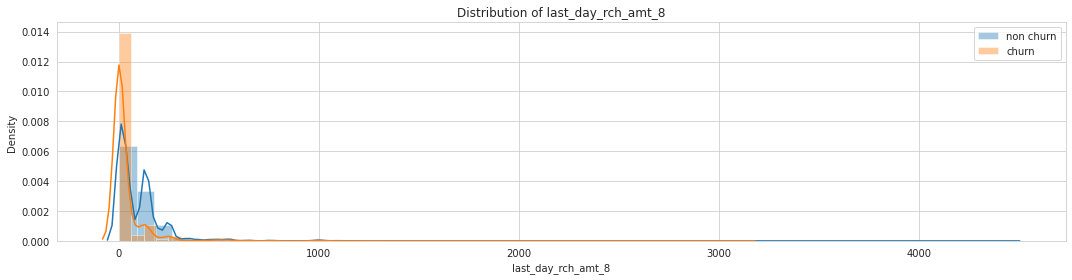

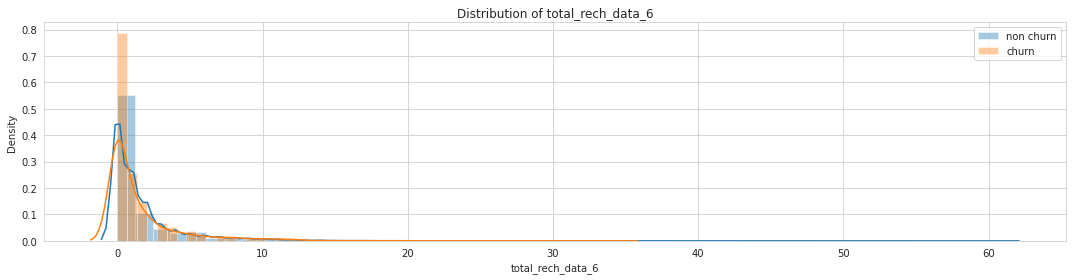

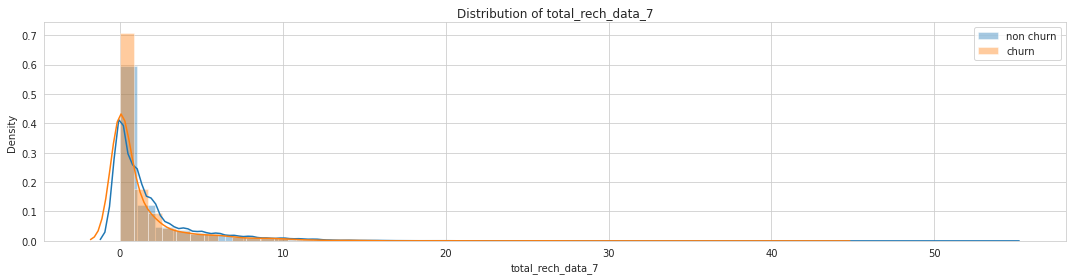

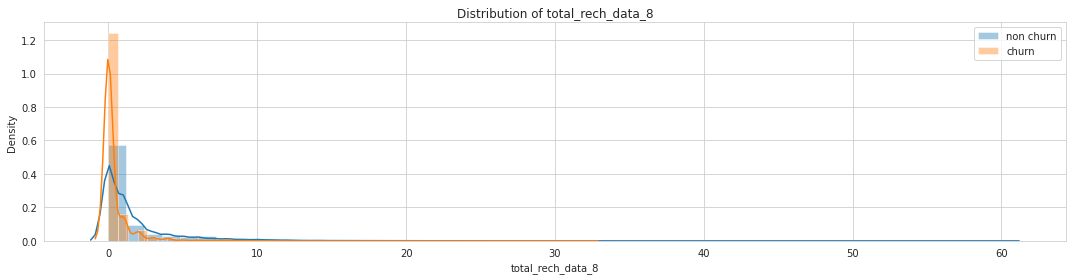

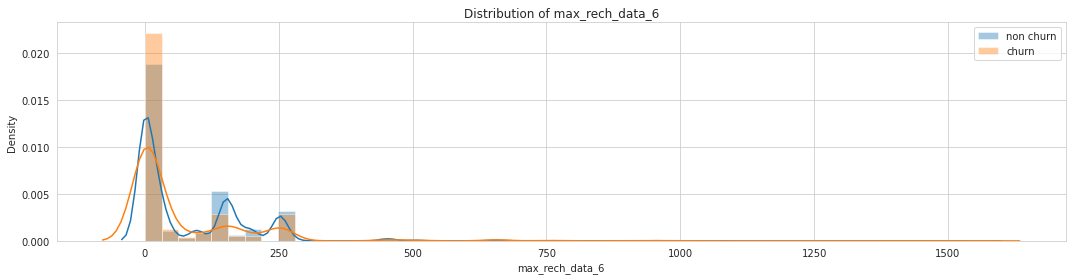

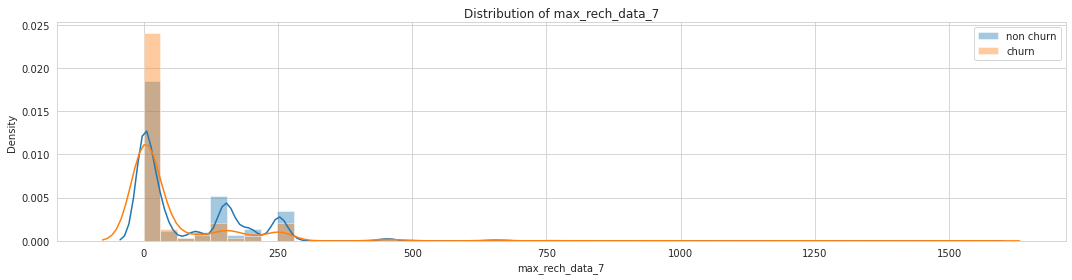

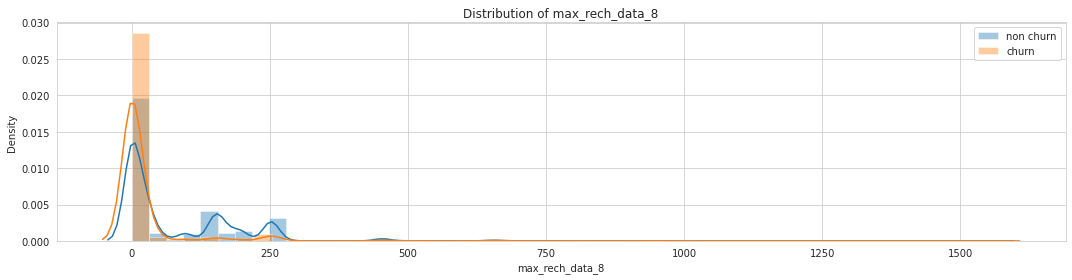

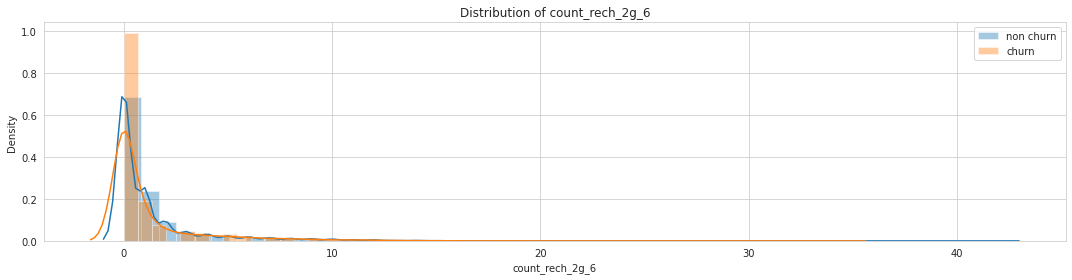

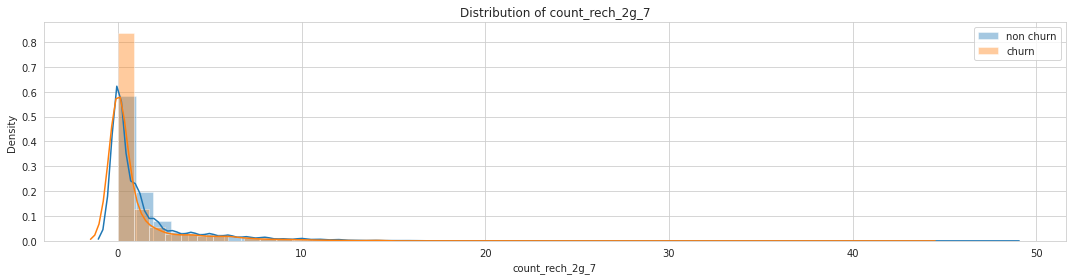

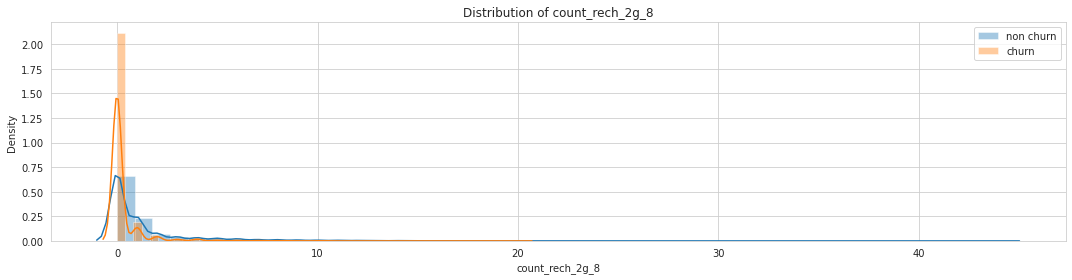

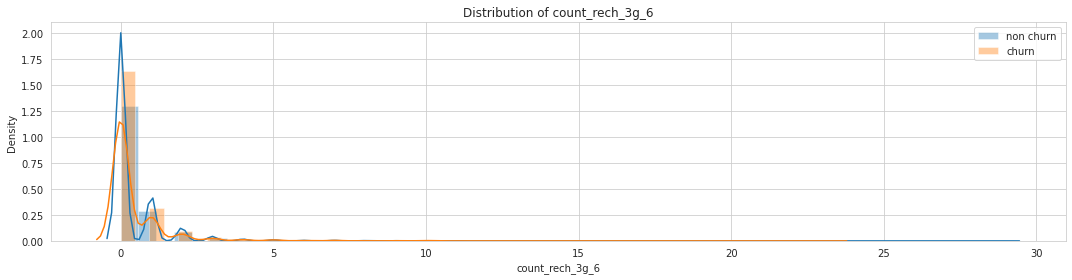

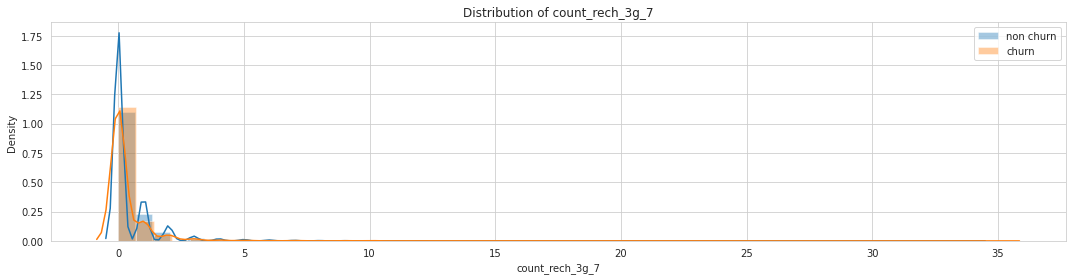

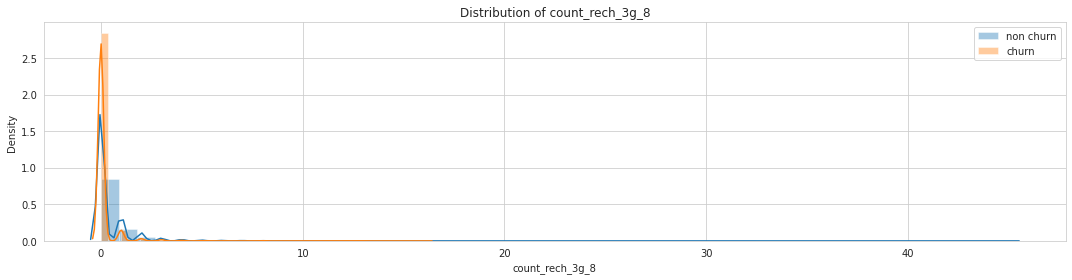

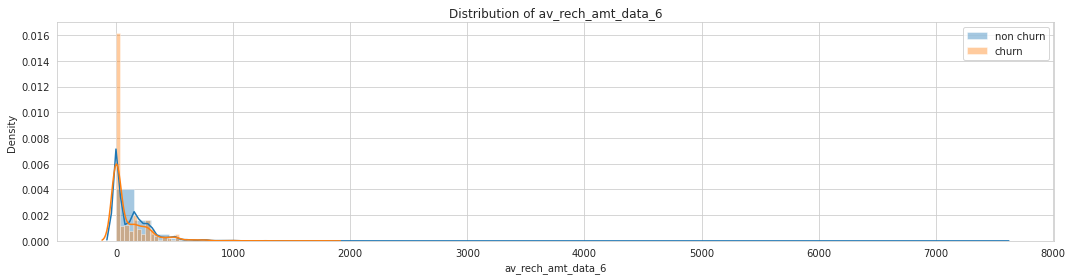

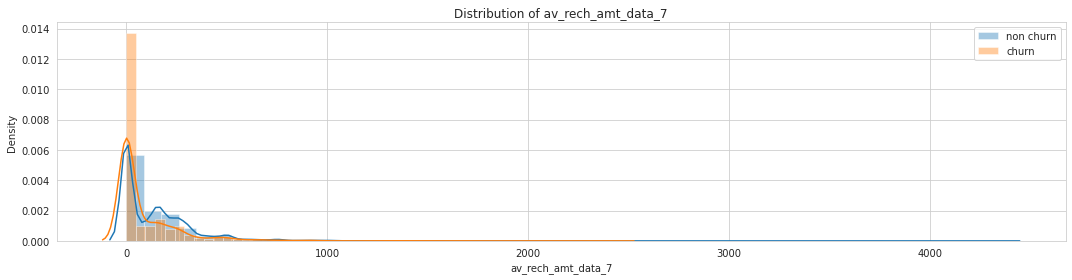

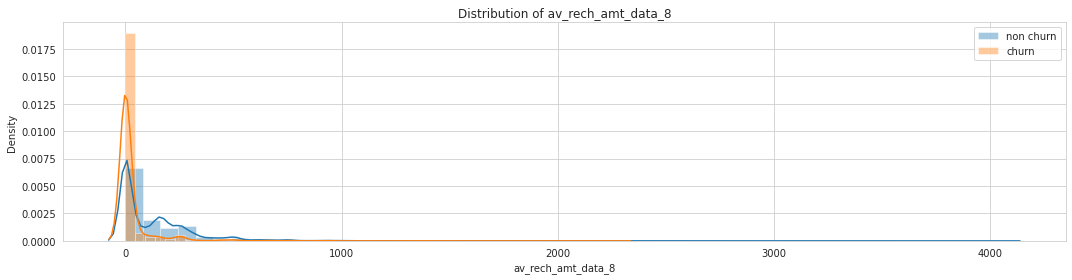

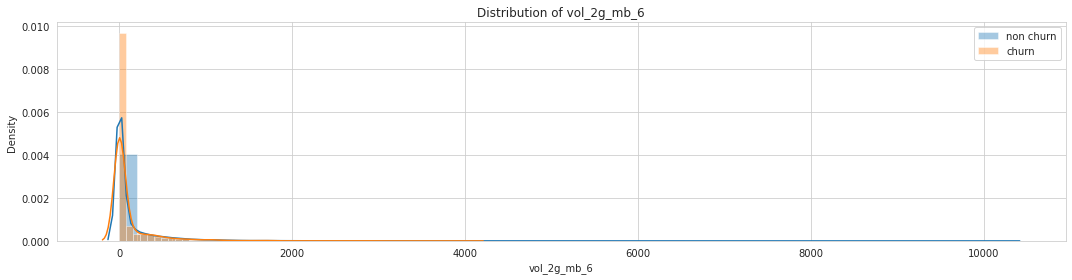

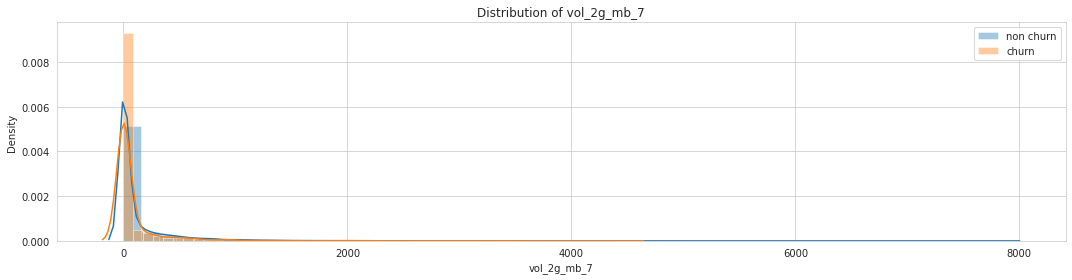

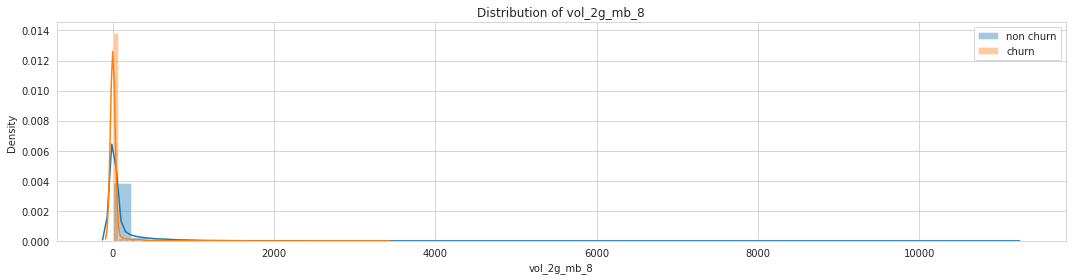

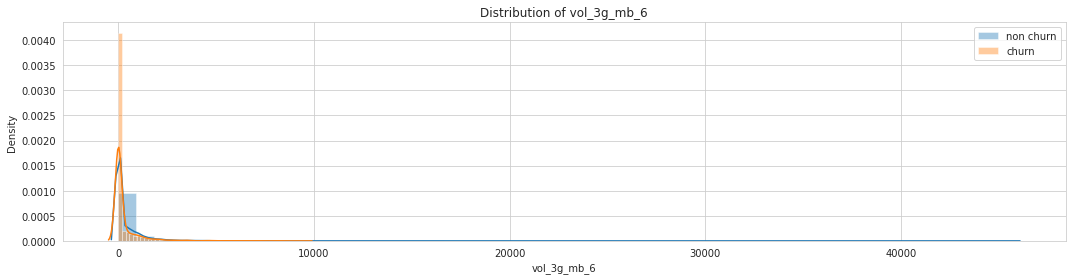

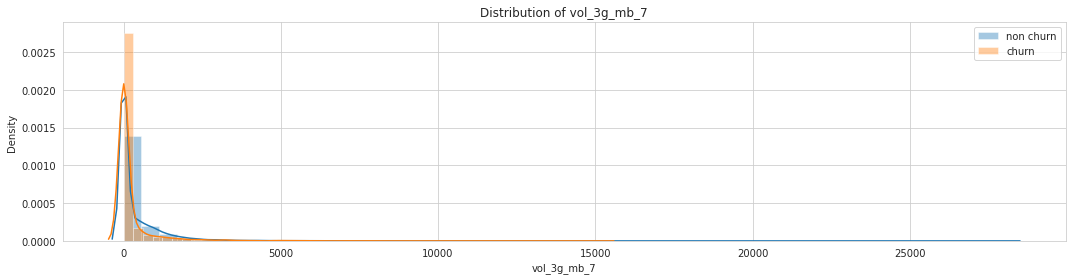

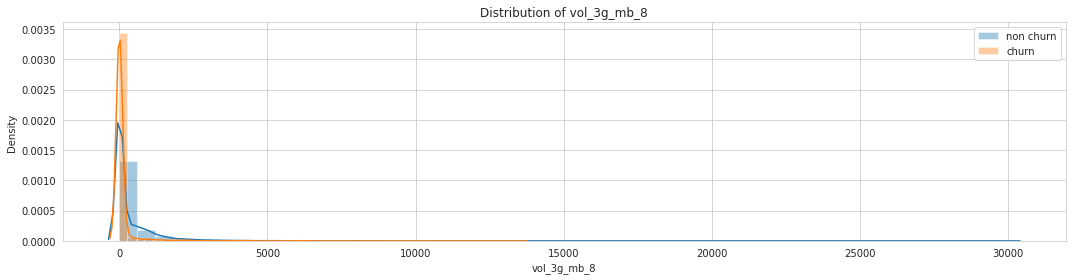

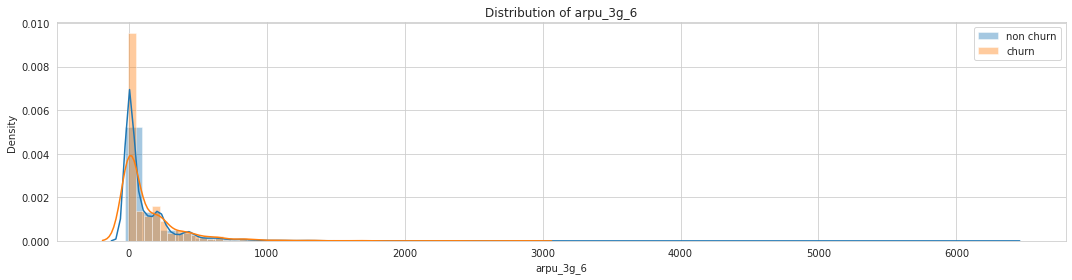

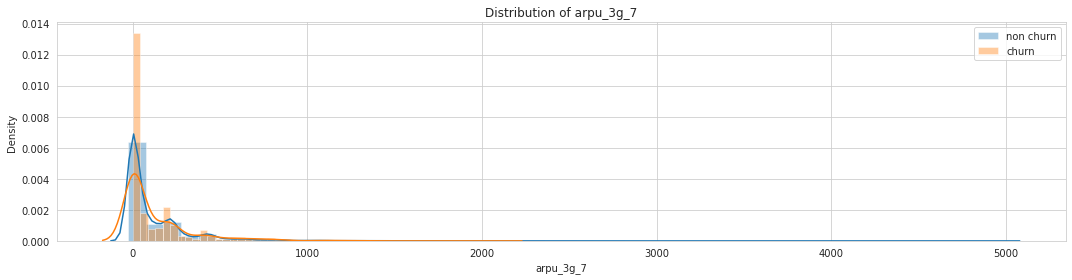

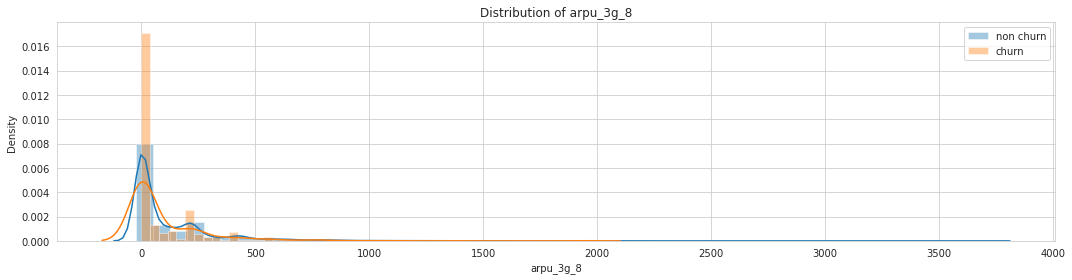

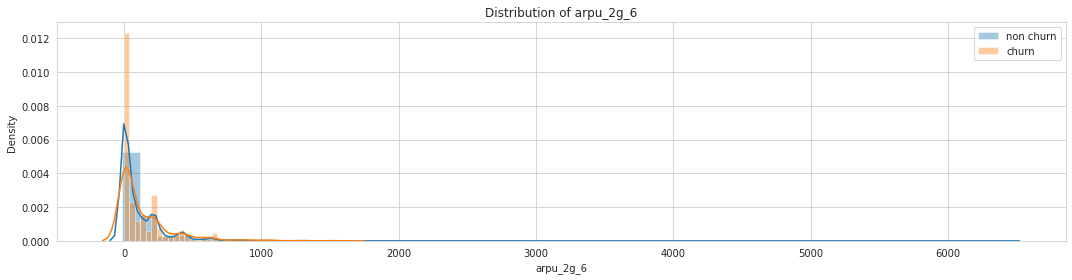

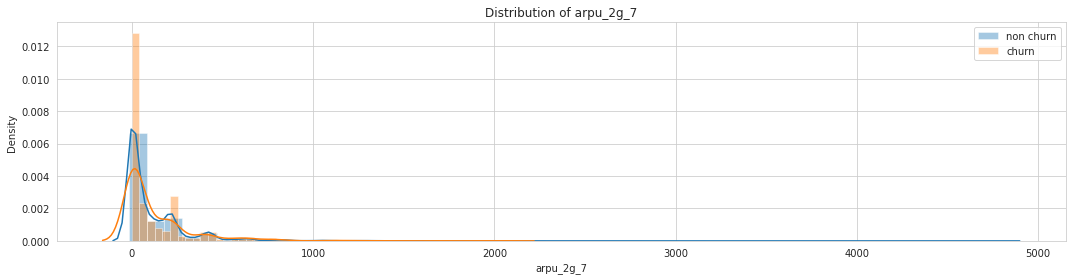

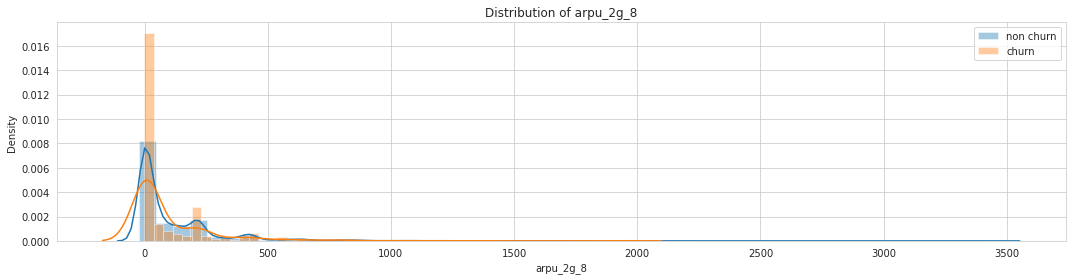

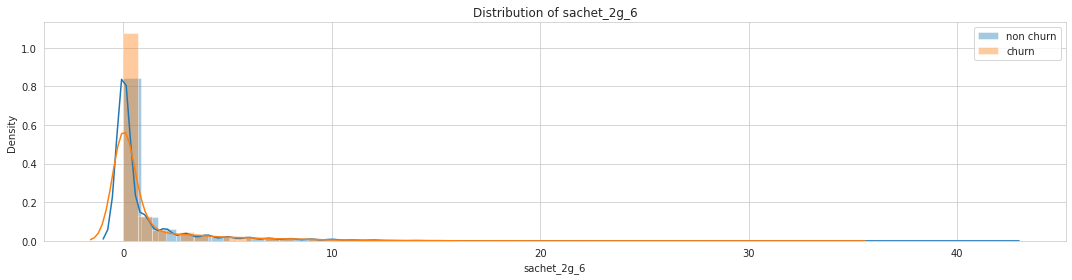

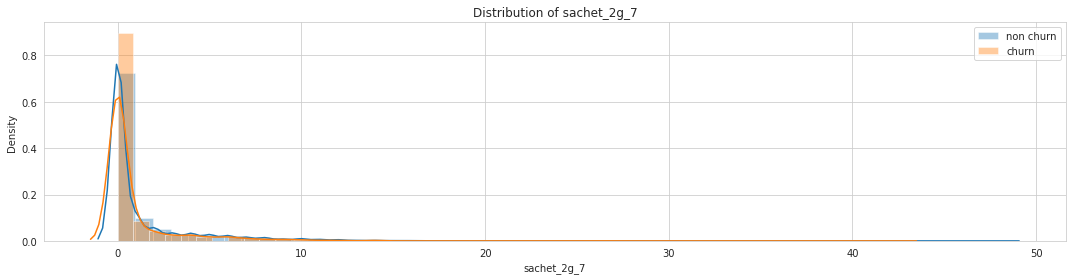

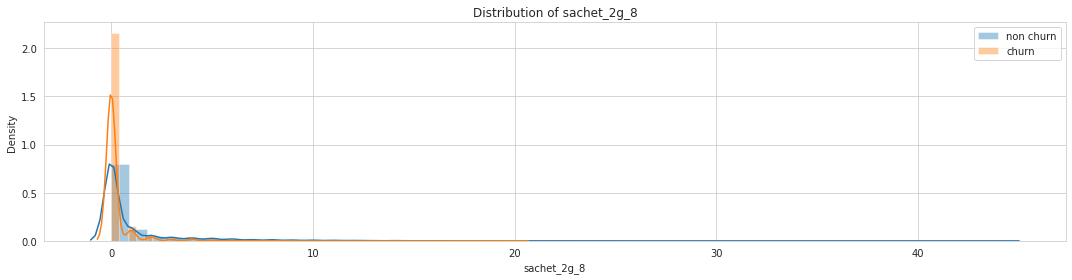

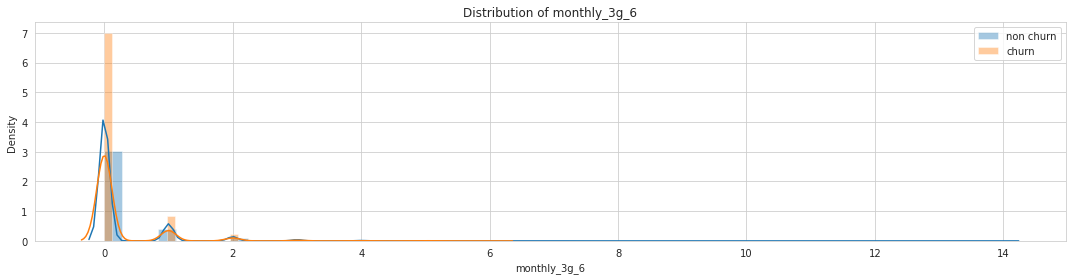

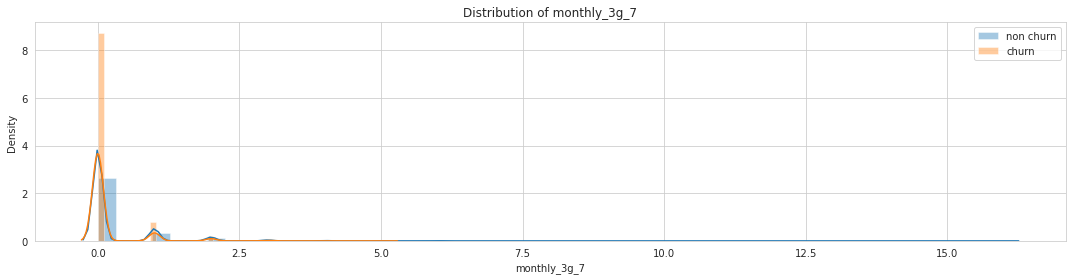

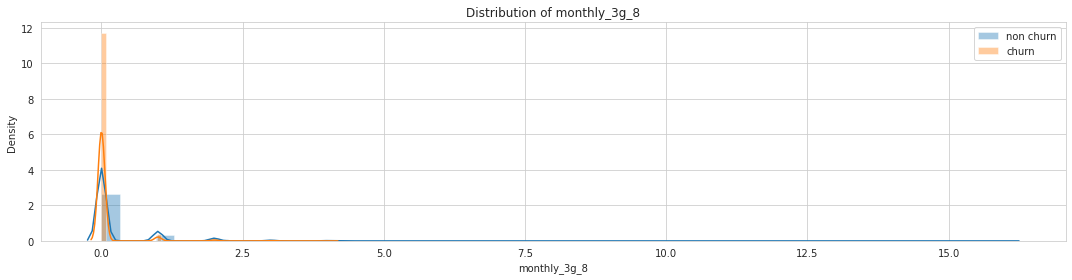

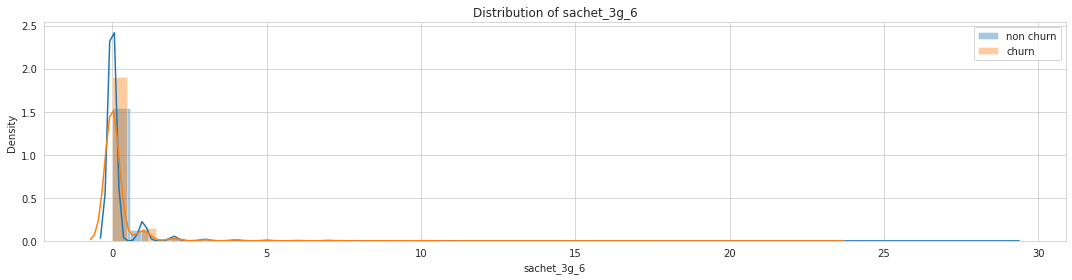

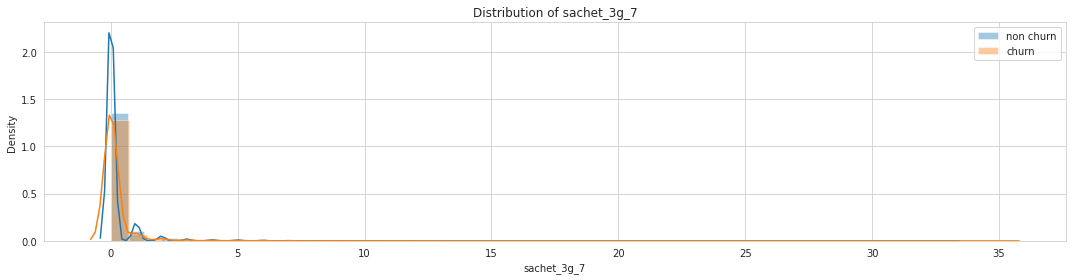

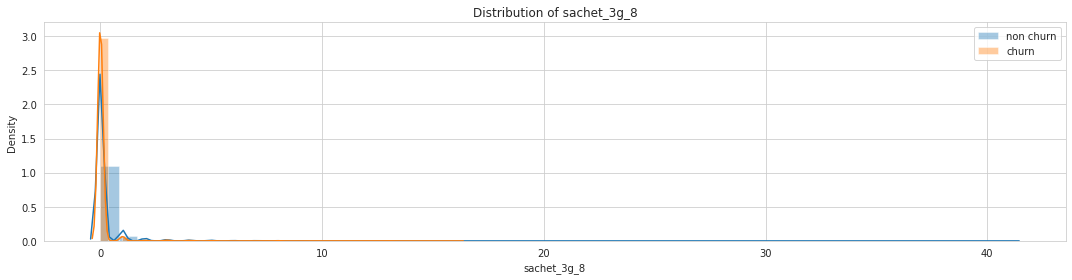

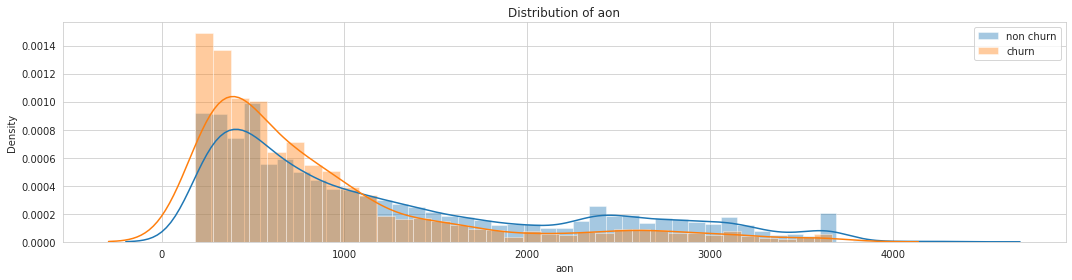

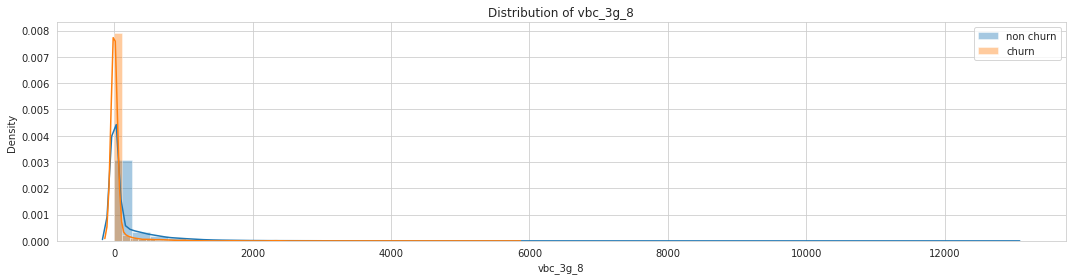

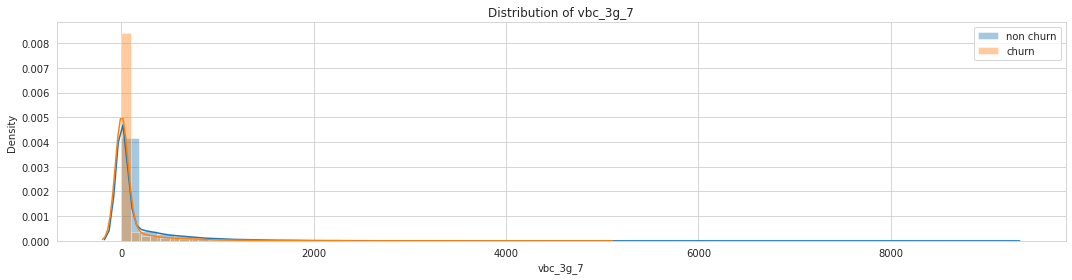

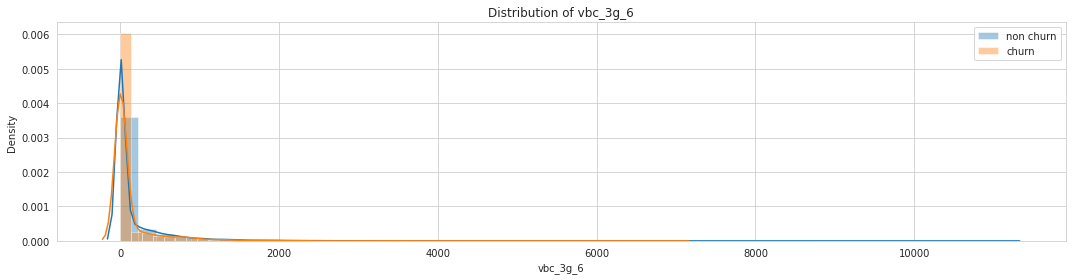

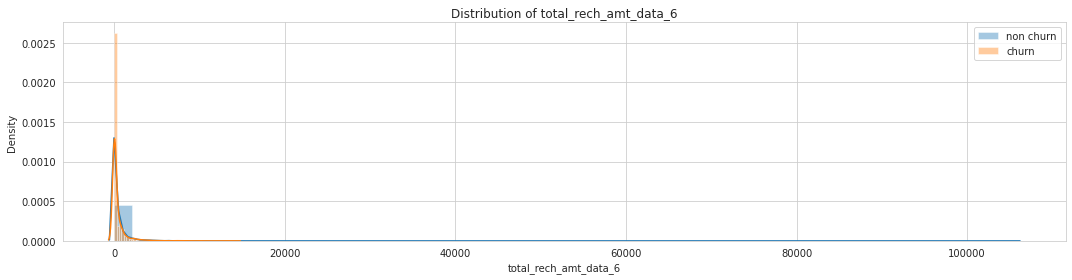

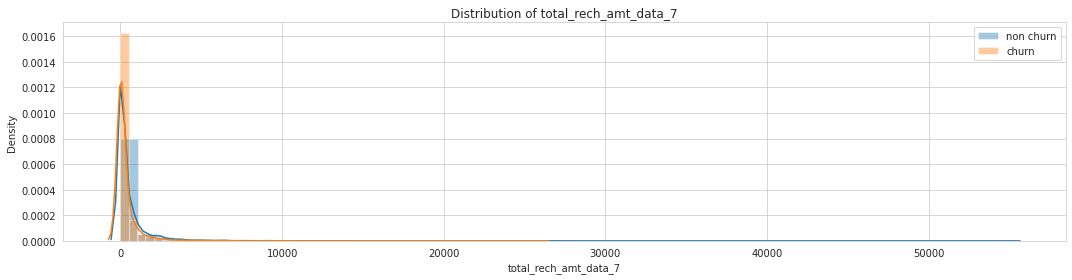

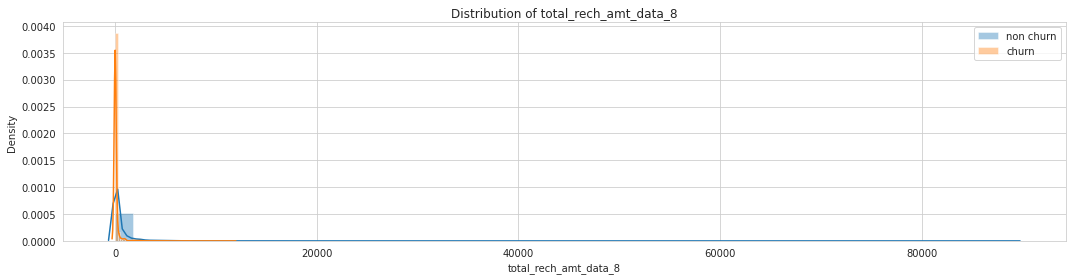

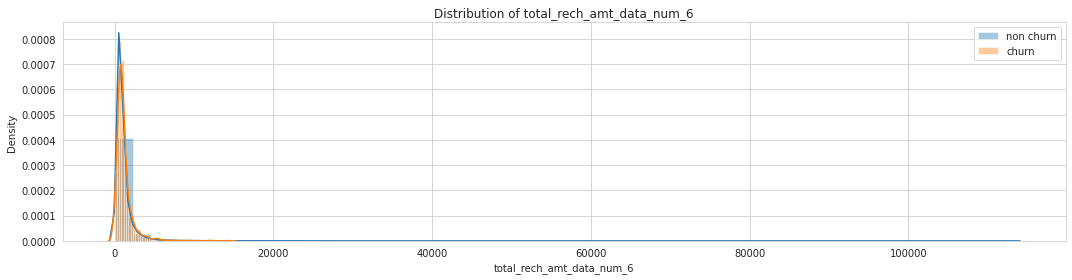

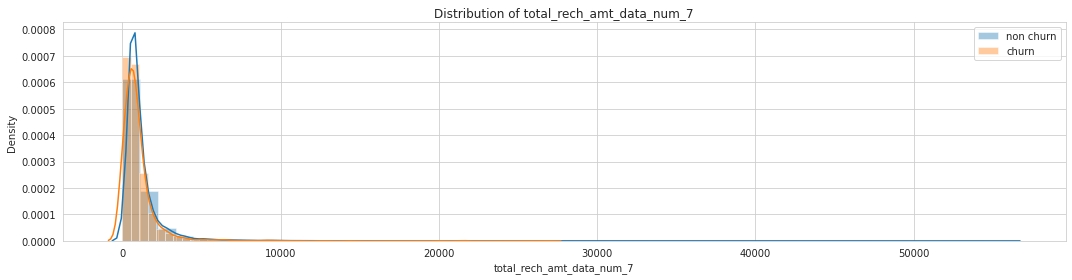

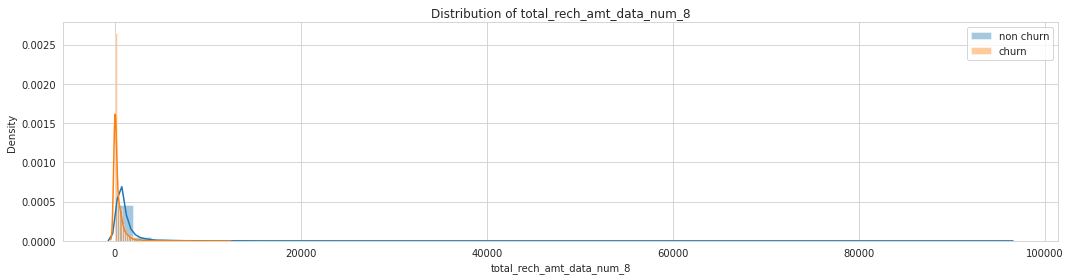

In [24]:
# Ploting distribution of each columns

for col in num_col:
    num_plot(df,col)

### Visualizing Numerical columns:

- Let's group numerical columns according to data they hold & `dig deeper` into it.

In [25]:
num_group = []
for i in num_col:
  if ('_6' in i) or ('_7' in i) or ('_8' in i):
    num_group.append(i[:-2])
num_group = set(num_group)
num_group_dict = {i: [i+'_6',i+'_7',i+'_8'] for i in num_group}

# Just to see group of data we got
pd.DataFrame(num_group_dict, index=['June', 'July', 'August']).T

June                       July  \
std_ic_t2m_mou                    std_ic_t2m_mou_6           std_ic_t2m_mou_7   
total_rech_data                  total_rech_data_6          total_rech_data_7   
onnet_mou                              onnet_mou_6                onnet_mou_7   
std_og_t2t_mou                    std_og_t2t_mou_6           std_og_t2t_mou_7   
loc_og_t2t_mou                    loc_og_t2t_mou_6           loc_og_t2t_mou_7   
av_rech_amt_data                av_rech_amt_data_6         av_rech_amt_data_7   
std_ic_t2t_mou                    std_ic_t2t_mou_6           std_ic_t2t_mou_7   
loc_ic_t2m_mou                    loc_ic_t2m_mou_6           loc_ic_t2m_mou_7   
std_og_mou                            std_og_mou_6               std_og_mou_7   
total_rech_amt                    total_rech_amt_6           total_rech_amt_7   
arpu_3g                                  arpu_3g_6                  arpu_3g_7   
total_og_mou                        total_og_mou_6             total_og_mou_7   
arpu                                        arpu_6                     arpu_7   
std_og_t2f_mou                    std_og_t2f_mou_6           std_og_t2f_mou_7   
total_rech_num                    total_rech_num_6           total_rech_num_7   
loc_ic_t2t_mou                    loc_ic_t2t_mou_6           loc_ic_t2t_mou_7   
loc_ic_mou                            loc_ic_mou_6               loc_ic_mou_7   
arpu_2g                                  arpu_2g_6                  arpu_2g_7   
og_others                              og_others_6                og_others_7   
sachet_3g                              sachet_3g_6                sachet_3g_7   
last_day_rch_amt                last_day_rch_amt_6         last_day_rch_amt_7   
spl_og_mou                            spl_og_mou_6               spl_og_mou_7   
loc_og_t2c_mou                    loc_og_t2c_mou_6           loc_og_t2c_mou_7   
std_ic_mou                            std_ic_mou_6               std_ic_mou_7   
loc_og_mou                            loc_og_mou_6               loc_og_mou_7   
sachet_2g                              sachet_2g_6                sachet_2g_7   
monthly_3g                            monthly_3g_6               monthly_3g_7   
vbc_3g                                    vbc_3g_6                   vbc_3g_7   
roam_ic_mou                          roam_ic_mou_6              roam_ic_mou_7   
count_rech_2g                      count_rech_2g_6            count_rech_2g_7   
vol_2g_mb                              vol_2g_mb_6                vol_2g_mb_7   
total_rech_amt_data_num  total_rech_amt_data_num_6  total_rech_amt_data_num_7   
std_ic_t2f_mou                    std_ic_t2f_mou_6           std_ic_t2f_mou_7   
spl_ic_mou                            spl_ic_mou_6               spl_ic_mou_7   
max_rech_data                      max_rech_data_6            max_rech_data_7   
count_rech_3g                      count_rech_3g_6            count_rech_3g_7   
isd_ic_mou                            isd_ic_mou_6               isd_ic_mou_7   
std_og_t2m_mou                    std_og_t2m_mou_6           std_og_t2m_mou_7   
vol_3g_mb                              vol_3g_mb_6                vol_3g_mb_7   
offnet_mou                            offnet_mou_6               offnet_mou_7   
loc_og_t2m_mou                    loc_og_t2m_mou_6           loc_og_t2m_mou_7   
total_rech_amt_data          total_rech_amt_data_6      total_rech_amt_data_7   
loc_ic_t2f_mou                    loc_ic_t2f_mou_6           loc_ic_t2f_mou_7   
loc_og_t2f_mou                    loc_og_t2f_mou_6           loc_og_t2f_mou_7   
ic_others                              ic_others_6                ic_others_7   
roam_og_mou                          roam_og_mou_6              roam_og_mou_7   
max_rech_amt                        max_rech_amt_6             max_rech_amt_7   
isd_og_mou                            isd_og_mou_6               isd_og_mou_7   
total_ic_mou                        total_ic_mou_6             total_ic_mou_7

#### Univariate Analysis:

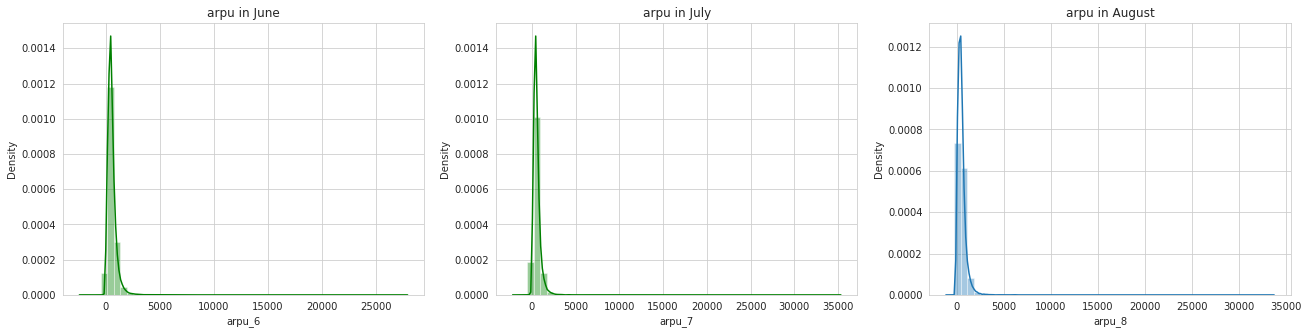

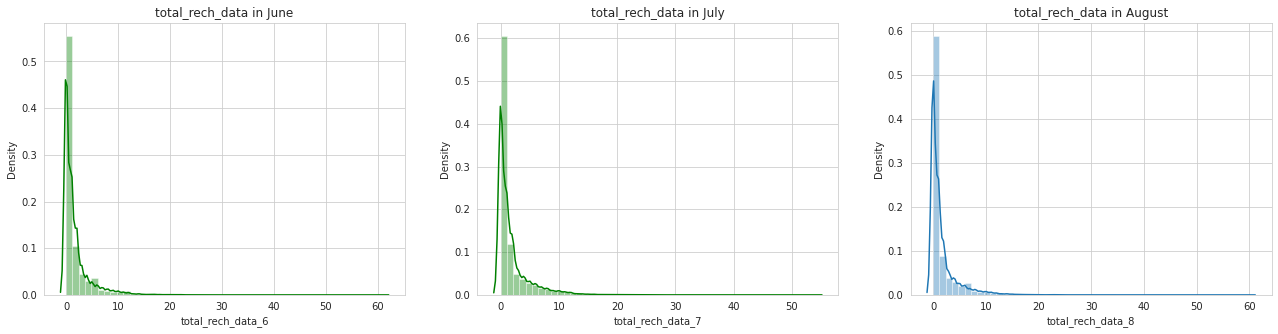

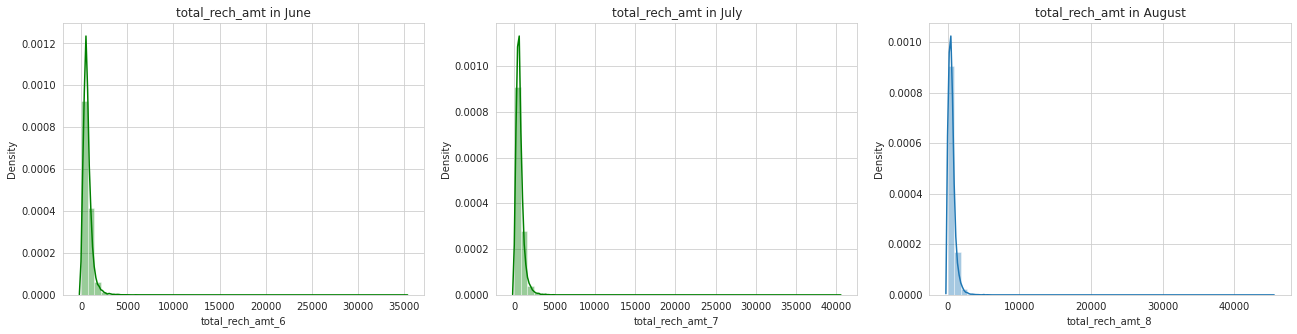

In [26]:
def cus_value(col):
  plt.figure(figsize=(22, 5))
  plt.rc('xtick', labelsize=10)
  plt.rc('ytick', labelsize=10)

  plt.subplot(1,3,1)
  sns.distplot(df[col+'_6'],color= "g")
  plt.title(f"{col} in June")
  
  plt.subplot(1,3,2)
  sns.distplot(df[col+'_7'],color= "g")
  plt.title(f"{col} in July")

  plt.subplot(1,3,3)
  sns.distplot(df[col+'_8'])
  plt.title(f"{col} in August")

  plt.show()

col = ['arpu', 'total_rech_data', 'total_rech_amt']
for i in col:
  cus_value(i)

#### Creating a function to easily compare values in 3 month

In [27]:
#Create Bar Plot
def bar_compare(col,title,y):
  plt.figure(figsize=(14, 4),dpi=120)
  plt.rc('xtick', labelsize=8)
  plt.rc('ytick', labelsize=8)

  plt.subplot(1,3,1)
  sns.barplot(x = 'churn', y = num_group_dict[col][0], data = df)
  plt.ylabel(y)
  plt.title( title+"June" , size = 9 )

  plt.subplot(1,3,2)
  sns.barplot(x = 'churn', y = num_group_dict[col][1], data = df)
  plt.ylabel(y)
  plt.title( title+"July" , size = 9 )

  plt.subplot(1,3,3)
  sns.barplot(x = 'churn', y = num_group_dict[col][2], data = df)
  plt.ylabel(y)
  plt.title( title+"August" , size = 9)
  plt.show()

#### Comparing ARPU

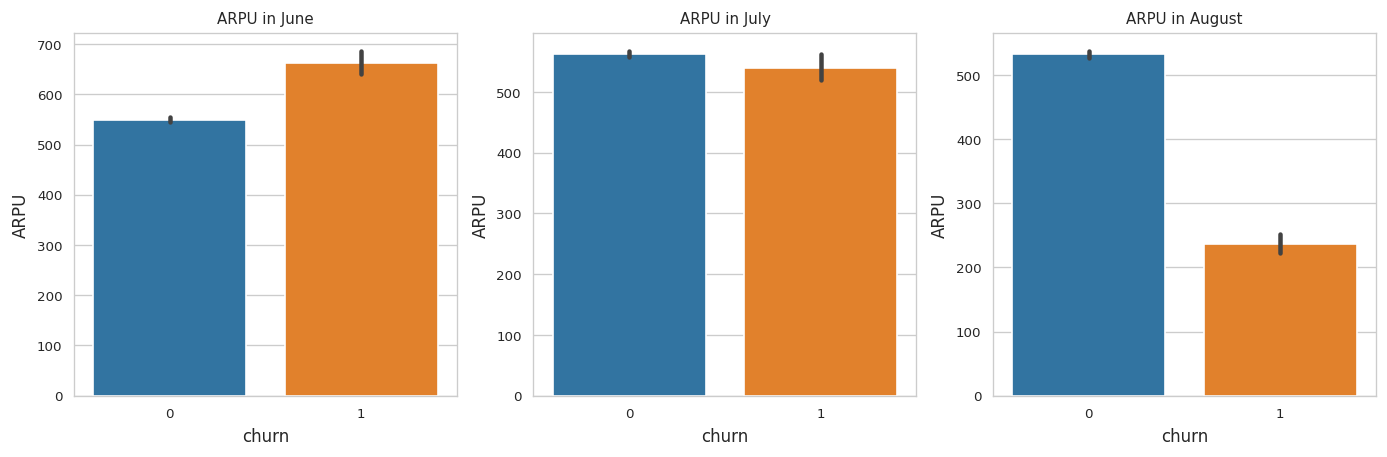

In [28]:
bar_compare('arpu', 'ARPU in ','ARPU')

### ARPU for 2g and 3g

- Creating a single Variable for ARPU Data instead of using a 2g and 3g Separate entity.

In [29]:
df['arpu_2g+3g_6']=df['arpu_2g_6']+df['arpu_3g_6']
df['arpu_2g+3g_7']=df['arpu_2g_7']+df['arpu_3g_7']
df['arpu_2g+3g_8']=df['arpu_2g_8']+df['arpu_3g_8']

num_group_dict['arpu_2g+3g'] = ['arpu_2g+3g_'+str(i) for i in range(6,9)]
num_col.extend(num_group_dict['arpu_2g+3g'])

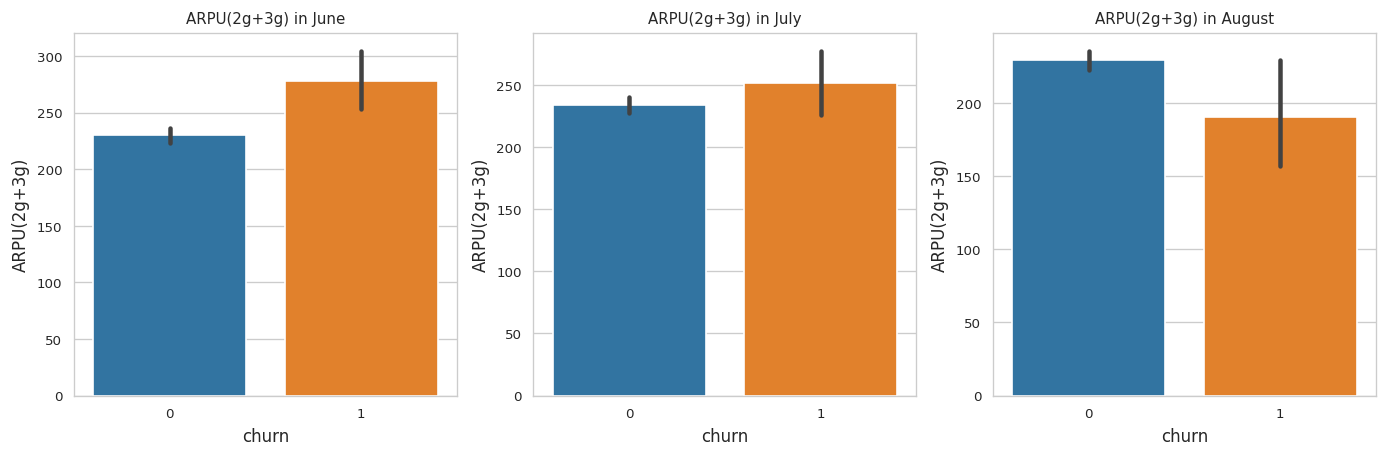

In [30]:
bar_compare('arpu_2g+3g', 'ARPU(2g+3g) in ','ARPU(2g+3g)')

#### Insights:

- It can be observed that **Average Revenue from 2g & 3g network per User (arpu_2g+3g)** has started declining from month 7 and has ramped down drastically in the Action Phase.

* Hence the **Average Revenue per User (arpu)** is a an important Predictor Feature. 


### Recharge Revenue Analysis of Customers:

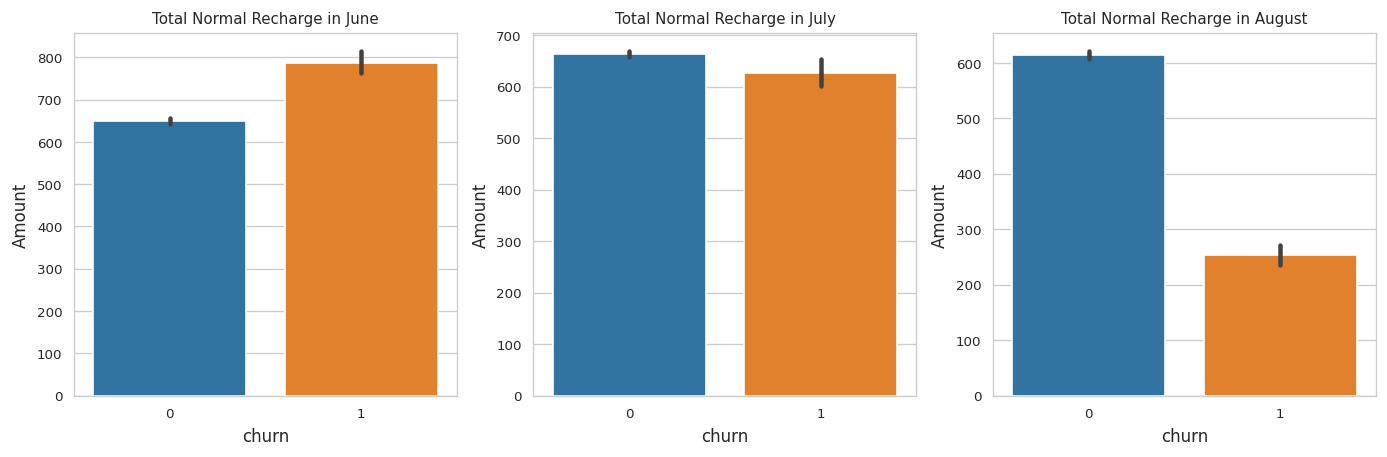

In [31]:
bar_compare('total_rech_amt', 'Total Normal Recharge in ','Amount')

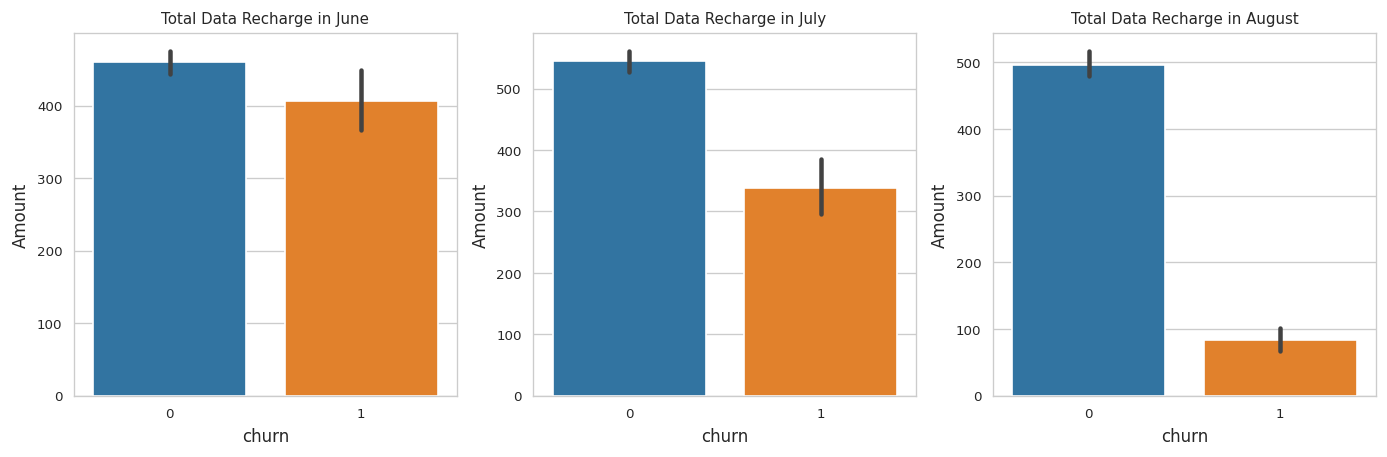

In [32]:
bar_compare('total_rech_amt_data', 'Total Data Recharge in ','Amount')

### Max Recharge Amount Analysis of Customers:

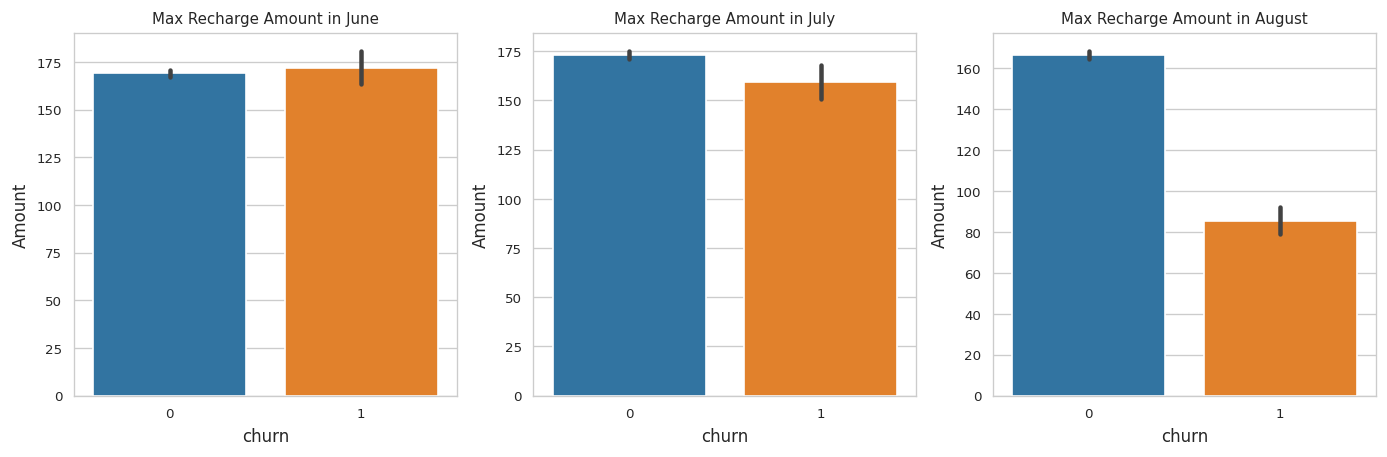

In [33]:
bar_compare('max_rech_amt', 'Max Recharge Amount in ','Amount')

#### Insights:

* It can be observed that the Churn Customers show a drop in Recharges in VOICE and Data in Action Phase where as it was similar to non-Churn customer in month 6 & 7. Hence the `total_data_rech` & `total_rech_amt` are both important Predictor Features.

* The same Trend Can be seen in Max Recharge Amount that Churn Customers tend to Recharge Less Amount in the Action Phase.

###  Recharge column Correlation Analysis:

In [34]:
rechColumn = []
for i in num_col:
  if 'rech' in i or 'rch' in i:
    rechColumn.append(i)

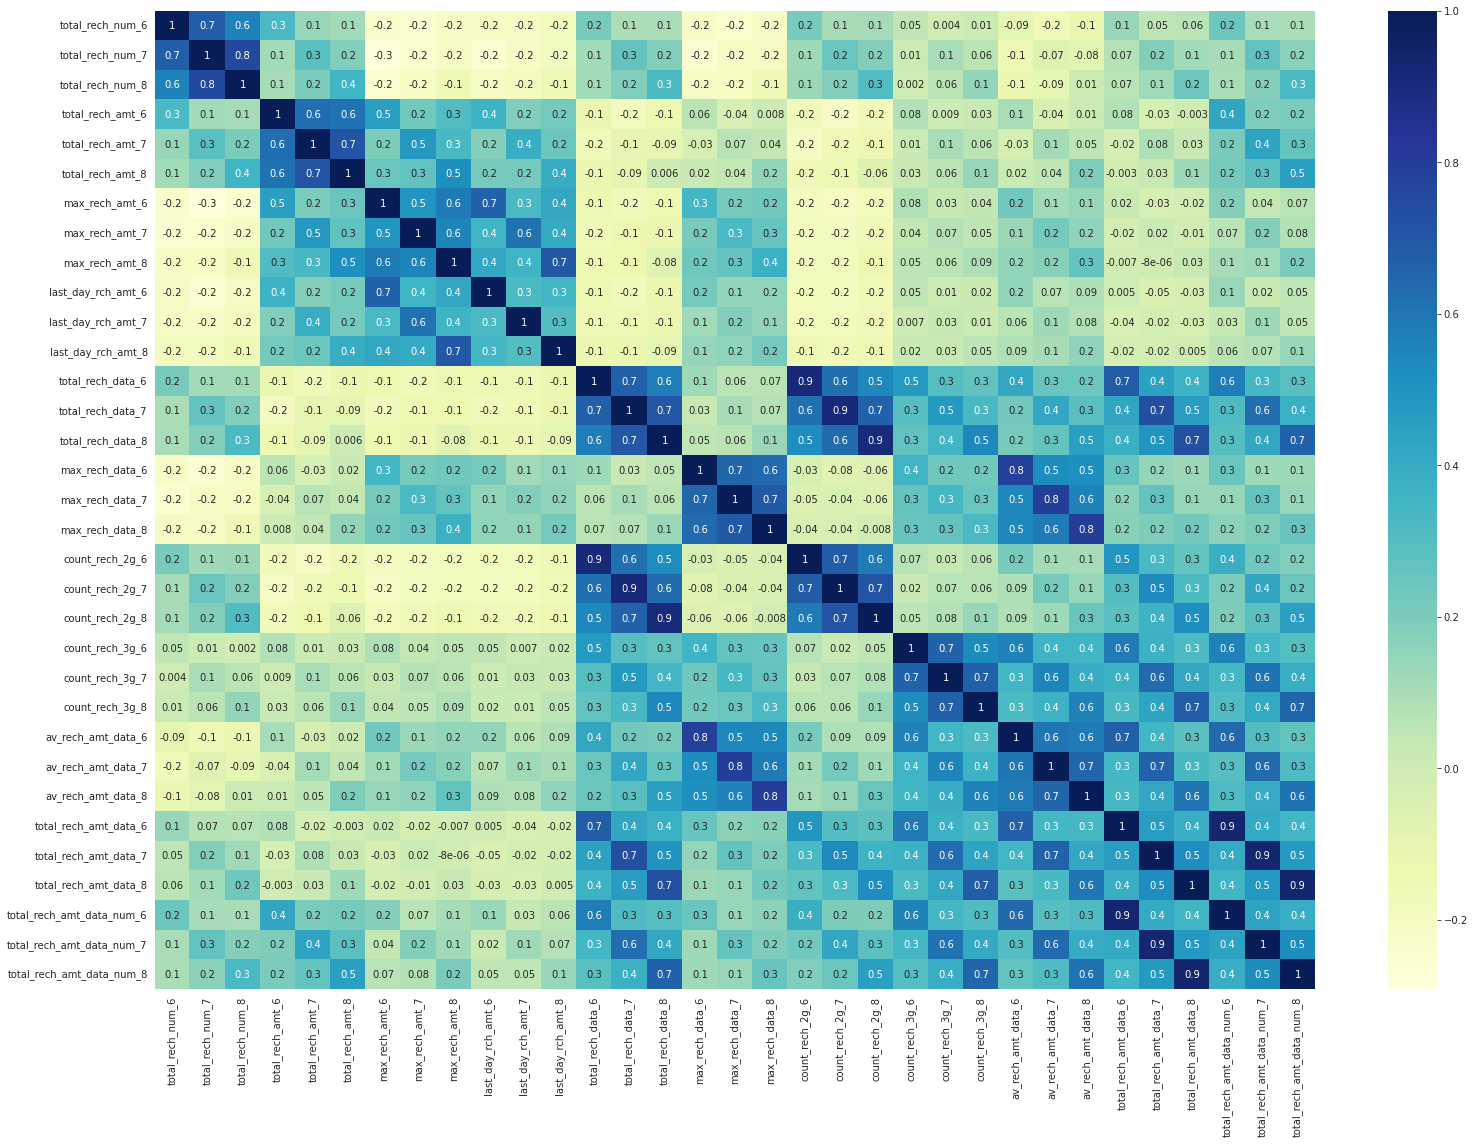

In [35]:
plt.figure(figsize = (26, 18))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

sns.heatmap(df[rechColumn].corr(), annot = True, cmap="YlGnBu",fmt='.1g')
plt.show()

#### Insights 

- It can be observed that the `count_rech_2g` has a strong correlation of **90%** with `total_rech_data` and correlation of **70 %** with `total_rech_amt_data` for both Good and Action Phase.

- It can be also observed that the `max_rech_amt` has a good correlation **70%** with `last_day_rech_amt` for both Good and Action Phase.

- We can  also see that `av_rech_amt_data` has a strong corellation of **80%** with `max_rech_data`.

### Voice call Minutes within the network

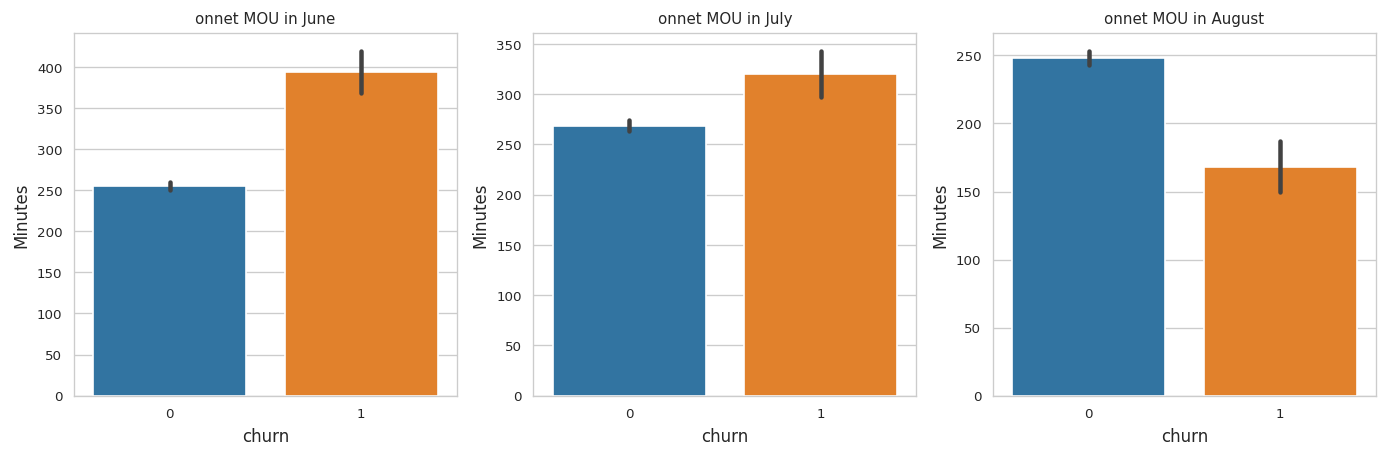

In [36]:
bar_compare('onnet_mou', 'onnet MOU in ', 'Minutes')

### Voice call Minutes with other network

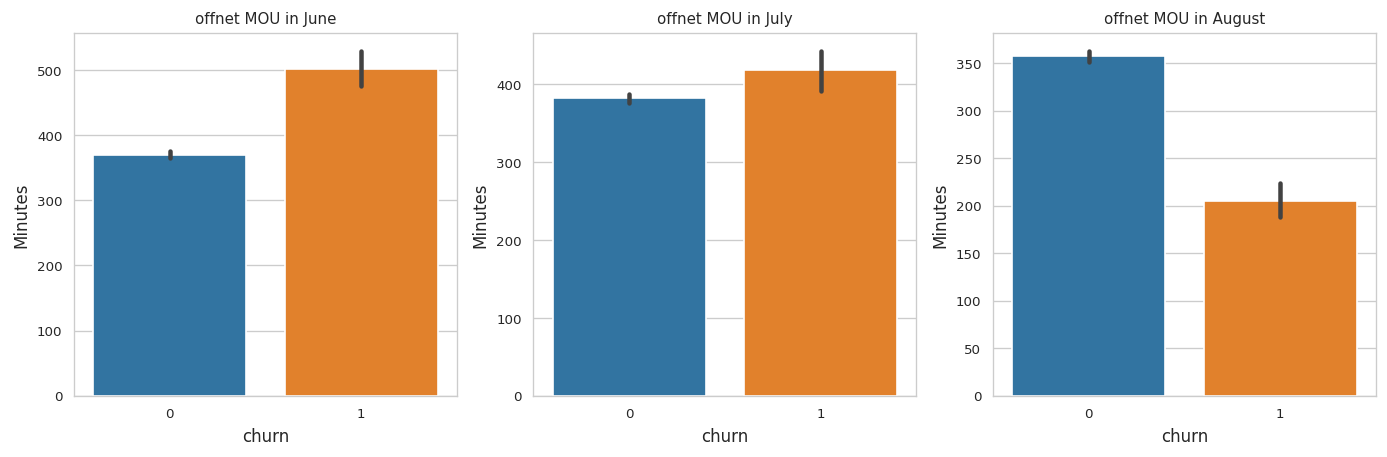

In [37]:
bar_compare('offnet_mou', 'offnet MOU in ', 'Minutes')

#### Insights:

- It can be observed that the Churn Customers show a drop in Call Minute Usage(MOU) in Action Phase where as they seem to provide a steady MOU to the telecom Network previously. Hence the **Minutes of Usage (MOU)** is a an important Predictor Feature.

- It can also be observed that call minutes with other network is high compared to call minutes within network.

### Analysis of Total Call Minutes in incoming & Outgoing Calls

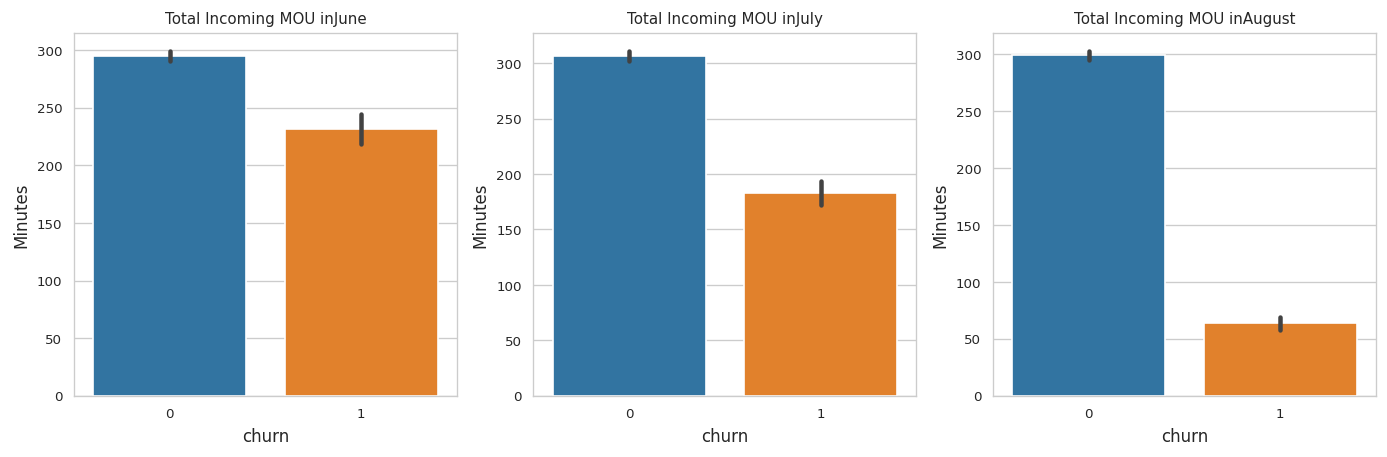

In [38]:
bar_compare('total_ic_mou', 'Total Incoming MOU in', 'Minutes')

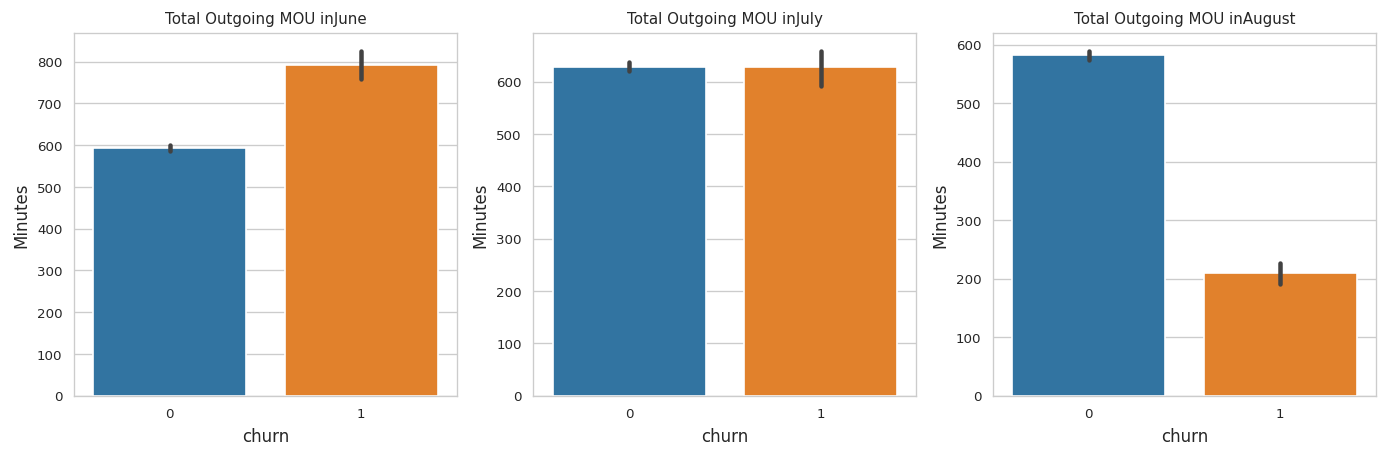

In [39]:
bar_compare('total_og_mou', 'Total Outgoing MOU in', 'Minutes')

#### Insights 

* It can be observed that the Churn Customers show a drop in MOC in Action Phase. Hence the **total_ic_mou & total_og_mou** are both important Predictor Features.

* We can also see that non-Churn customer has **steady MOU** in both Incoming & Outgoing calls during the 3 months.

###  Incoming and Outgoing Call Minutes Correlation Analysis:

In [40]:
incomingHeaders=[]
outgoingHeaders=[]
for i in df.columns.values:
  if 'mou' in i:
    if 'ic' in i:
        incomingHeaders.append(i)
    if 'og' in i:
        outgoingHeaders.append(i)

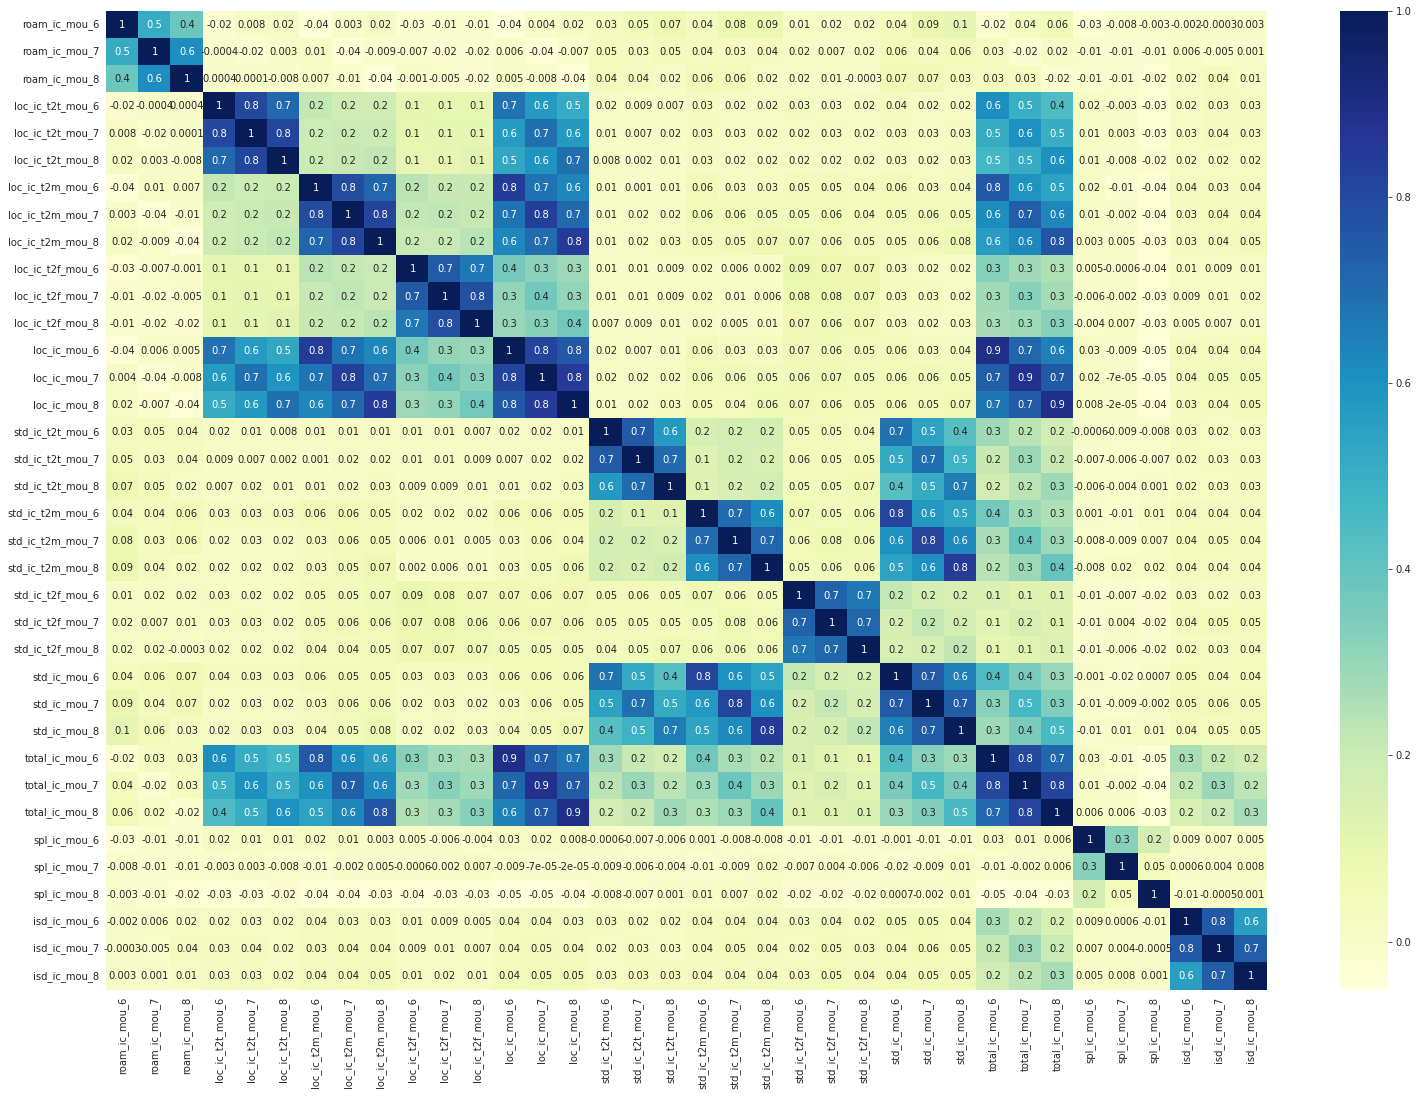

In [41]:
plt.figure(figsize = (26, 18))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

sns.heatmap(df[incomingHeaders].corr(), annot = True, cmap="YlGnBu",fmt='.1g')
plt.show()

### Insights:

- It can be observed that the **loc_ic_t2t_mou** has a good correlation of **60 %** with **total_ic_mou** for both Good and Action Phase.

- It can be observed that the **loc_ic_t2m_mou** has a good correlation of **70 % - 80 %** with **total_ic_mou** for both Good and Action Phase.

- It can be observed that the **loc_ic_mou** has a strong postive correlation **90 %** with **total_ic_mou** for both Good and Action Phase.

- There is a high Chance of Multicollinearity as **loc_ic_t2t_mou ,loc_ic_t2m_mou ,loc_ic_mou** and **total_ic_mou** are showing good coorelation with each other.

- It can be observed that the **std_ic_t2t_mou** has a good correlation of **70 %** with **std_ic_mou** for both Good and Action Phase.

- It can be observed that the **std_ic_t2m_mou** has a good correlation of **80 %** with **std_ic_mou** for both Good and Action Phase.

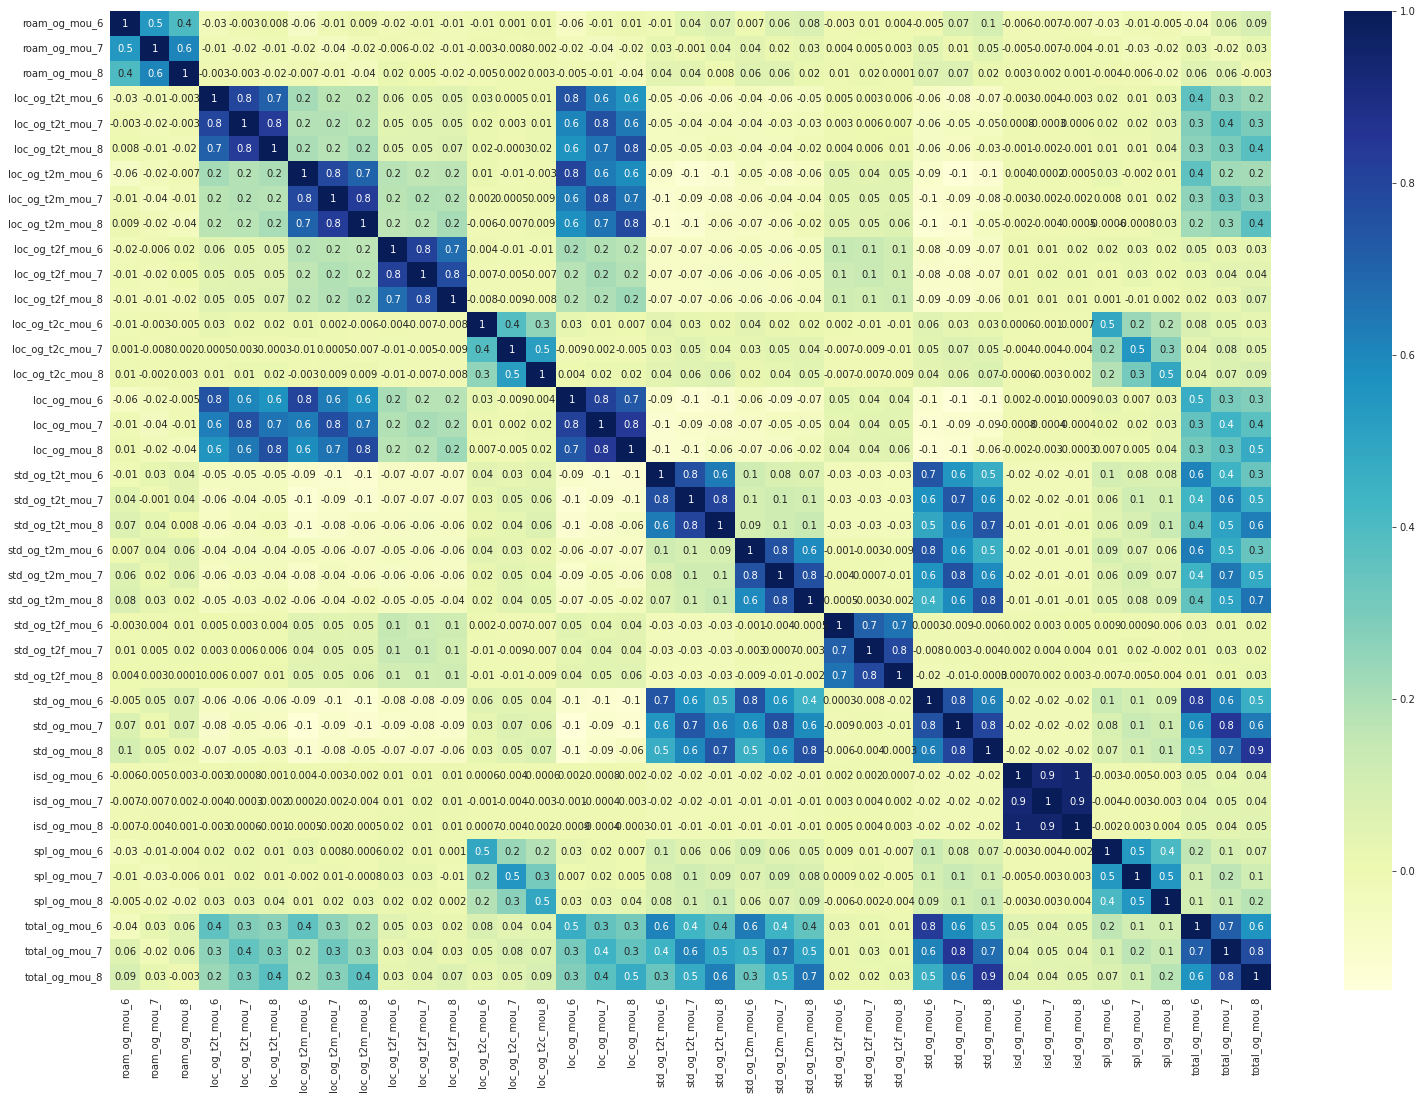

In [42]:
plt.figure(figsize = (26, 18))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

sns.heatmap(df[outgoingHeaders].corr(), annot = True, cmap="YlGnBu",fmt='.1g')
plt.show()

### Insights:

- It can be observed that the **loc_og_t2t_mou** has a good correlation of **80 %** with **log_og_mou** for both Good and Action Phase.

- It can be observed that the **loc_og_t2m_mou** has a good correlation of **80 %** with **log_og_mou** for both Good and Action Phase.

- There is a high Chance of Multicollinearity as **loc_og_t2t_mou,loc_og_t2m_mou** and **loc_og_mou** are showing good coorelation with each other.

- It can be observed that the **std_og_t2m_mou** has a good correlation of **80 %** with **std_og_mou** for both Good and Action Phase.

- It can be observed that the **std_og_t2t_mou** has a good correlation of **70 %** with **std_og_mou** for both Good and Action Phase.

- It can be observed that the **std_og_mou** has a good correlation **80 %** with **total_og_mou** for both Good and Action Phase.

- There is a high chance of `Multicollinearity` as **std_og_t2t_mou ,std_og_t2m_mou ,std_og_mou** and **total_og_mou** are showing good coorelation with each other.

### Deriving some new feature by cumulating 3g & 2g Data

In [43]:
# Cumulating Sachet information for 2g & 3g
df['sachet_3g+2g_data_6']=df.sachet_3g_6+df.sachet_2g_6
df['sachet_3g+2g_data_7']=df.sachet_3g_7+df.sachet_2g_7
df['sachet_3g+2g_data_8']=df.sachet_3g_8+df.sachet_2g_8

# Cumulating
df['monthly_2g+3g_data_6']=df.monthly_3g_6+df.monthly_2g_6
df['monthly_2g+3g_data_7']=df.monthly_3g_7+df.monthly_2g_7
df['monthly_2g+3g_data_8']=df.monthly_3g_8+df.monthly_2g_8

# Extending our num_col list
num_col.extend(['sachet_3g+2g_data_6', 'sachet_3g+2g_data_7', 'sachet_3g+2g_data_8', 'monthly_2g+3g_data_6', 'monthly_2g+3g_data_7', 'monthly_2g+3g_data_8'])

old_col = ['sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8',
           'monthly_3g_6','monthly_3g_7','monthly_3g_8','monthly_2g_6','monthly_2g_7','monthly_2g_8']

# dropping columns
num_col = list(filter(lambda x: x not in old_col, num_col))
cat_col = list(filter(lambda x: x not in old_col, cat_col))

- At this point, we don't have any cat_col left.
- So we'll proceed with num_col only.

# Data Preprocessing

## Missing value handleing

In [44]:
check_miss(df[cat_col+num_col])

night_pck_user_6  night_pck_user_7  night_pck_user_8  \
Missing Value        13245.000000      12944.000000      14048.000000   
Missing Value %         44.148528         43.145228         46.825106   

                    fb_user_6     fb_user_7     fb_user_8  onnet_mou_6  \
Missing Value    13245.000000  12944.000000  14048.000000   545.000000   
Missing Value %     44.148528     43.145228     46.825106     1.816606   

                 onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
Missing Value      537.00000  1174.000000    545.000000     537.00000   
Missing Value %      1.78994     3.913203      1.816606       1.78994   

                 offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
Missing Value     1174.000000     545.000000      537.00000    1174.000000   
Missing Value %      3.913203       1.816606        1.78994       3.913203   

                 roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
Missing Value       545.000000      537.00000    1174.000000   
Missing Value %       1.816606        1.78994       3.913203   

                 loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
Missing Value          545.000000         537.00000       1174.000000   
Missing Value %          1.816606           1.78994          3.913203   

                 loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
Missing Value          545.000000         537.00000       1174.000000   
Missing Value %          1.816606           1.78994          3.913203   

                 loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
Missing Value          545.000000         537.00000       1174.000000   
Missing Value %          1.816606           1.78994          3.913203   

                 loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
Missing Value          545.000000         537.00000       1174.000000   
Missing Value %          1.816606           1.78994          3.913203   

                 loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
Missing Value      545.000000     537.00000   1174.000000        545.000000   
Missing Value %      1.816606       1.78994      3.913203          1.816606   

                 std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  \
Missing Value           537.00000       1174.000000        545.000000   
Missing Value %           1.78994          3.913203          1.816606   

                 std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
Missing Value           537.00000       1174.000000        545.000000   
Missing Value %           1.78994          3.913203          1.816606   

                 std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  \
Missing Value           537.00000       1174.000000    545.000000   
Missing Value %           1.78994          3.913203      1.816606   

                 std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  \
Missing Value       537.00000   1174.000000    545.000000     537.00000   
Missing Value %       1.78994      3.913203      1.816606       1.78994   

                 isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  \
Missing Value     1174.000000    545.000000     537.00000   1174.000000   
Missing Value %      3.913203      1.816606       1.78994      3.913203   

                 og_others_6  og_others_7  og_others_8  loc_ic_t2t_mou_6  \
Missing Value     545.000000    537.00000  1174.000000        545.000000   
Missing Value %     1.816606      1.78994     3.913203          1.816606   

                 loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  \
Missing Value           537.00000       1174.000000        545.000000   
Missing Value %           1.78994          3.913203          1.816606   

                 loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  \
Missing Value           537.00000       1174.000000        545.000000   
Missing Value %           1.78994          3.913203          1.816606   

                 loc_ic_t2f_mou_7  loc_

#### Removing features with high Missing Values

In [45]:
# Dropping missing value with more than 40% and date column

col_to_drop = check_miss(df[cat_col+num_col]).T[check_miss(df[cat_col+num_col]).T['Missing Value %']>40].index
cat_col = list(filter(lambda x: x not in col_to_drop, cat_col))
num_col = list(filter(lambda x: x not in col_to_drop, num_col))

In [46]:
# cat_col was emptied already
model_col = list(filter(lambda x: x not in col_to_drop, num_col))
model_col.append('churn')
df = df[model_col]
model_col.remove('churn')

In [47]:
# Filling remaining columns with zero
df = df.fillna(0)

## Data spliting

In [48]:
print("No of Churn Labels are:", sum(df['churn']))
print("No of Non-Churn Labels are : ", len(df)-sum(df['churn']))
print("churn rate : {}% \n".format(round(sum(df['churn']==1)/len(df['churn'])*100,2)))

No of Churn Labels are: 2441
No of Non-Churn Labels are :  27560
churn rate : 8.14% 



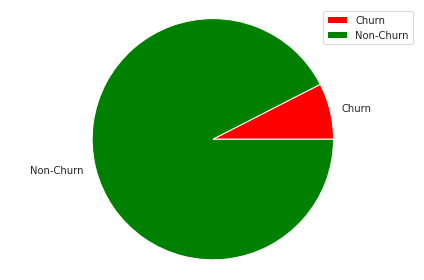

In [49]:
labels = ['Churn', 'Non-Churn']
sizes = [sum(df['churn']),len(df['churn'].index)]
colors = ['red', 'green']

patches , texts = plt.pie(sizes, labels=labels,colors=colors)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

- As we can see, Data is highly imbalanced. Churn rate is only `8.14%`.
- Using stratify method will not solve it. Additionally we have to additionally over salmple minority data points i.e churn in our case.

In [50]:
y = df['churn']
X = df[model_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Handeling imbalanced dataset

- Since our dataset is highly imbalanced, we'll use SMOTE to handle it.

In [51]:
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

### After SMOTE:

In [52]:
print("No of Churn Labels are:", sum(y_train_smote))
print("No of Non-Churn Labels are : ", len(X_train_smote)-sum(y_train_smote))
print("churn rate : {}% \n".format(round(sum(y_train_smote==1)/len(y_train_smote)*100,2)))

No of Churn Labels are: 19291
No of Non-Churn Labels are :  19291
churn rate : 50.0% 



# Model Building

## Pycaret

In [ ]:
!pip install pycaret

     |████████████████████████████████| 320 kB 4.8 MB/s 
     |████████████████████████████████| 2.0 MB 46.1 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 262 kB 48.6 MB/s 
     |████████████████████████████████| 120 kB 33.7 MB/s 
     |████████████████████████████████| 167 kB 45.2 MB/s 
     |████████████████████████████████| 88 kB 7.7 MB/s 
     |████████████████████████████████| 17.8 MB 456 kB/s 
     |████████████████████████████████| 6.8 MB 22.4 MB/s 
     |████████████████████████████████| 1.7 MB 42.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3 MB 33.3 MB/s 
     |████████████████████████████████| 102 kB 12.1 MB/s 
     |████████████████████████████████| 690 kB 44.7 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████

In [ ]:
from pycaret.utils import enable_colab
enable_colab()
from pycaret.classification import *

Colab mode enabled.


In [ ]:
df.head(3)

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   197.385   214.816   213.803         0.00         0.00         0.00   
7  1069.180  1349.850  3171.480        57.84        54.68        52.29   
8   378.721   492.223   137.362       413.69       351.03        35.08   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0          0.00          0.00          0.00           0.00           0.00   
7        453.43        567.16        325.91          16.23          33.49   
8         94.66         80.63        136.48           0.00           0.00   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
0           0.00           0.00           0.00           0.00   
7          31.64          23.74          12.59          38.06   
8           0.00           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
0              0.00              0.00              0.00              0.00   
7             51.39             31.38             40.28            308.63   
8            297.13            217.59             12.49             80.96   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
0              0.00              0.00              0.00              0.00   
7            447.38            162.28             62.13             55.14   
8             70.58             50.54              0.00              0.00   

   loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
0              0.00               0.0               0.0              0.00   
7             53.23               0.0               0.0              0.00   
8              0.00               0.0               0.0              7.15   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
0          0.00          0.00          0.00              0.00   
7        422.16        533.91        255.79              4.30   
8        378.09        288.18         63.04            116.56   

   std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
0              0.00              0.00              0.00              0.00   
7             23.29             12.01             49.89             31.76   
8            133.43             22.58             13.69             10.04   

   std_og_t2m_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  std_og_t2f_mou_8  \
0              0.00              0.00              0.00              0.00   
7             49.14              6.66             20.08             16.68   
8             75.69              0.00              0.00              0.00   

   std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  isd_og_mou_7  \
0          0.00          0.00          0.00           0.0          0.00   
7         60.86         75.14         77.84           0.0          0.18   
8        130.26        143.48         98.28           0.0          0.00   

   isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  og_others_6  \
0          0.00           0.0           0.0          0.00          0.0   
7         10.01           4.5           0.0          6.50          0.0   
8          0.00           0.0           0.0         10.23          0.0   

   og_others_7  og_others_8  total_og_mou_6  total_og_mou_7  total_og_mou_8  \
0          0.0          0.0            0.00            0.00            0.00   
7          0.0          0.0          487.53          609.24          350.16   
8          0.0          0.0          508.36          431.66          171.56   

   loc_ic_t2t_mou_6  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  loc_ic_t2m_mou_6  \
0              0.00              0.00              0.16              0.00   
7             58.14             32.26             27.31            217.56   
8             23.84              9.84              0.31             57.58   

   loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_t2f_mou_6  loc_ic_t2f_mou_7  \
0              0.00            

In [ ]:
from numpy.core import numeric
test = setup(data = df, target = 'churn', numeric_features = model_col, ignore_features = [],
          fix_imbalance = True, remove_perfect_collinearity = True, silent = True, log_experiment = False, n_jobs = -1, use_gpu = True, pca = False, session_id = 20220318, fold = 5)

Description             Value
0                               session_id          20220318
1                                   Target             churn
2                              Target Type            Binary
3                            Label Encoded              None
4                            Original Data      (30001, 140)
5                           Missing Values             False
6                         Numeric Features               139
7                     Categorical Features                 0
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set      (21000, 139)
12                    Transformed Test Set       (9001, 139)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                 5
17                                CPU Jobs                -1
18                                 Use GPU              True
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              cd47
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44             Remove Perfect Collinearity              True
45                              Clustering             False
46                    Clustering Iteration              None
47                     Polynomial Features             False
48                       Polynomial Degree              None
49                    Trignometry Features             False
50                    Polynomial Threshold              None
51                          Group Features             False
52                       Feature Selection             False
53                Feature Selection Method           classic
54            Features Selection Threshold              None
55                     Feature Interaction             False
56                           Feature Ratio             False
57                   Interaction Threshold              None
58                           Fix Imbalance              True
59                    Fix Imbalance Method             SMOTE

In [ ]:
best_model = compare_models()

Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.9352  0.9102  0.5921  0.6032   
lightgbm  Light Gradient Boosting Machine    0.9350  0.9236  0.5998  0.5994   
rf               Random Forest Classifier    0.9304  0.9223  0.6408  0.5625   
dummy                    Dummy Classifier    0.9189  0.5000  0.0000  0.0000   
gbc          Gradient Boosting Classifier    0.9156  0.9159  0.7007  0.4862   
ada                  Ada Boost Classifier    0.8954  0.8980  0.7001  0.4146   
dt               Decision Tree Classifier    0.8779  0.7302  0.5540  0.3440   
lr                    Logistic Regression    0.8366  0.8904  0.8099  0.3076   
ridge                    Ridge Classifier    0.8193  0.0000  0.8192  0.2861   
knn                K Neighbors Classifier    0.8120  0.8071  0.6931  0.2567   
lda          Linear Discriminant Analysis    0.8059  0.8856  0.8281  0.2718   
svm                   SVM - Linear Kernel    0.7546  0.0000  0.7477  0.2420   
qda       Quadratic Discriminant Analysis    0.6233  0.7518  0.7958  0.1541   
nb                            Naive Bayes    0.5619  0.7471  0.8410  0.1385   

              F1   Kappa     MCC  TT (Sec)  
et        0.5973  0.5620  0.5623    13.892  
lightgbm  0.5994  0.5640  0.5641    50.672  
rf        0.5989  0.5610  0.5625    31.334  
dummy     0.0000  0.0000  0.0000     0.784  
gbc       0.5740  0.5288  0.5398   130.372  
ada       0.5208  0.4664  0.4866    25.280  
dt        0.4243  0.3602  0.3731     9.886  
lr        0.4458  0.3719  0.4322    18.838  
ridge     0.4241  0.3453  0.4129     1.536  
knn       0.3746  0.2905  0.3404    41.280  
lda       0.4093  0.3270  0.4001     2.842  
svm       0.3422  0.2512  0.3224     2.110  
qda       0.2576  0.1408  0.2250     1.928  
nb        0.2378  0.1144  0.2069     0.938

In [ ]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 5.5 MB/s 


In [ ]:
interpret_model(best_model)

In [ ]:
best_model_threshold = optimize_threshold(best_model)

In [ ]:
pred_unseen = predict_model(best, data = unseen_dataframe)

In [ ]:
dt = create_model('dt')

In [ ]:
tuned_dt = tune_model(dt)

In [ ]:
plot_model(tuned_rf, plot = 'auc')

In [ ]:
plot_model(tuned_rf, plot = 'confusion_matrix')

In [ ]:
final_rf = finalize_model(tuned_rf)